# Compare canopy structure v4
## before and after treatments on Cle Elum Ridge   

### Notebook contents 
* Opening the netcdfs created in the *rapid_model_create_netcdf.ipynb* notebook 
* I added Steven's SVD analysis to notebook 6, but in this notebook I am adding to those plots
* And, I am removing some of the code we do not use right now such as the tidydf box plots etc. 

created by Cassie Lumbrazo\
date: October 2023\
python environment: **raster**

In [1]:
# import packages 
# %matplotlib widget
%matplotlib inline

# plotting packages 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns 

sns.set_theme()
# plt.rcParams['figure.figsize'] = [12,6] #overriding size

# data packages 
import pandas as pd
import numpy as np
import xarray as xr
from datetime import datetime

import csv 
import copy 
import os.path 

import geopandas as gpd
# import rasterio as rio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import rioxarray
import rasterio
# import rasterstats
import scipy

In [2]:
import plotly.express as px

from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
from matplotlib import ticker

In [3]:
# The two netcdfs created in the previous notebook, one has some correction for negative snow depth values and the other has the snow depth values cut at zero
# ds = xr.open_dataset('/home/lumbraca/raster/data/rapid_model_cleandata_create_netcdf_cutatzero.nc') # for the snow depth values cut a zero
ds = xr.open_dataset('/home/lumbraca/raster/data/rapid_model_cleandata_create_netcdf_negtozero.nc') # for the snow depth values negative to zeros
# ds.close() # how to close a dataset 

In [4]:
ds

<xarray.Dataset>
Dimensions:                   (x: 2564, y: 1388, band: 1)
Coordinates:
  * x                         (x) float64 4.65e+05 4.65e+05 ... 4.676e+05
  * y                         (y) float64 2.111e+05 2.111e+05 ... 2.097e+05
  * band                      (band) int32 1
    spatial_ref               int32 ...
Data variables: (12/36)
    hs_rapid_set1             (band, y, x) float32 ...
    hs_rapid_set2             (band, y, x) float32 ...
    hs_rapid_set3             (band, y, x) float32 ...
    hs_rapid_set2_maskpiles   (band, y, x) float32 ...
    hs_rapid_set3_maskpiles   (band, y, x) float32 ...
    chmws_rapid               (band, y, x) float32 ...
    ...                        ...
    dah_reclass               (band, y, x) float32 ...
    dce_rapid_reclass         (band, y, x) float32 ...
    giulia_dce_rapid_reclass  (band, y, x) float64 ...
    dce_ncalm_reclass         (band, y, x) float32 ...
    hs_rapid                  (band, y, x) float32 ...
    chmas_rapid               (band, y, x) float32 ...

## Add a CHM buffer for edge effects of RAPID lidar data 
To do the buffer, we want to buffer the rapid chm, then clip the other two chm to the rapid model

In [5]:
# first creating a binary mask
# if there are values then 1, if not then 0 
chm_mask = ds['chmws_rapid'].copy(deep=True) # first cope chmws
chm_mask = chm_mask.fillna(-1000) # then filling the nans in the mask with 500 to make this easier
chm_mask = chm_mask.where(chm_mask < -50, 1) # where condition is FALSE, fill with 1 
chm_mask = chm_mask.where(chm_mask > -50, 0) # where condition is FALSE, fill with 0 

# now, we take the dce_mask and do the erosion thing with it to create the fixed mask 
fixed_mask = scipy.ndimage.binary_erosion(chm_mask, structure=np.ones((1,10,10))).astype(chm_mask.dtype) # had to add the 1 to the 50x50 for dimensions

# For the chmws mask, we do not accoutn for large edge effects, so a buffer of 5-10 meters should work. Let's do 10. 

# add the fixed mask to the dataset 
ds['chm_mask'] = xr.DataArray(fixed_mask,dims = ['band','y','x'])

# Now, go mask my OG dataset by the fixed_mask to remove the edges of dce 
ds['chmws_rapid_raw'] = ds['chmws_rapid'].copy(deep=True) # saving dce into a variable for the dataset 
ds['chmws_rapid'] = ds['chmws_rapid'].where(ds['chm_mask'] >= 1) # resaving the mask dce into dce variable 

Should do this at the begining, clip the entire dataset to it, then move on

In [6]:
ds = ds.where(ds.chmws_rapid.notnull()) # making the entire dataset null where there is no data here 

Lastly, check that the snow depth values do not have all zeros

## Calculations for change in forest structure depending on aspect

In [7]:
ds['diff_chm_rapid_snowoff'] = ds['chmws_rapid'] - ds['chm_snowoff']
ds['diff_chm_ncalm_snowoff'] = ds['chmws_ncalm'] - ds['chm_snowoff']
ds['diff_chm_rapid_ncalm'] =   ds['chmws_rapid'] - ds['chmws_ncalm']

ds['diff_chm_snowoff_rapid'] =  ds['chm_snowoff']- ds['chmws_rapid']
ds['diff_chm_snowoff_ncalm'] =  ds['chm_snowoff']- ds['chmws_ncalm']
ds['diff_chm_ncalm_rapid'] =    ds['chmws_ncalm']- ds['chmws_rapid'] 

In [8]:
# this code calculates the the change in lidar at 5 meters 
ds['lidar_canopychange'] = ds['diff_chm_rapid_snowoff'].where(ds['diff_chm_rapid_snowoff'] < -5) # removed trees, can change this... but for now, 5
ds['lidar_nocanopychange'] = ds['diff_chm_rapid_snowoff'].where(ds['diff_chm_rapid_snowoff'] >= 0) # stayed the same 

# also, remove outliers from the change canopy 
ds['lidar_nocanopychange'] = ds['lidar_nocanopychange'].where(ds['lidar_nocanopychange'] < 40) # I saw some outliers when plotting so remove those points

# use the change canopy and no change canopy to make a binary variable
ds['lidar_canopychange_binary'] = ds['lidar_canopychange'].copy(deep=True) # first copy the variable
ds['lidar_canopychange_binary'] = ds['lidar_canopychange_binary'].fillna(0) # then fill the nans with 0
ds['lidar_canopychange_binary'] = ds['lidar_canopychange_binary'].where(ds['lidar_canopychange_binary'] == 0, 1) # where condition is FALSE, fill with 1
ds['lidar_canopychange_binary'] = ds['lidar_canopychange_binary'].where(ds['diff_chm_rapid_snowoff'])
ds['lidar_canopychange_binary'] = ds['lidar_canopychange_binary'].where(ds.diff_chm_rapid_snowoff.notnull()) # now, just make nans where there is no data really

In [9]:
# create binary variable for baf
ds['baf_canopychange_binary'] = np.nan 
ds['baf_canopychange_binary'] = ds['baf_canopychange_binary'].fillna(0) # then fill the nans with 0
ds['baf_canopychange_binary'] = ds['baf_canopychange_binary'].where(~(ds['baf'] > 0), 1) # any BAF means canopy change
ds['baf_canopychange_binary'] = ds['baf_canopychange_binary'].where(ds.diff_chm_rapid_snowoff.notnull()) # now, just make nans where there is no data really

# also, create this variable to call later with the lidar change
ds['baf_canopychange'] = ds['baf_canopychange_binary'].where(ds['baf_canopychange_binary'] == 1, np.nan)
ds['baf_nocanopychange']= ds['baf_canopychange_binary'].where(ds['baf_canopychange_binary'] == 0, np.nan)

Aspect and Heat Index
* create binary objects for these also

In [10]:
# create binary object for dah
ds['dah_binary'] = np.nan
ds['dah_binary'] = ds['dah_binary'].where(~(ds['dah'] >= 0), 1)  # where DAH is greater than 0, then 1 for high heat index
ds['dah_binary'] = ds['dah_binary'].where(~(ds['dah'] < 0), -1) # where DAH is less than or equal to 0, then -1 for low heat index
ds['dah_binary'] = ds['dah_binary'].where(ds.diff_chm_rapid_snowoff.notnull()) # now, just make nans where there is no data really

In [11]:
# the numbers above show the calculate bounds for this option
ds['aspect_north'] = ds['aspect'].where((ds['aspect'] >= 325) | (ds['aspect'] <= 55)) # greater than 300 or less than 120 north
ds['aspect_south'] = ds['aspect'].where((ds['aspect'] >= 155) & (ds['aspect'] <= 245)) # between 120 and 300 south

# also, create an aspect binary variable to use later 
ds['aspect_binary'] = np.nan
ds['aspect_binary'] = ds['aspect_binary'].where(~((ds['aspect'] >= 325) | (ds['aspect'] <= 55)), 0) # where not false (true) fill 0
ds['aspect_binary'] = ds['aspect_binary'].where(~((ds['aspect'] >= 155) & (ds['aspect'] <= 245)), 1) 

# therefore, south is 0 and north is 1 
ds['aspect_binary'] = ds['aspect_binary'].where(ds.diff_chm_rapid_snowoff.notnull()) # now, just make nans where there is no data really

Find where the forest changed or did not, on each aspect 

In [12]:
# lidar canopy change
# aspect 
ds['lidar_canopychange_north'] = ds['lidar_canopychange'].where(ds['aspect_north'] >= 0) # north
ds['lidar_canopychange_south'] = ds['lidar_canopychange'].where(ds['aspect_south'] >= 0) # south

ds['lidar_nocanopychange_north'] = ds['lidar_nocanopychange'].where(ds['aspect_north'] >= 0) # north
ds['lidar_nocanopychange_south'] = ds['lidar_nocanopychange'].where(ds['aspect_south'] >= 0) # south

# dah 
ds['lidar_canopychange_dahneg'] = ds['lidar_canopychange'].where(ds['dah_binary'] == -1) # low dah
ds['lidar_canopychange_dahpos'] = ds['lidar_canopychange'].where(ds['dah_binary'] == 1) # high dah

ds['lidar_nocanopychange_dahneg'] = ds['lidar_nocanopychange'].where(ds['dah_binary'] == -1) # low dah
ds['lidar_nocanopychange_dahpos'] = ds['lidar_nocanopychange'].where(ds['dah_binary'] == 1) # high dah

# same, with baf canopy change
# aspect 
ds['baf_canopychange_north'] = ds['baf_canopychange'].where(ds['aspect_north'] >= 0) # north
ds['baf_canopychange_south'] = ds['baf_canopychange'].where(ds['aspect_south'] >= 0) # south

ds['baf_nocanopychange_north'] = ds['baf_nocanopychange'].where(ds['aspect_north'] >= 0) # north
ds['baf_nocanopychange_south'] = ds['baf_nocanopychange'].where(ds['aspect_south'] >= 0) # south

# dah 
ds['baf_canopychange_dahneg'] = ds['baf_canopychange'].where(ds['dah_binary'] == -1) # low dah
ds['baf_canopychange_dahpos'] = ds['baf_canopychange'].where(ds['dah_binary'] == 1) # high dah

ds['baf_nocanopychange_dahneg'] = ds['baf_nocanopychange'].where(ds['dah_binary'] == -1) # low dah
ds['baf_nocanopychange_dahpos'] = ds['baf_nocanopychange'].where(ds['dah_binary'] == 1) # high dah

In [13]:
# now, save snow depth as a variable for each of those conditions, where the values are not null
ds['hs_lidar_canopychange_north'] = ds['hs_rapid'].where(ds['lidar_canopychange_north'].notnull())
ds['hs_lidar_canopychange_south'] = ds['hs_rapid'].where(ds['lidar_canopychange_south'].notnull())
ds['hs_lidar_nocanopychange_north'] = ds['hs_rapid'].where(ds['lidar_nocanopychange_north'].notnull())
ds['hs_lidar_nocanopychange_south'] = ds['hs_rapid'].where(ds['lidar_nocanopychange_south'].notnull())

ds['hs_lidar_canopychange_dahneg'] = ds['hs_rapid'].where(ds['lidar_canopychange_dahneg'].notnull())
ds['hs_lidar_canopychange_dahpos'] = ds['hs_rapid'].where(ds['lidar_canopychange_dahpos'].notnull())
ds['hs_lidar_nocanopychange_dahneg'] = ds['hs_rapid'].where(ds['lidar_nocanopychange_dahneg'].notnull())
ds['hs_lidar_nocanopychange_dahpos'] = ds['hs_rapid'].where(ds['lidar_nocanopychange_dahpos'].notnull())

# same, with baf canopy change
ds['hs_baf_canopychange_north'] = ds['hs_rapid'].where(ds['baf_canopychange_north'].notnull())
ds['hs_baf_canopychange_south'] = ds['hs_rapid'].where(ds['baf_canopychange_south'].notnull())
ds['hs_baf_nocanopychange_north'] = ds['hs_rapid'].where(ds['baf_nocanopychange_north'].notnull())
ds['hs_baf_nocanopychange_south'] = ds['hs_rapid'].where(ds['baf_nocanopychange_south'].notnull())


ds['hs_baf_canopychange_dahneg'] = ds['hs_rapid'].where(ds['baf_canopychange_dahneg'].notnull())
ds['hs_baf_canopychange_dahpos'] = ds['hs_rapid'].where(ds['baf_canopychange_dahpos'].notnull())
ds['hs_baf_nocanopychange_dahneg'] = ds['hs_rapid'].where(ds['baf_nocanopychange_dahneg'].notnull())
ds['hs_baf_nocanopychange_dahpos'] = ds['hs_rapid'].where(ds['baf_nocanopychange_dahpos'].notnull())

Create distance to canopy edge groups 

In [14]:
# fix up dce classification so that it's clear groups
# xarray .where function becomes a mask when you use the ~ to negate the statement 

dce_reclass = ds['dce_rapid'].copy(deep=True) # where cond = False, replace (unless we use the ~)                                

dce_reclass = dce_reclass.where(~(dce_reclass > 30), drop=True)                       # droping any gaps that are bigger than 20
dce_reclass = dce_reclass.where(~(( 3 <  dce_reclass) & (dce_reclass <=  60)), 500) # group 1: Large Gaps      3 <  DCE <=  20
dce_reclass = dce_reclass.where(~(( 1 <  dce_reclass) & (dce_reclass <=  3)), 400) # group 2: Small Gaps      1 <  DCE <=  3
dce_reclass = dce_reclass.where(~((-1 <= dce_reclass) & (dce_reclass <=  1)), 300) # group 3: Edges          -1 <= DCE <=  1
dce_reclass = dce_reclass.where(~((-3 <= dce_reclass) & (dce_reclass <  -1)), 200) # group 4: Small Clusters -3 <= DCE <=  1
dce_reclass = dce_reclass.where(~(dce_reclass <-3), 100)                           # group 5: Large Clusters       DCE <= -3

ds['dce_rapid_reclass'] = dce_reclass.copy(deep=True)

# Also saving these into the xarray dataframe, then else is nan for each group 
# only for my dce classification, but Giulia's for now 
ds['dce_rapid_largeclusters'] = ds.dce_rapid_reclass.where(ds.dce_rapid_reclass == 100)
ds['dce_rapid_smallclusters'] = ds.dce_rapid_reclass.where(ds.dce_rapid_reclass == 200)
ds['dce_rapid_canopyedges']   = ds.dce_rapid_reclass.where(ds.dce_rapid_reclass == 300)
ds['dce_rapid_smallgaps']     = ds.dce_rapid_reclass.where(ds.dce_rapid_reclass == 400)
ds['dce_rapid_largegaps']     = ds.dce_rapid_reclass.where(ds.dce_rapid_reclass == 500)

In [15]:
# fix up dce classification so that it's clear groups
# xarray .where function becomes a mask when you use the ~ to negate the statement 

dce_reclass = ds['dce_ncalm'].copy(deep=True) # where cond = False, replace (unless we use the ~)                                

dce_reclass = dce_reclass.where(~(dce_reclass > 30), drop=True)                       # droping any gaps that are bigger than 20
dce_reclass = dce_reclass.where(~(( 3 <  dce_reclass) & (dce_reclass <=  60)), 500) # group 1: Large Gaps      3 <  DCE <=  20
dce_reclass = dce_reclass.where(~(( 1 <  dce_reclass) & (dce_reclass <=  3)), 400) # group 2: Small Gaps      1 <  DCE <=  3
dce_reclass = dce_reclass.where(~((-1 <= dce_reclass) & (dce_reclass <=  1)), 300) # group 3: Edges          -1 <= DCE <=  1
dce_reclass = dce_reclass.where(~((-3 <= dce_reclass) & (dce_reclass <  -1)), 200) # group 4: Small Clusters -3 <= DCE <=  1
dce_reclass = dce_reclass.where(~(dce_reclass <-3), 100)                           # group 5: Large Clusters       DCE <= -3

ds['dce_ncalm_reclass'] = dce_reclass.copy(deep=True)

# Also saving these into the xarray dataframe, then else is nan for each group 
# only for my dce classification, but Giulia's for now 
ds['dce_ncalm_largeclusters'] = ds.dce_ncalm_reclass.where(ds.dce_ncalm_reclass == 100)
ds['dce_ncalm_smallclusters'] = ds.dce_ncalm_reclass.where(ds.dce_ncalm_reclass == 200)
ds['dce_ncalm_canopyedges']   = ds.dce_ncalm_reclass.where(ds.dce_ncalm_reclass == 300)
ds['dce_ncalm_smallgaps']     = ds.dce_ncalm_reclass.where(ds.dce_ncalm_reclass == 400)
ds['dce_ncalm_largegaps']     = ds.dce_ncalm_reclass.where(ds.dce_ncalm_reclass == 500)

In [16]:
ds['dce_rapid_reclass'].values.flatten()

array([nan, nan, nan, ..., nan, nan, nan], dtype=float32)

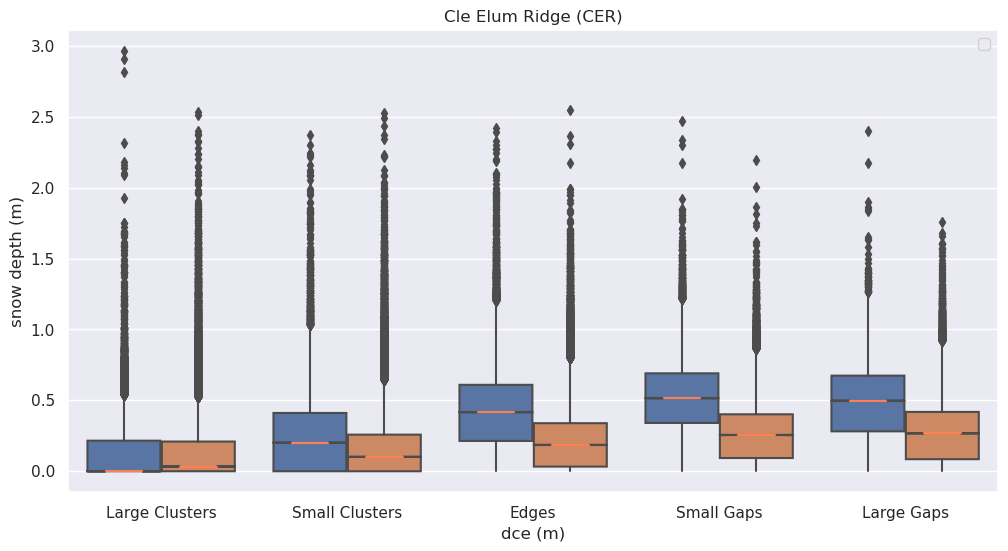

In [17]:
plt.figure(figsize=(12,6))

sns.boxplot(x=ds['dce_rapid_reclass'].values.flatten(), y=ds['hs_rapid'].values.flatten(), hue=ds['dah_reclass'].values.flatten(), notch=True, showcaps=False, medianprops={"color":"coral"}) # palette={1: 'orange', -1: 'blue'})
plt.xlabel('dce (m)')
plt.ylabel('snow depth (m)')
plt.title('Cle Elum Ridge (CER)')
plt.xticks([0,1,2,3,4], ['Large Clusters','Small Clusters','Edges','Small Gaps', 'Large Gaps'])
plt.legend('')
# 100: large clusters, 200: small clusters, 300: edges, 400: small gaps, 500: large gaps 

plt.show()

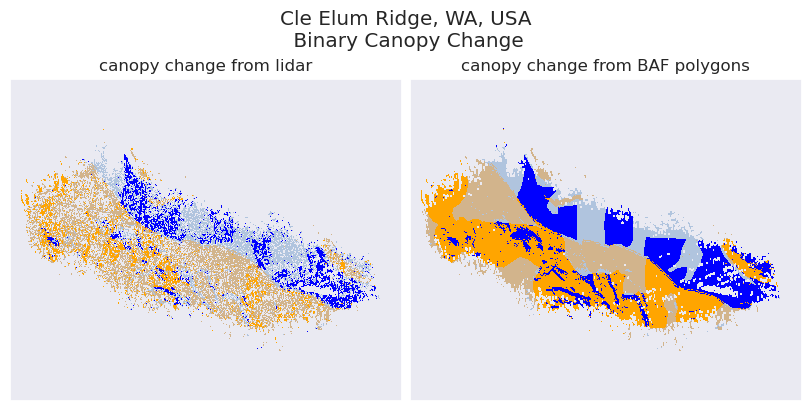

In [82]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(8,4), constrained_layout = True)

fig.suptitle('Cle Elum Ridge, WA, USA\n Binary Canopy Change')

# lidar
p1 = ds['hs_lidar_nocanopychange_dahpos'].plot(ax=axes[0], cmap=ListedColormap(['tan']),  
                                               label='control area with high heat index', add_colorbar=False) 
p2 = ds['hs_lidar_nocanopychange_dahneg'].plot(ax=axes[0], cmap=ListedColormap(['lightsteelblue']),
                                               label='control area with low heat index', add_colorbar=False) 

p3 = ds['hs_lidar_canopychange_dahneg'].plot(ax=axes[0], cmap=ListedColormap(['blue']),  
                                               label='treatment area with high heat index', add_colorbar=False) 
p4 = ds['hs_lidar_canopychange_dahpos'].plot(ax=axes[0], cmap=ListedColormap(['orange']),
                                               label='treatment area with low heat index', add_colorbar=False) 

# baf
p1 = ds['hs_baf_nocanopychange_dahpos'].plot(ax=axes[1], cmap=ListedColormap(['tan']),  
                                               label='control area with high heat index', add_colorbar=False) 
p2 = ds['hs_baf_nocanopychange_dahneg'].plot(ax=axes[1], cmap=ListedColormap(['lightsteelblue']),
                                               label='control area with low heat index', add_colorbar=False) 

p3 = ds['hs_baf_canopychange_dahneg'].plot(ax=axes[1], cmap=ListedColormap(['blue']),  
                                               label='treatment area with high heat index', add_colorbar=False) 
p4 = ds['hs_baf_canopychange_dahpos'].plot(ax=axes[1], cmap=ListedColormap(['orange']),
                                               label='treatment area with low heat index', add_colorbar=False) 

# plt.legend()
# # legend order
# # order=[0,1,3,2]
# handles, labels = plt.gca().get_legend_handles_labels()
# order=[3,2,0,1]
# plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])


# fix a few things on the figure 
axes[0].set_title('canopy change from lidar')
axes[1].set_title('canopy change from BAF polygons')

axes[0].set_xlabel('')
axes[0].set_ylabel('') 
axes[0].set_xticks([])
axes[0].set_yticks([])

axes[1].set_xlabel('')
axes[1].set_ylabel('') 
axes[1].set_xticks([])
axes[1].set_yticks([])

plt.show()

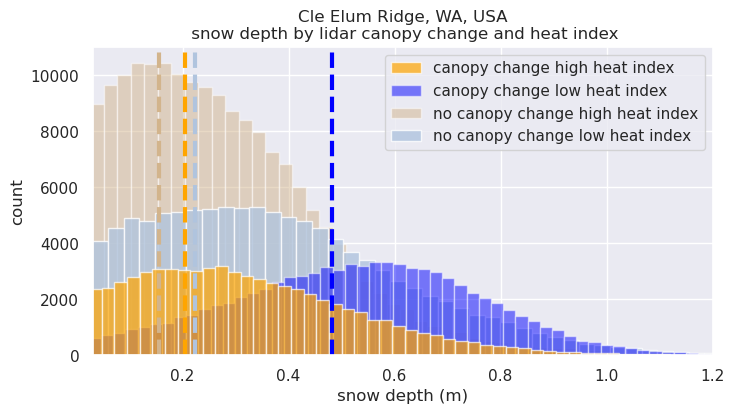

In [83]:
# plot histograms of the four groups 
fig, axes = plt.subplots(1, 1, figsize=(8,4))

p1 = ds['hs_lidar_nocanopychange_dahpos'].plot.hist(bins=100, label='no canopy change high heat index', alpha=.5, color='tan')
p2 = ds['hs_lidar_nocanopychange_dahneg'].plot.hist(bins=100, label='no canopy change low heat index', alpha=.8, color='lightsteelblue')

p4 = ds['hs_lidar_canopychange_dahneg'].plot.hist(bins=100, label='canopy change low heat index', alpha=.5, color='blue')
p3 = ds['hs_lidar_canopychange_dahpos'].plot.hist(bins=100, label='canopy change high heat index', alpha=.7, color='orange')

# plot the median lines for the histograms\
width=3
plt.axvline(ds['hs_lidar_nocanopychange_dahneg'].median(), color='lightsteelblue', linestyle='dashed', linewidth=width)
plt.axvline(ds['hs_lidar_nocanopychange_dahpos'].median(), color='tan', linestyle='dashed', linewidth=width)
plt.axvline(ds['hs_lidar_canopychange_dahneg'].median(), color='blue', linestyle='dashed', linewidth=width)
plt.axvline(ds['hs_lidar_canopychange_dahpos'].median(), color='orange', linestyle='dashed', linewidth=width)

# legend order
handles, labels = plt.gca().get_legend_handles_labels()
order=[3,2,0,1]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])

# constants
plt.title('Cle Elum Ridge, WA, USA\n snow depth by lidar canopy change and heat index')
plt.xlabel('snow depth (m)')
plt.ylabel('count')

plt.xlim(0.03,1.2)
plt.ylim(0,11000)
plt.show()

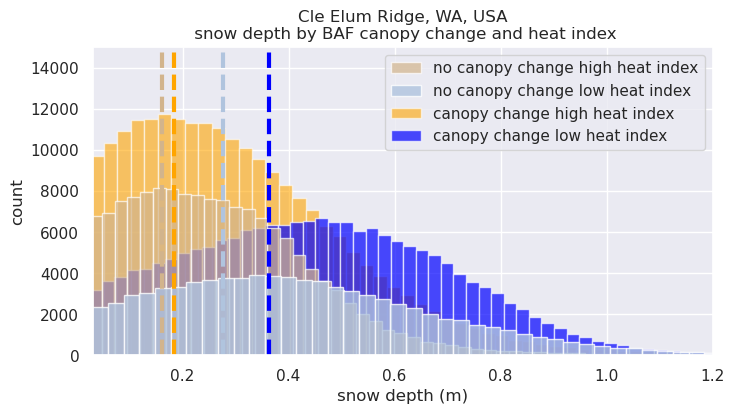

In [84]:
# plot histograms of the four groups 
fig, axes = plt.subplots(1, 1, figsize=(8,4))

p3 = ds['hs_baf_canopychange_dahpos'].plot.hist(bins=100, label='canopy change high heat index', alpha=.6, color='orange')
p4 = ds['hs_baf_canopychange_dahneg'].plot.hist(bins=100, label='canopy change low heat index', alpha=.7, color='blue')

p1 = ds['hs_baf_nocanopychange_dahpos'].plot.hist(bins=100, label='no canopy change high heat index', alpha=.7, color='tan')
p2 = ds['hs_baf_nocanopychange_dahneg'].plot.hist(bins=100, label='no canopy change low heat index', alpha=.8, color='lightsteelblue')

# plot the median lines for the histograms\
width=3
plt.axvline(ds['hs_baf_nocanopychange_dahneg'].median(), color='lightsteelblue', linestyle='dashed', linewidth=width)
plt.axvline(ds['hs_baf_nocanopychange_dahpos'].median(), color='tan', linestyle='dashed', linewidth=width)
plt.axvline(ds['hs_baf_canopychange_dahneg'].median(), color='blue', linestyle='dashed', linewidth=width)
plt.axvline(ds['hs_baf_canopychange_dahpos'].median(), color='orange', linestyle='dashed', linewidth=width)

# legend order
order=[2,3,0,1]
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])

# constants
plt.title('Cle Elum Ridge, WA, USA\n snow depth by BAF canopy change and heat index')
plt.xlabel('snow depth (m)')
plt.ylabel('count')

plt.xlim(0.03,1.2)
plt.ylim(0,15000)
plt.show()

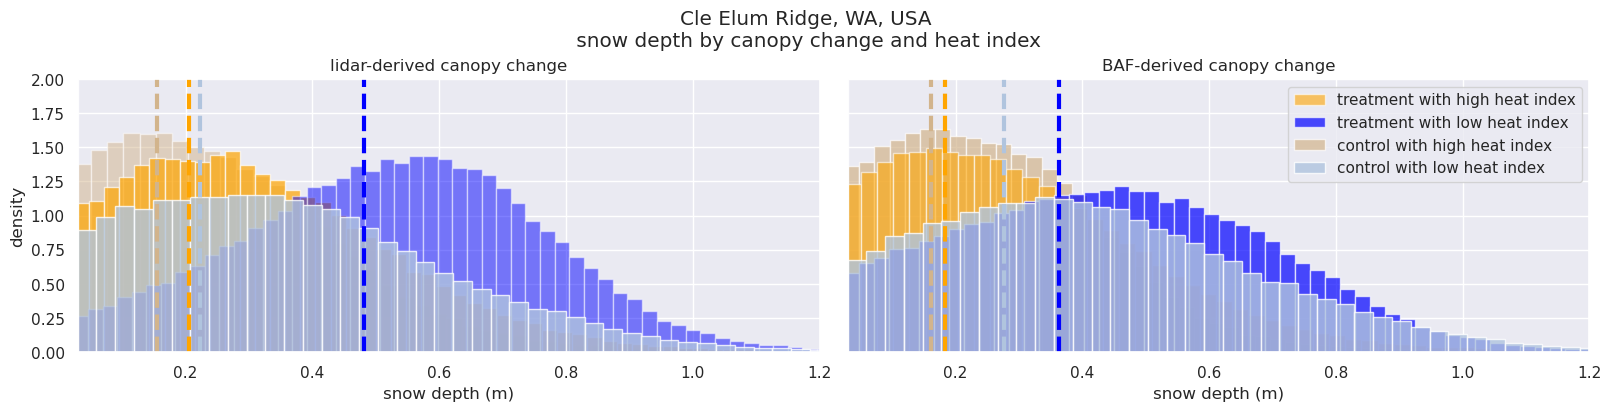

In [85]:
# plot histograms of the four groups 
fig, axes = plt.subplots(1, 2, figsize=(16,4), sharex=True, sharey=True, constrained_layout=True)

# LIDAR 
p1 = ds['hs_lidar_nocanopychange_dahpos'].plot.hist(ax=axes[0], bins=100, density=True, label='control with high heat index', alpha=.5, color='tan')
p3 = ds['hs_lidar_canopychange_dahpos'].plot.hist(ax=axes[0], bins=100, density=True, label='treatment with high heat index', alpha=.7, color='orange')
p4 = ds['hs_lidar_canopychange_dahneg'].plot.hist(ax=axes[0], bins=100, density=True, label='treatment with low heat index', alpha=.5, color='blue')
p2 = ds['hs_lidar_nocanopychange_dahneg'].plot.hist(ax=axes[0], bins=100, density=True, label='control with low heat index', alpha=.8, color='lightsteelblue')


width=3
axes[0].axvline(ds['hs_lidar_nocanopychange_dahneg'].median(), color='lightsteelblue', linestyle='dashed', linewidth=width)
axes[0].axvline(ds['hs_lidar_nocanopychange_dahpos'].median(), color='tan', linestyle='dashed', linewidth=width)
axes[0].axvline(ds['hs_lidar_canopychange_dahneg'].median(), color='blue', linestyle='dashed', linewidth=width)
axes[0].axvline(ds['hs_lidar_canopychange_dahpos'].median(), color='orange', linestyle='dashed', linewidth=width)

# # legend order
# order=[1,2,0,3]
# handles, labels = plt.gca().get_legend_handles_labels()
# axes[0].legend([handles[idx] for idx in order],[labels[idx] for idx in order])


# BAF
p1 = ds['hs_baf_nocanopychange_dahpos'].plot.hist(ax=axes[1], bins=100, density=True, label='control with high heat index', alpha=.7, color='tan')
p3 = ds['hs_baf_canopychange_dahpos'].plot.hist(ax=axes[1], bins=100, density=True, label='treatment with high heat index', alpha=.6, color='orange')
p4 = ds['hs_baf_canopychange_dahneg'].plot.hist(ax=axes[1], bins=100, density=True, label='treatment with low heat index', alpha=.7, color='blue')
p2 = ds['hs_baf_nocanopychange_dahneg'].plot.hist(ax=axes[1], bins=100, density=True, label='control with low heat index', alpha=.8, color='lightsteelblue')

width=3
axes[1].axvline(ds['hs_baf_nocanopychange_dahneg'].median(), color='lightsteelblue', linestyle='dashed', linewidth=width)
axes[1].axvline(ds['hs_baf_nocanopychange_dahpos'].median(), color='tan', linestyle='dashed', linewidth=width)
axes[1].axvline(ds['hs_baf_canopychange_dahneg'].median(), color='blue', linestyle='dashed', linewidth=width)
axes[1].axvline(ds['hs_baf_canopychange_dahpos'].median(), color='orange', linestyle='dashed', linewidth=width)

# legend order
order=[1,2,0,3]
handles, labels = plt.gca().get_legend_handles_labels()
axes[1].legend([handles[idx] for idx in order],[labels[idx] for idx in order])

# constants
plt.suptitle('Cle Elum Ridge, WA, USA\n snow depth by canopy change and heat index')

axes[0].set_title('lidar-derived canopy change')
axes[1].set_title('BAF-derived canopy change')

axes[0].set_xlabel('snow depth (m)')
axes[0].set_ylabel('density')
axes[0].set_xlim(0.03,1.2)
axes[0].set_ylim(0,2)

axes[1].set_xlabel('snow depth (m)')
axes[1].set_xlim(0.03,1.2)

plt.show()

In [86]:
# now, print all the medians
print('Lidar Canopy Change and High Heat Index: Median', ds['hs_lidar_canopychange_dahpos'].median().values )
print('Lidar Canopy Change and Low Heat Index:  Median', ds['hs_lidar_canopychange_dahneg'].median().values)
print('Lidar No Canopy Change and High Heat Index:  Median', ds['hs_lidar_nocanopychange_dahpos'].median().values)
print('Lidar No Canopy Change and Low Heat Index:  Median', ds['hs_lidar_nocanopychange_dahneg'].median().values)

Lidar Canopy Change and High Heat Index: Median 0.20507812
Lidar Canopy Change and Low Heat Index:  Median 0.48114014
Lidar No Canopy Change and High Heat Index:  Median 0.15515137
Lidar No Canopy Change and Low Heat Index:  Median 0.22320557


In [87]:
# now, print all the standard deviations
print('Lidar Canopy Change and High Heat Index: Median', ds['hs_lidar_canopychange_dahpos'].std().values)
print('Lidar Canopy Change and Low Heat Index:  Median', ds['hs_lidar_canopychange_dahneg'].std().values)
print('Lidar No Canopy Change and High Heat Index:  Median', ds['hs_lidar_nocanopychange_dahpos'].std().values)
print('Lidar No Canopy Change and Low Heat Index:  Median', ds['hs_lidar_nocanopychange_dahneg'].std().values)

Lidar Canopy Change and High Heat Index: Median 0.23048533
Lidar Canopy Change and Low Heat Index:  Median 0.2854448
Lidar No Canopy Change and High Heat Index:  Median 0.21468733
Lidar No Canopy Change and Low Heat Index:  Median 0.27026147


Before moving on to the tidy df,\
**Lets make some calculations** for total SWE in each of the four groups. 

In [88]:
#lidar
ds['hs_lidar_nocanopychange_dahneg_sum'] = ds['hs_lidar_nocanopychange_dahneg'].sum(dim=['x','y'])
ds['hs_lidar_nocanopychange_dahpos_sum'] = ds['hs_lidar_nocanopychange_dahpos'].sum(dim=['x','y'])
ds['hs_lidar_canopychange_dahneg_sum']   = ds['hs_lidar_canopychange_dahneg'].sum(dim=['x','y'])
ds['hs_lidar_canopychange_dahpos_sum']   = ds['hs_lidar_canopychange_dahpos'].sum(dim=['x','y'])

# now, print all the totals 
print('Lidar Canopy Change and High Heat Index: ', ds['hs_lidar_canopychange_dahpos_sum'].values)
print('Lidar Canopy Change and Low Heat Index: ', ds['hs_lidar_canopychange_dahneg_sum'].values)
print('Lidar No Canopy Change and High Heat Index: ', ds['hs_lidar_nocanopychange_dahpos_sum'].values)
print('Lidar No Canopy Change and Low Heat Index: ', ds['hs_lidar_nocanopychange_dahneg_sum'].values)

# baf
ds['hs_baf_nocanopychange_dahneg_sum'] = ds['hs_baf_nocanopychange_dahneg'].sum(dim=['x','y'])
ds['hs_baf_nocanopychange_dahpos_sum'] = ds['hs_baf_nocanopychange_dahpos'].sum(dim=['x','y'])
ds['hs_baf_canopychange_dahneg_sum']   = ds['hs_baf_canopychange_dahneg'].sum(dim=['x','y'])
ds['hs_baf_canopychange_dahpos_sum']   = ds['hs_baf_canopychange_dahpos'].sum(dim=['x','y'])

# now, print all the totals 
print('BAF Canopy Change and High Heat Index: ', ds['hs_baf_canopychange_dahpos_sum'].values)
print('BAF Canopy Change and Low Heat Index: ', ds['hs_baf_canopychange_dahneg_sum'].values)
print('BAF No Canopy Change and High Heat Index: ', ds['hs_baf_nocanopychange_dahpos_sum'].values)
print('BAF No Canopy Change and Low Heat Index: ', ds['hs_baf_nocanopychange_dahneg_sum'].values)

Lidar Canopy Change and High Heat Index:  [22149.969]
Lidar Canopy Change and Low Heat Index:  [45383.27]
Lidar No Canopy Change and High Heat Index:  [51702.098]
Lidar No Canopy Change and Low Heat Index:  [42167.375]
BAF Canopy Change and High Heat Index:  [71045.16]
BAF Canopy Change and Low Heat Index:  [85231.86]
BAF No Canopy Change and High Heat Index:  [40852.66]
BAF No Canopy Change and Low Heat Index:  [36693.13]


In [89]:
# make bar charts of the totals
# put the totals into a dataframe
lidar_totals = pd.DataFrame({'lidar canopy change and high heat index': ds['hs_lidar_canopychange_dahpos_sum'].values,
                             'lidar canopy change and low heat index': ds['hs_lidar_canopychange_dahneg_sum'].values,
                             'lidar no canopy change and high heat index': ds['hs_lidar_nocanopychange_dahpos_sum'].values,
                             'lidar no canopy change and low heat index': ds['hs_lidar_nocanopychange_dahneg_sum'].values})

baf_totals = pd.DataFrame({'BAF Canopy change and high heat index': ds['hs_baf_canopychange_dahpos_sum'].values,
                                'BAF canopy change and low heat index': ds['hs_baf_canopychange_dahneg_sum'].values,
                                'BAF no canopy change and high heat index': ds['hs_baf_nocanopychange_dahpos_sum'].values,
                                'BAF no canopy change and low heat index': ds['hs_baf_nocanopychange_dahneg_sum'].values})

In [90]:
lidar_totals.head()

lidar canopy change and high heat index   
0                              22149.96875  \

   lidar canopy change and low heat index   
0                            45383.269531  \

   lidar no canopy change and high heat index   
0                                51702.097656  \

   lidar no canopy change and low heat index  
0                                  42167.375

Text(0.5, 0, 'total snow depth (m)')

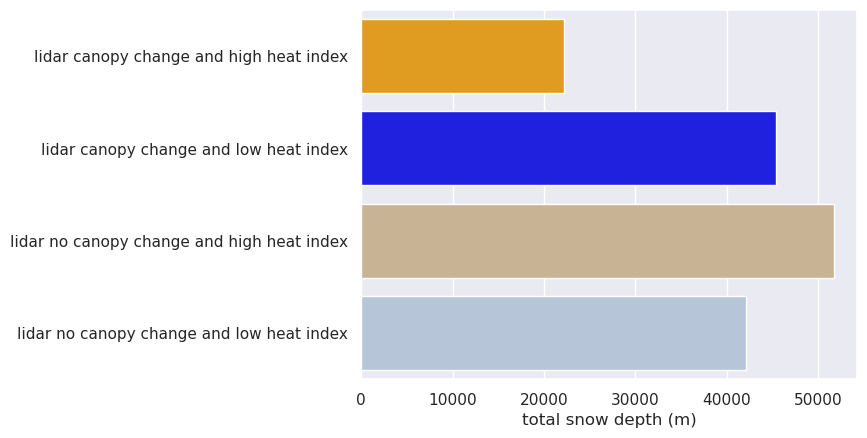

In [91]:
# make a color pallett 
mypal = ['orange', 'blue', 'tan', 'lightsteelblue']
sns.barplot(lidar_totals, orient='h', palette=mypal)
plt.xlabel('total snow depth (m)')

Text(0.5, 0, 'total snow depth (m)')

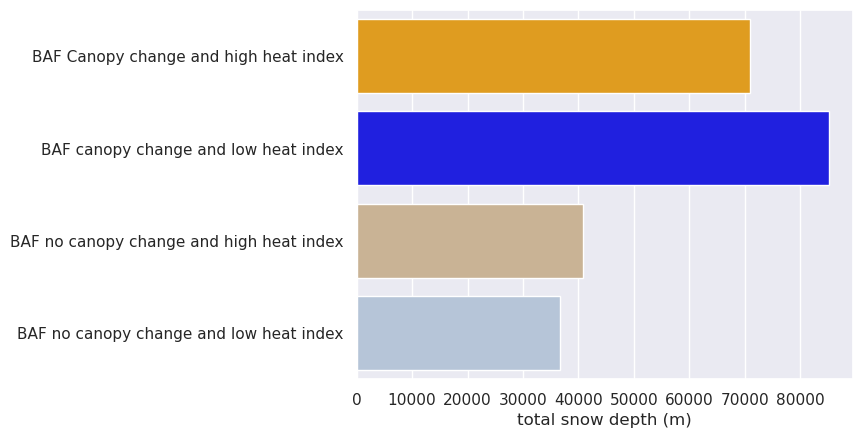

In [92]:
# make a color pallett 
mypal = ['orange', 'blue', 'tan', 'lightsteelblue']
sns.barplot(baf_totals, orient='h', palette=mypal)
plt.xlabel('total snow depth (m)')

### Calculating the total SWE for the area
* Since we have 1 m res rasters, we have each count in the hist = 1m^2 
* Thus, we can take the total SWE (below) divided by the total count for that variable to normalize between the sizes of the groups 

In [93]:
# make bar charts of the totals
# put the totals into a dataframe
density = 310

lidar_totals_swe = pd.DataFrame({'treatment with high heat index': 
                                 (ds['hs_lidar_canopychange_dahpos_sum'].values*density)/(ds['hs_baf_nocanopychange_dahpos'].count().values),
                             'treatment with low heat index':
                                 (ds['hs_lidar_canopychange_dahneg_sum'].values*density)/(ds['hs_lidar_canopychange_dahneg'].count().values),
                             'control with high heat index':
                                 (ds['hs_lidar_nocanopychange_dahpos_sum'].values*density)/(ds['hs_lidar_nocanopychange_dahpos'].count().values),
                             'control with low heat index':
                                 (ds['hs_lidar_nocanopychange_dahneg_sum'].values*density)/(ds['hs_lidar_nocanopychange_dahneg'].count().values),
                                  })

baf_totals_swe = pd.DataFrame({'treatment with high heat index':
                               (ds['hs_baf_canopychange_dahpos_sum'].values*density)/(ds['hs_baf_canopychange_dahpos'].count().values),
                                'treatment with low heat index': 
                                (ds['hs_baf_canopychange_dahneg_sum'].values*density)/(ds['hs_baf_canopychange_dahneg'].count().values),
                                'control with high heat index': 
                                (ds['hs_baf_nocanopychange_dahpos_sum'].values*density)/(ds['hs_baf_nocanopychange_dahpos'].count().values),
                                'control with low heat index': 
                                (ds['hs_baf_nocanopychange_dahneg_sum'].values*density)/(ds['hs_baf_nocanopychange_dahneg'].count().values),
                                })

In [94]:
lidar_totals_swe.head()

treatment with high heat index  treatment with low heat index   
0                       33.133356                     140.422741  \

   control with high heat index  control with low heat index  
0                     62.744281                    84.537092

We are going to do this calculation with two different snow density measuremenets
1. with 310kg/m3 (or .31% water) for everywhere
2. with 0.29 on north and 0.34 on south to see how more dense snow on the south aspect impacts SWE

In [95]:
# make bar charts of the totals
# put the totals into a dataframe
densitynorth = 290
densitysouth = 340

lidar_totals_swe2 = pd.DataFrame({'treatment with high heat index': 
                                 (ds['hs_lidar_canopychange_dahpos_sum'].values*densitysouth)/(ds['hs_baf_nocanopychange_dahpos'].count().values),
                             'treatment with low heat index':
                                 (ds['hs_lidar_canopychange_dahneg_sum'].values*densitynorth)/(ds['hs_lidar_canopychange_dahneg'].count().values),
                             'control with high heat index':
                                 (ds['hs_lidar_nocanopychange_dahpos_sum'].values*densitysouth)/(ds['hs_lidar_nocanopychange_dahpos'].count().values),
                             'control with low heat index':
                                 (ds['hs_lidar_nocanopychange_dahneg_sum'].values*densitynorth)/(ds['hs_lidar_nocanopychange_dahneg'].count().values),
                                  })

baf_totals_swe2 = pd.DataFrame({'treatment with high heat index':
                               (ds['hs_baf_canopychange_dahpos_sum'].values*densitysouth)/(ds['hs_baf_canopychange_dahpos'].count().values),
                                'treatment with low heat index': 
                                (ds['hs_baf_canopychange_dahneg_sum'].values*densitynorth)/(ds['hs_baf_canopychange_dahneg'].count().values),
                                'control with high heat index': 
                                (ds['hs_baf_nocanopychange_dahpos_sum'].values*densitysouth)/(ds['hs_baf_nocanopychange_dahpos'].count().values),
                                'control with low heat index': 
                                (ds['hs_baf_nocanopychange_dahneg_sum'].values*densitynorth)/(ds['hs_baf_nocanopychange_dahneg'].count().values),
                                })

In [96]:
lidar_totals_swe2.head()

treatment with high heat index  treatment with low heat index   
0                        36.33981                     131.363204  \

   control with high heat index  control with low heat index  
0                     68.816312                    79.083089

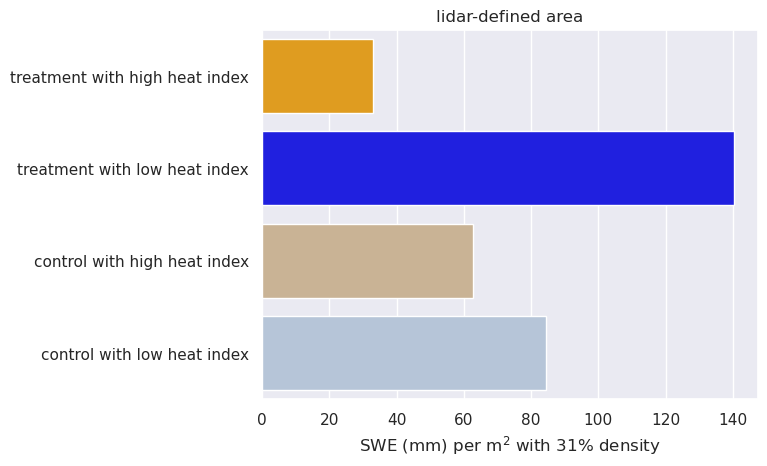

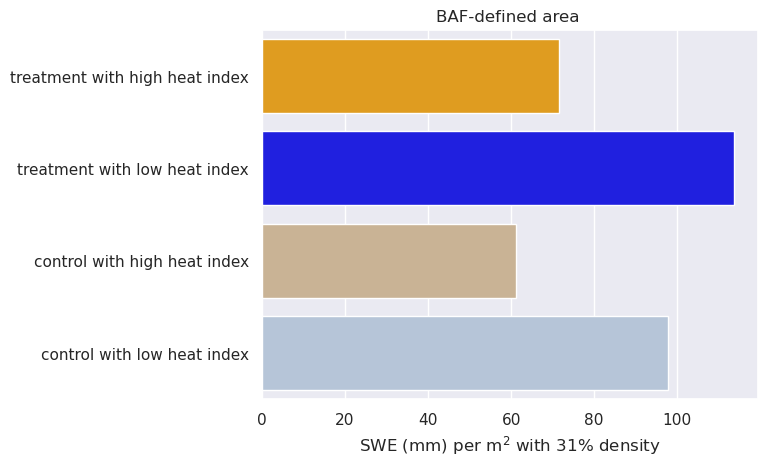

In [97]:
mypal = ['orange', 'blue', 'tan', 'lightsteelblue']
sns.barplot(lidar_totals_swe, orient='h', palette=mypal)
plt.xlabel('SWE (mm) per m$^2$ with 31% density')
# plt.xlim(0,140)
plt.title('lidar-defined area')
plt.show()

mypal = ['orange', 'blue', 'tan', 'lightsteelblue']
sns.barplot(baf_totals_swe, orient='h', palette=mypal)
plt.xlabel('SWE (mm) per m$^2$ with 31% density')
# plt.xlim(0,140)
plt.title('BAF-defined area ')
plt.show()

Plot SWE2 also, with variable density measurements on north and south side

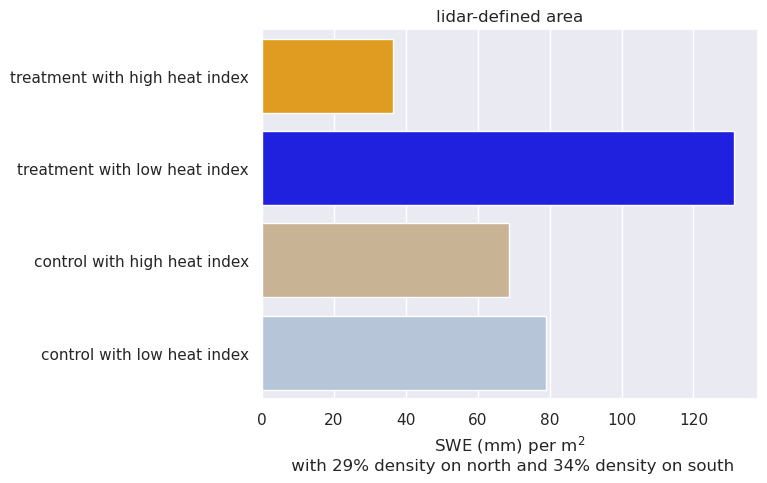

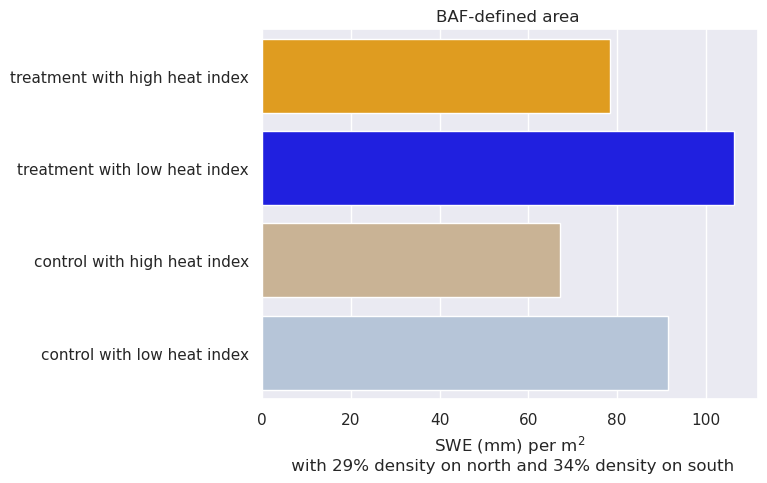

In [98]:
mypal = ['orange', 'blue', 'tan', 'lightsteelblue']
sns.barplot(lidar_totals_swe2, orient='h', palette=mypal)
plt.xlabel('SWE (mm) per m$^2$\n with 29% density on north and 34% density on south')
# plt.xlim(0,140)
plt.title('lidar-defined area')
plt.show()

mypal = ['orange', 'blue', 'tan', 'lightsteelblue']
sns.barplot(baf_totals_swe2, orient='h', palette=mypal)
plt.xlabel('SWE (mm) per m$^2$\n with 29% density on north and 34% density on south')
# plt.xlim(0,140)
plt.title('BAF-defined area ')
plt.show()

Also, calculate total area 

In [99]:
# put the totals into a dataframe
lidar_totals_area = pd.DataFrame({'treatment with high heat index area': 
                                 ds['hs_baf_nocanopychange_dahpos'].count().values,
                             'treatment with low heat index area':
                                 ds['hs_lidar_canopychange_dahneg'].count().values,
                             'control with high heat index area':
                                 ds['hs_lidar_nocanopychange_dahpos'].count().values,
                             'control with low heat index area':
                                 ds['hs_lidar_nocanopychange_dahneg'].count().values,
                                  }, index=[0])

baf_totals_area = pd.DataFrame({'treatment with high heat index area':
                               ds['hs_baf_canopychange_dahpos'].count().values,
                                'treatment with low heat index area': 
                                ds['hs_baf_canopychange_dahneg'].count().values,
                                'control with high heat index area': 
                                ds['hs_baf_nocanopychange_dahpos'].count().values,
                                'control with low heat index area': 
                                ds['hs_baf_nocanopychange_dahneg'].count().values,
                                }, index=[0])

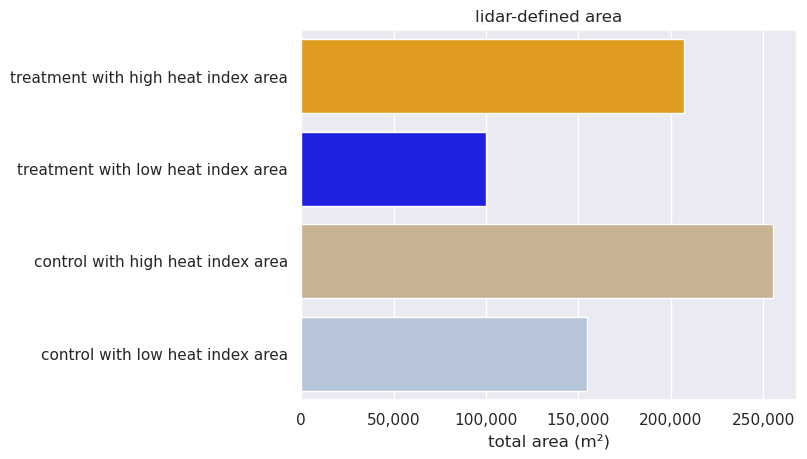

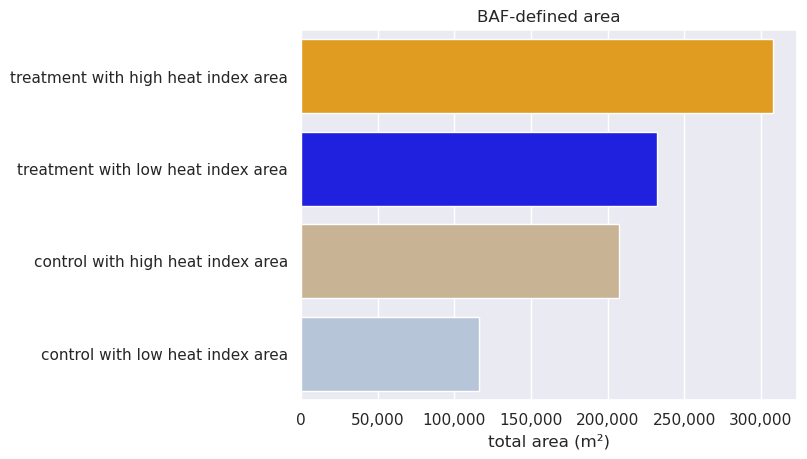

In [100]:
# make a color pallette
mypal = ['orange', 'blue', 'tan', 'lightsteelblue']
sns.barplot((lidar_totals_area), orient='h', palette=mypal)
plt.xlabel('total area (m²)')

# format the x ticks to show the full number 
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.0f'))
# add a comma between the thousands place and the hundreds place
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: format(int(x), ',')))
# plt.xlim(0,330)
# plt.xlim(0,2850000)
plt.title('lidar-defined area')
plt.show()


# make a color pallette
mypal = ['orange', 'blue', 'tan', 'lightsteelblue']
sns.barplot(baf_totals_area, orient='h', palette=mypal)
plt.xlabel('total area (m²)')

# format the x ticks to show the full number 
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.0f'))
# add a comma between the thousands place and the hundreds place
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: format(int(x), ',')))
# plt.xlim(0,330)
# plt.xlim(0,2850000)
plt.title('BAF-defined area')
plt.show()

To conver this m2 to km2, we need to divide by 1,000,000 

In [101]:
lidar_totals_area_km = lidar_totals_area/1000000
baf_totals_area_km = baf_totals_area/1000000
lidar_totals_area_km.head()

treatment with high heat index area  treatment with low heat index area   
0                             0.207238                            0.100189  \

   control with high heat index area  control with low heat index area  
0                           0.255444                          0.154629

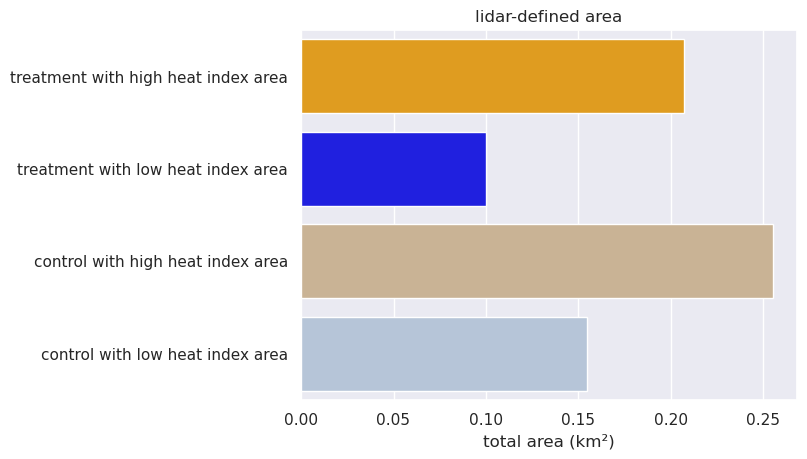

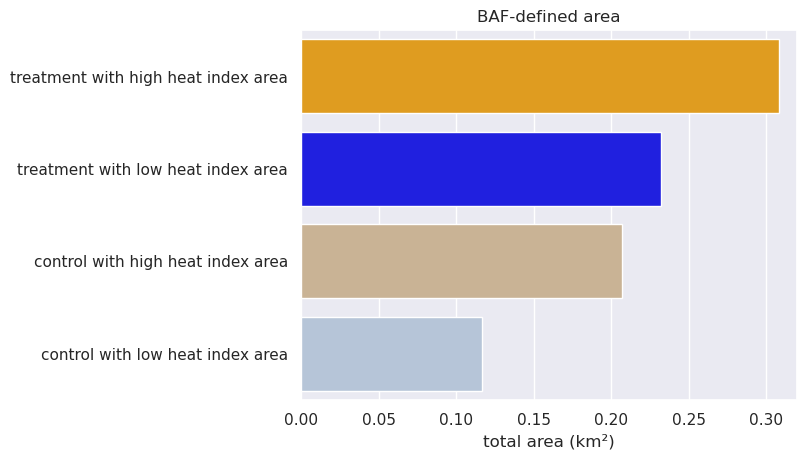

In [102]:
mypal = ['orange', 'blue', 'tan', 'lightsteelblue']
sns.barplot(lidar_totals_area_km, orient='h', palette=mypal)
plt.xlabel('total area (km²)')
# plt.xlim(0,0.32)
plt.title('lidar-defined area')
plt.show()

mypal = ['orange', 'blue', 'tan', 'lightsteelblue']
sns.barplot(baf_totals_area_km, orient='h', palette=mypal)
plt.xlabel('total area (km²)')
plt.xlim(0,0.32)
plt.title('BAF-defined area')
plt.show()

What if we want to know the TOTAL SWE? 
* SWE mm per area (m2) * area (m2)

In [161]:
# I moved all of this to excel because the table got too big
lidar_totals_swe

treatment with high heat index  treatment with low heat index   
0                       33.133356                     140.422741  \

   control with high heat index  control with low heat index  
0                     62.744281                    84.537092

In [162]:
lidar_totals_area

treatment with high heat index area  treatment with low heat index area   
0                               207238                              100189  \

   control with high heat index area  control with low heat index area  
0                             255444                            154629

In [167]:
lidar_totals_swe_total = lidar_totals_swe.copy(deep=True)
lidar_totals_swe_total['treatment with high heat index'] = lidar_totals_swe['treatment with high heat index']*lidar_totals_area['treatment with high heat index area']
lidar_totals_swe_total['treatment with low heat index'] = lidar_totals_swe['treatment with low heat index']*lidar_totals_area['treatment with low heat index area']
lidar_totals_swe_total['control with high heat index'] = lidar_totals_swe['control with high heat index']*lidar_totals_area['control with high heat index area']
lidar_totals_swe_total['control with low heat index'] = lidar_totals_swe['control with low heat index']*lidar_totals_area['control with low heat index area']

baf_totals_swe_total = baf_totals_swe.copy(deep=True)
baf_totals_swe_total['treatment with high heat index'] = baf_totals_swe['treatment with high heat index']*baf_totals_area['treatment with high heat index area']
baf_totals_swe_total['treatment with low heat index'] = baf_totals_swe['treatment with low heat index']*baf_totals_area['treatment with low heat index area']
baf_totals_swe_total['control with high heat index'] = baf_totals_swe['control with high heat index']*baf_totals_area['control with high heat index area']
baf_totals_swe_total['control with low heat index'] = baf_totals_swe['control with low heat index']*baf_totals_area['control with low heat index area']

In [166]:
lidar_totals_swe_total

treatment with high heat index  treatment with low heat index   
0                       6866490.5                     14068814.0  \

   control with high heat index  control with low heat index  
0                    16027650.0                   13071886.0

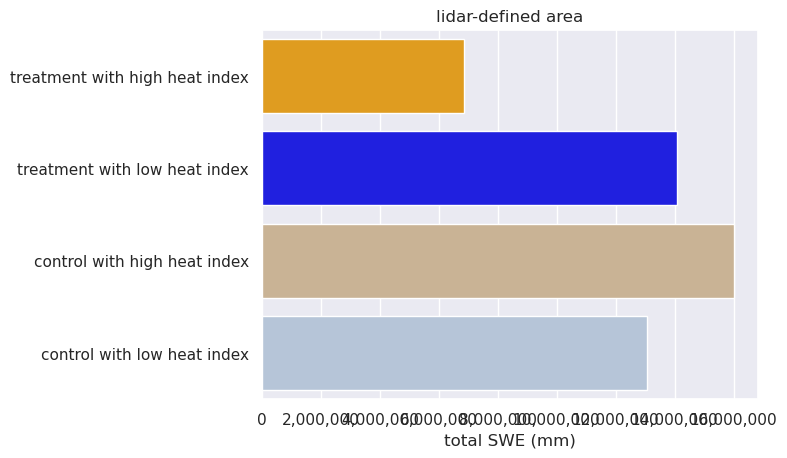

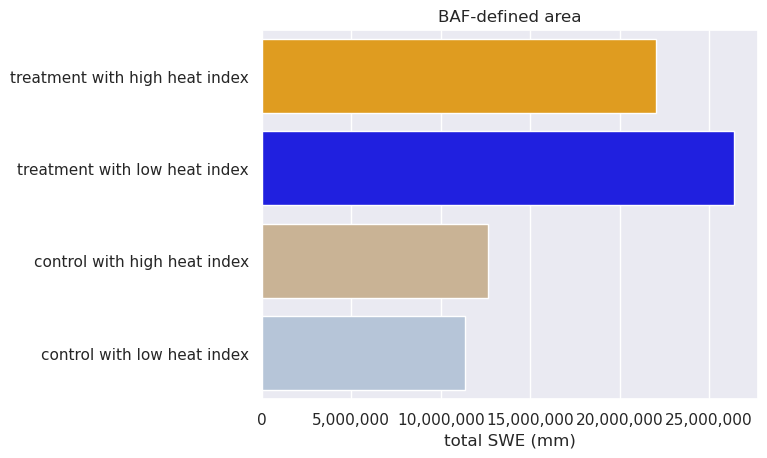

In [168]:
mypal = ['orange', 'blue', 'tan', 'lightsteelblue']
sns.barplot(lidar_totals_swe_total, orient='h', palette=mypal)
plt.xlabel('total SWE (mm)')

# format the x ticks to show the full number 
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.0f'))
# add a comma between the thousands place and the hundreds place
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: format(int(x), ',')))
# plt.xlim(0,330)
# plt.xlim(0,2850000)
plt.title('lidar-defined area')
plt.show()


mypal = ['orange', 'blue', 'tan', 'lightsteelblue']
sns.barplot(baf_totals_swe_total, orient='h', palette=mypal)
plt.xlabel('total SWE (mm)')

# format the x ticks to show the full number 
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.0f'))
# add a comma between the thousands place and the hundreds place
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: format(int(x), ',')))
# plt.xlim(0,330)
# plt.xlim(0,2850000)
plt.title('BAF-defined area')
plt.show()

# SDV

In [19]:
# calculate the difference between the ncalm and rapid dce 
ds['diff_dce_rapid_ncalm'] = ds['dce_rapid'] - ds['dce_ncalm']

# calculate difference in snow depth 
ds['diff_hs_rapid_ncalm'] = ds['hs_rapid'] - ds['hs_ncalm']

### SDV (standardized depth values) Analysis (code below from Steven)
https://github.com/spestana/RAPID_raster_analysis/blob/main/6_rapid_compare_canopy_v3.ipynb

**normalize snow depth between ncalm and rapid**\
standardized depth values\
take the snow depth maps, and describe the # of standard deviations the depth is from the mean value across the area\
https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2010WR009434

In [20]:
# I'm not sure if we need this or not yet, for the entire sample, making for now
ds['sum_hs_rapid_ncalm'] = ds['hs_rapid'] + ds['hs_ncalm']

In [21]:
# Per Justin, we should remove snow depths = 0
ds['hs_rapid_nozeros'] = ds['hs_rapid'].where(ds['hs_rapid']!=0)
ds['hs_ncalm_nozeros'] = ds['hs_ncalm'].where(ds['hs_ncalm']!=0)

In [22]:
# SVD = (measured snow depth at a point - the mean depth for the survey) / the standard deviation of the survey
ds['sdv_rapid'] = (ds['hs_rapid'] - ds['hs_rapid'].mean(dim=['x','y'])) / ds['hs_rapid'].std(dim=['x','y'])
ds['sdv_ncalm'] = (ds['hs_ncalm'] - ds['hs_ncalm'].mean(dim=['x','y'])) / ds['hs_ncalm'].std(dim=['x','y'])

ds['diff_sdv_rapid_ncalm'] = (ds['sdv_rapid'] - ds['sdv_ncalm'])

In [23]:
ds['diff_sdv_rapid_ncalm_lidar'].median().values

KeyError: 'diff_sdv_rapid_ncalm_lidar'

In [ ]:
# Alternatively, compute SVD only based on the mean and standar deviation of the "control" (no forest change) areas
# SDV = (measured snow depth at a point - the mean of snow depth in the control areas) / the standard deviation of snow depth in the control areas

# Find where no canopy change has occured, use this to select in ds.where() statements below
select_lidar_nocanopychange = ds['lidar_nocanopychange_dahneg'].notnull() | ds['lidar_nocanopychange_dahpos'].notnull()
select_baf_nocanopychange = ds['baf_nocanopychange_dahneg'].notnull() | ds['baf_nocanopychange_dahpos'].notnull()

# for RAPID data: mean and standard deviation of snow depth in the control areas (nocanopychange)
hs_rapid_lidar_nocanopychange_mean = ds['hs_rapid_nozeros'].where(select_lidar_nocanopychange).mean(dim=['x','y'])
hs_rapid_lidar_nocanopychange_std = ds['hs_rapid_nozeros'].where(select_lidar_nocanopychange).std(dim=['x','y'])
hs_rapid_baf_nocanopychange_mean = ds['hs_rapid_nozeros'].where(select_baf_nocanopychange).mean(dim=['x','y'])
hs_rapid_baf_nocanopychange_std = ds['hs_rapid_nozeros'].where(select_baf_nocanopychange).std(dim=['x','y'])
# SDV for RAPID, using lidar-defined control areas
ds['sdv_rapid_lidar'] = (ds['hs_rapid_nozeros'] - hs_rapid_lidar_nocanopychange_mean) / hs_rapid_lidar_nocanopychange_std
# SDV for RAPID, using BAF-defined control areas
ds['sdv_rapid_baf'] = (ds['hs_rapid_nozeros'] - hs_rapid_baf_nocanopychange_mean) / hs_rapid_baf_nocanopychange_std

# for NCALM data: mean and standard deviation of snow depth in the control areas (nocanopychange)
hs_ncalm_lidar_nocanopychange_mean = ds['hs_ncalm_nozeros'].where(select_lidar_nocanopychange).mean(dim=['x','y'])
hs_ncalm_lidar_nocanopychange_std = ds['hs_ncalm_nozeros'].where(select_lidar_nocanopychange).std(dim=['x','y'])
hs_ncalm_baf_nocanopychange_mean = ds['hs_ncalm_nozeros'].where(select_baf_nocanopychange).mean(dim=['x','y'])
hs_ncalm_baf_nocanopychange_std = ds['hs_ncalm_nozeros'].where(select_baf_nocanopychange).std(dim=['x','y'])
# SDV for NCALM, using lidar-defined control areas
ds['sdv_ncalm_lidar'] = (ds['hs_ncalm_nozeros'] - hs_ncalm_lidar_nocanopychange_mean) / hs_ncalm_lidar_nocanopychange_std
# SDV for NCALM, using BAF-defined control areas
ds['sdv_ncalm_baf'] = (ds['hs_ncalm_nozeros'] - hs_ncalm_baf_nocanopychange_mean) / hs_ncalm_baf_nocanopychange_std

ds['diff_sdv_rapid_ncalm_lidar'] = (ds['sdv_rapid_lidar'] - ds['sdv_ncalm_lidar'])
ds['diff_sdv_rapid_ncalm_baf'] = (ds['sdv_rapid_baf'] - ds['sdv_ncalm_baf'])

________________________
Hopefully the difference between SDV is about 0 for areas that had no change, and then non-zero for areas that were changed

Now, make plots of the control and the treatment histograms (all aspects) together to compare

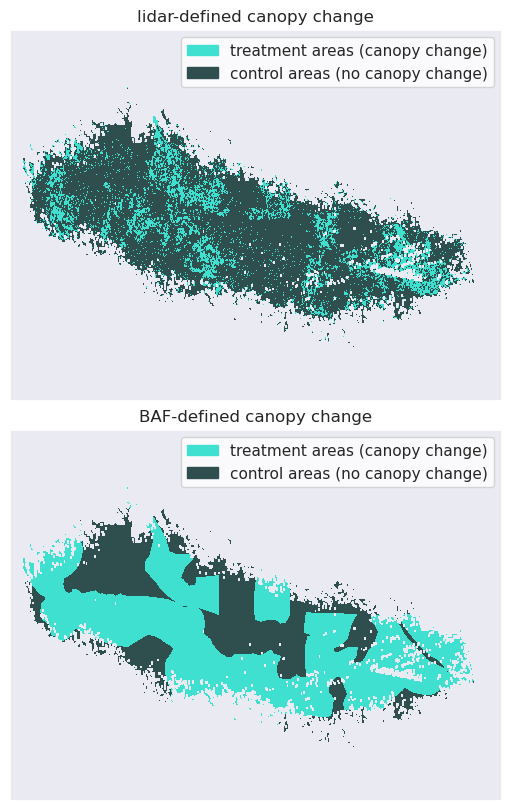

In [117]:
fig, axes = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(5,8), constrained_layout = True)

p1 = ds['lidar_canopychange_binary'].plot(ax=axes[0], cmap=ListedColormap(['darkslategrey','turquoise']), add_colorbar=False) 
p2 = ds['baf_canopychange_binary'].plot(ax=axes[1],   cmap=ListedColormap(['darkslategrey','turquoise']), add_colorbar=False)  


# Add a legend for labels
legend_labels = {"turquoise": "treatment areas (canopy change)", 
                 "darkslategrey": "control areas (no canopy change)"}

patches = [Patch(color=color, label=label)
           for color, label in legend_labels.items()]

axes[0].legend(handles=patches,
          bbox_to_anchor=(1, 1),
          facecolor="white")

axes[1].legend(handles=patches,
          bbox_to_anchor=(1, 1),
          facecolor="white")


# fix a few things on the figure 
axes[0].set_title('lidar-defined canopy change')
axes[1].set_title('BAF-defined canopy change')

axes[0].set_xlabel('');axes[0].set_ylabel('');axes[0].set_xticks([]);axes[0].set_yticks([])
axes[1].set_xlabel('');axes[1].set_ylabel('');axes[1].set_xticks([]);axes[1].set_yticks([])

plt.show()

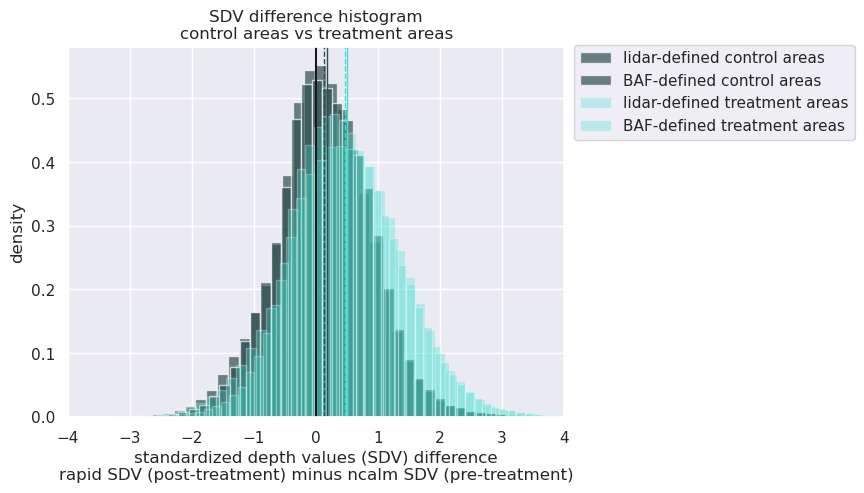

In [118]:
# colors for change and no change, making them completly different colors to not be confused with the other plots 
# cmap=ListedColormap(['darkslategrey','turquoise']
ds['diff_sdv_rapid_ncalm_lidar'].where(select_lidar_nocanopychange).plot.hist(bins=100, color='darkslategrey', alpha=0.7, density=True, label='lidar-defined control areas');
ds['diff_sdv_rapid_ncalm_baf'].where(select_baf_nocanopychange).plot.hist(bins=100, color='darkslategrey', alpha=0.7, density=True, label='BAF-defined control areas');
ds['diff_sdv_rapid_ncalm_lidar'].where(~select_lidar_nocanopychange).plot.hist(bins=100, color='turquoise',alpha=0.3, density=True, label='lidar-defined treatment areas');
ds['diff_sdv_rapid_ncalm_baf'].where(~select_baf_nocanopychange).plot.hist(bins=100, color='turquoise',alpha=0.3, density=True, label='BAF-defined treatment areas');

# plot median lines for all of those histograms
width=1
plt.axvline(ds['diff_sdv_rapid_ncalm_lidar'].where(select_lidar_nocanopychange).mean(), color='darkslategrey', linestyle='dashed', linewidth=width)
plt.axvline(ds['diff_sdv_rapid_ncalm_baf'].where(select_baf_nocanopychange).mean(), color='darkslategrey', linestyle='solid', linewidth=width)
plt.axvline(ds['diff_sdv_rapid_ncalm_lidar'].where(~select_lidar_nocanopychange).mean(), color='turquoise', linestyle='dashed', linewidth=width)
plt.axvline(ds['diff_sdv_rapid_ncalm_baf'].where(~select_baf_nocanopychange).mean(), color='turquoise', linestyle='solid', linewidth=width)

plt.xlim(-4,4);
plt.legend(loc=(1.02,.75));
plt.axvline(0,c='k')
plt.ylabel('density')
plt.xlabel('standardized depth values (SDV) difference\nrapid SDV (post-treatment) minus ncalm SDV (pre-treatment)')
plt.title('SDV difference histogram\ncontrol areas vs treatment areas');
# plt.title('SDV difference histogram for "canopy change" areas only');

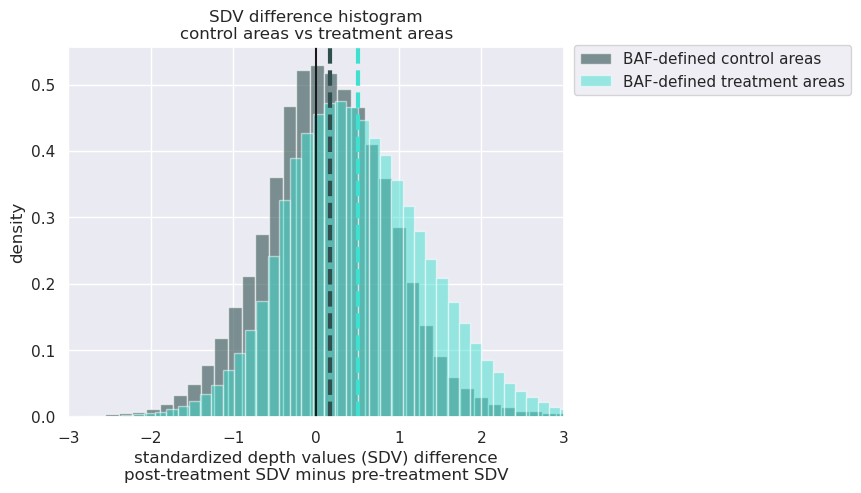

In [119]:
# colors for change and no change, making them completly different colors to not be confused with the other plots 
# cmap=ListedColormap(['darkslategrey','turquoise']
# ds['diff_sdv_rapid_ncalm_lidar'].where(select_lidar_nocanopychange).plot.hist(bins=100, color='darkslategrey', alpha=0.6, density=True, label='lidar-defined control areas');
ds['diff_sdv_rapid_ncalm_baf'].where(select_baf_nocanopychange).plot.hist(bins=100, color='darkslategrey', alpha=0.6, density=True, label='BAF-defined control areas');
# ds['diff_sdv_rapid_ncalm_lidar'].where(~select_lidar_nocanopychange).plot.hist(bins=100, color='turquoise',alpha=0.5, density=True, label='lidar-defined treatment areas');
ds['diff_sdv_rapid_ncalm_baf'].where(~select_baf_nocanopychange).plot.hist(bins=100, color='turquoise',alpha=0.5, density=True, label='BAF-defined treatment areas');

# plot median lines for all of those histograms
width=3
# plt.axvline(ds['diff_sdv_rapid_ncalm_lidar'].where(select_lidar_nocanopychange).median(), color='darkslategrey', linestyle='dashed', linewidth=width)
# # plt.axvline(ds['diff_sdv_rapid_ncalm_baf'].where(select_baf_nocanopychange).median(), color='darkslategrey', linestyle='solid', linewidth=width)
# plt.axvline(ds['diff_sdv_rapid_ncalm_lidar'].where(~select_lidar_nocanopychange).median(), color='turquoise', linestyle='dashed', linewidth=width)
# # plt.axvline(ds['diff_sdv_rapid_ncalm_baf'].where(~select_baf_nocanopychange).median(), color='turquoise', linestyle='solid', linewidth=width)

# plt.axvline(ds['diff_sdv_rapid_ncalm_lidar'].where(select_lidar_nocanopychange).mean(), color='darkslategrey', linestyle='dashed', linewidth=width)
plt.axvline(ds['diff_sdv_rapid_ncalm_baf'].where(select_baf_nocanopychange).mean(), color='darkslategrey', linestyle='dashed', linewidth=width)
# plt.axvline(ds['diff_sdv_rapid_ncalm_lidar'].where(~select_lidar_nocanopychange).mean(), color='turquoise', linestyle='dashed', linewidth=width)
plt.axvline(ds['diff_sdv_rapid_ncalm_baf'].where(~select_baf_nocanopychange).mean(), color='turquoise', linestyle='dashed', linewidth=width)

plt.xlim(-3,3);
plt.legend(loc=(1.02,.87));
plt.axvline(0,c='k')
plt.ylabel('density')
# plt.xlabel('standardized depth values (SDV) difference\nrapid SDV (post-treatment) minus ncalm SDV (pre-treatment)')
plt.xlabel('standardized depth values (SDV) difference\npost-treatment SDV minus pre-treatment SDV')

plt.title('SDV difference histogram\ncontrol areas vs treatment areas');
# plt.title('SDV difference histogram for "canopy change" areas only');

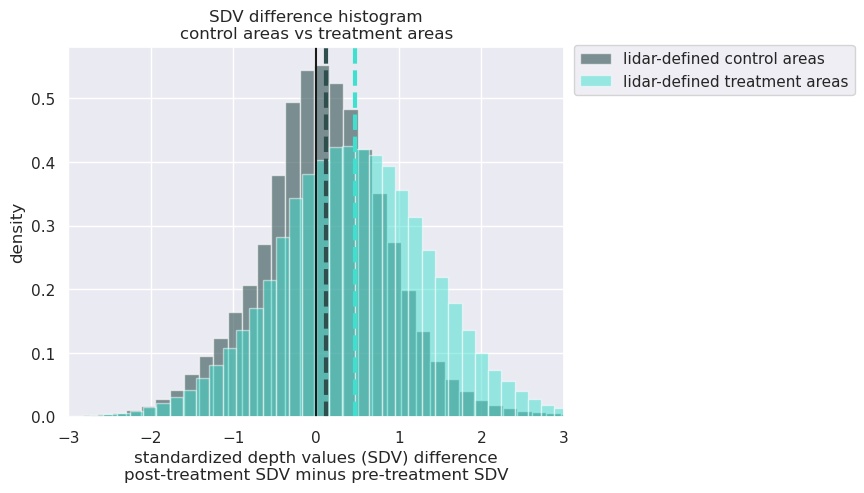

In [120]:
# colors for change and no change, making them completly different colors to not be confused with the other plots 
# cmap=ListedColormap(['darkslategrey','turquoise']
ds['diff_sdv_rapid_ncalm_lidar'].where(select_lidar_nocanopychange).plot.hist(bins=100, color='darkslategrey', alpha=0.6, density=True, label='lidar-defined control areas');
# ds['diff_sdv_rapid_ncalm_baf'].where(select_baf_nocanopychange).plot.hist(bins=100, color='darkslategrey', alpha=0.5, density=True, label='BAF-defined control areas');
ds['diff_sdv_rapid_ncalm_lidar'].where(~select_lidar_nocanopychange).plot.hist(bins=100, color='turquoise',alpha=0.5, density=True, label='lidar-defined treatment areas');
# ds['diff_sdv_rapid_ncalm_baf'].where(~select_baf_nocanopychange).plot.hist(bins=100, color='turquoise',alpha=0.5, density=True, label='BAF-defined treatment areas');

# plot median lines for all of those histograms
width=3
# plt.axvline(ds['diff_sdv_rapid_ncalm_lidar'].where(select_lidar_nocanopychange).median(), color='darkslategrey', linestyle='dashed', linewidth=width)
# # plt.axvline(ds['diff_sdv_rapid_ncalm_baf'].where(select_baf_nocanopychange).median(), color='darkslategrey', linestyle='solid', linewidth=width)
# plt.axvline(ds['diff_sdv_rapid_ncalm_lidar'].where(~select_lidar_nocanopychange).median(), color='turquoise', linestyle='dashed', linewidth=width)
# # plt.axvline(ds['diff_sdv_rapid_ncalm_baf'].where(~select_baf_nocanopychange).median(), color='turquoise', linestyle='solid', linewidth=width)

plt.axvline(ds['diff_sdv_rapid_ncalm_lidar'].where(select_lidar_nocanopychange).mean(), color='darkslategrey', linestyle='dashed', linewidth=width)
# plt.axvline(ds['diff_sdv_rapid_ncalm_baf'].where(select_baf_nocanopychange).mean(), color='darkslategrey', linestyle='solid', linewidth=width)
plt.axvline(ds['diff_sdv_rapid_ncalm_lidar'].where(~select_lidar_nocanopychange).mean(), color='turquoise', linestyle='dashed', linewidth=width)
# plt.axvline(ds['diff_sdv_rapid_ncalm_baf'].where(~select_baf_nocanopychange).mean(), color='turquoise', linestyle='solid', linewidth=width)

plt.xlim(-3,3);
plt.legend(loc=(1.02,.87));
plt.axvline(0,c='k')
plt.ylabel('density')
# plt.xlabel('standardized depth values (SDV) difference\nrapid SDV (post-treatment) minus ncalm SDV (pre-treatment)')
plt.xlabel('standardized depth values (SDV) difference\npost-treatment SDV minus pre-treatment SDV')

plt.title('SDV difference histogram\ncontrol areas vs treatment areas');
# plt.title('SDV difference histogram for "canopy change" areas only');

Get median values plotted above,

In [146]:
print("SDV diff median control", ds['diff_sdv_rapid_ncalm_lidar'].where(select_lidar_nocanopychange).median().values)
print("SDV diff median treatments", ds['diff_sdv_rapid_ncalm_lidar'].where(~select_lidar_nocanopychange).median().values)

SDV diff median control 0.10316113
SDV diff median treatments 0.45457423


Now, plotting control vs treatment, with north and south aspects 

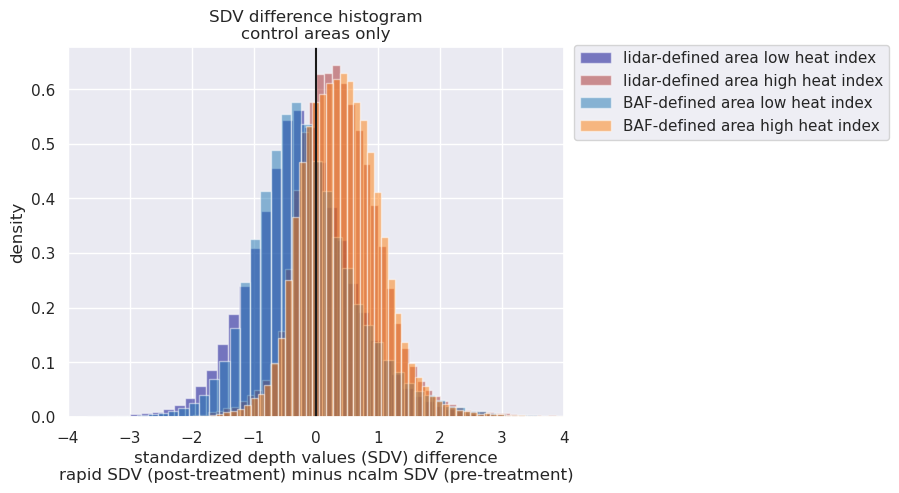

In [121]:
ds['diff_sdv_rapid_ncalm_lidar'].where(ds['lidar_nocanopychange_dahneg'].notnull()).plot.hist(color='darkblue', bins=100, alpha=0.5, density=True, label='lidar-defined area low heat index');
ds['diff_sdv_rapid_ncalm_lidar'].where(ds['lidar_nocanopychange_dahpos'].notnull()).plot.hist(color='brown', bins=100, alpha=0.5, density=True, label='lidar-defined area high heat index');
ds['diff_sdv_rapid_ncalm_baf'].where(ds['baf_nocanopychange_dahneg'].notnull()).plot.hist(color='tab:blue', bins=100, alpha=0.5, density=True, label='BAF-defined area low heat index');
ds['diff_sdv_rapid_ncalm_baf'].where(ds['baf_nocanopychange_dahpos'].notnull()).plot.hist(color='tab:orange', bins=100, alpha=0.5, density=True, label='BAF-defined area high heat index');


plt.xlim(-4,4);
plt.legend(loc=(1.02,.75));
plt.axvline(0,c='k')
plt.ylabel('density')
plt.xlabel('standardized depth values (SDV) difference\nrapid SDV (post-treatment) minus ncalm SDV (pre-treatment)')
plt.title('SDV difference histogram\ncontrol areas only');
# plt.title('SDV difference histogram for "control" areas only\n(SDV computed with lidar-derived control areas)');


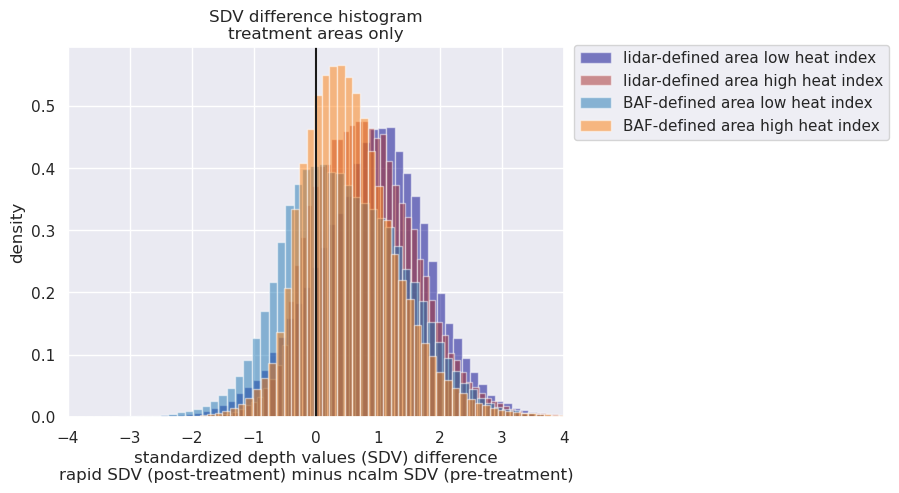

In [122]:
ds['diff_sdv_rapid_ncalm_lidar'].where(ds['lidar_canopychange_dahneg'].notnull()).plot.hist(color='darkblue', bins=100, alpha=0.5, density=True, label='lidar-defined area low heat index');
ds['diff_sdv_rapid_ncalm_lidar'].where(ds['lidar_canopychange_dahpos'].notnull()).plot.hist(color='brown', bins=100, alpha=0.5, density=True, label='lidar-defined area high heat index');
ds['diff_sdv_rapid_ncalm_baf'].where(ds['baf_canopychange_dahneg'].notnull()).plot.hist(color='tab:blue', bins=100, alpha=0.5, density=True, label='BAF-defined area low heat index');
ds['diff_sdv_rapid_ncalm_baf'].where(ds['baf_canopychange_dahpos'].notnull()).plot.hist(color='tab:orange', bins=100, alpha=0.5, density=True, label='BAF-defined area high heat index');


plt.xlim(-4,4);
plt.legend(loc=(1.02,.75));
plt.axvline(0,c='k')
plt.ylabel('density')
plt.xlabel('standardized depth values (SDV) difference\nrapid SDV (post-treatment) minus ncalm SDV (pre-treatment)')
plt.title('SDV difference histogram\ntreatment areas only');
# plt.title('SDV difference histogram for "control" areas only\n(SDV computed with lidar-derived control areas)');


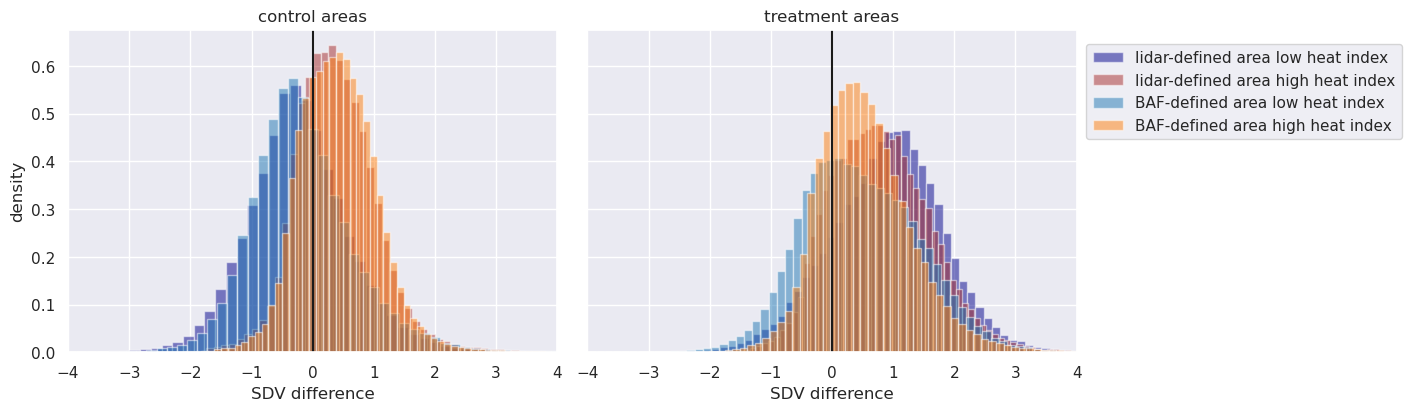

In [123]:
# make this subplots with control on the left, and treatment on the right 
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(14,4), constrained_layout = True)

ds['diff_sdv_rapid_ncalm_lidar'].where(ds['lidar_nocanopychange_dahneg'].notnull()).plot.hist(ax=axes[0], color='darkblue', bins=100, alpha=0.5, density=True, label='lidar-defined area low heat index');
ds['diff_sdv_rapid_ncalm_lidar'].where(ds['lidar_nocanopychange_dahpos'].notnull()).plot.hist(ax=axes[0], color='brown', bins=100, alpha=0.5, density=True, label='lidar-defined area high heat index');
ds['diff_sdv_rapid_ncalm_baf'].where(ds['baf_nocanopychange_dahneg'].notnull()).plot.hist(ax=axes[0], color='tab:blue', bins=100, alpha=0.5, density=True, label='BAF-defined area low heat index');
ds['diff_sdv_rapid_ncalm_baf'].where(ds['baf_nocanopychange_dahpos'].notnull()).plot.hist(ax=axes[0], color='tab:orange', bins=100, alpha=0.5, density=True, label='BAF-defined area high heat index');

ds['diff_sdv_rapid_ncalm_lidar'].where(ds['lidar_canopychange_dahneg'].notnull()).plot.hist(ax=axes[1], color='darkblue', bins=100, alpha=0.5, density=True, label='lidar-defined area low heat index');
ds['diff_sdv_rapid_ncalm_lidar'].where(ds['lidar_canopychange_dahpos'].notnull()).plot.hist(ax=axes[1], color='brown', bins=100, alpha=0.5, density=True, label='lidar-defined area high heat index');
ds['diff_sdv_rapid_ncalm_baf'].where(ds['baf_canopychange_dahneg'].notnull()).plot.hist(ax=axes[1], color='tab:blue', bins=100, alpha=0.5, density=True, label='BAF-defined area low heat index');
ds['diff_sdv_rapid_ncalm_baf'].where(ds['baf_canopychange_dahpos'].notnull()).plot.hist(ax=axes[1], color='tab:orange', bins=100, alpha=0.5, density=True, label='BAF-defined area high heat index');

# plot a vertical line at zero
axes[0].axvline(0,c='k')
axes[1].axvline(0,c='k')

plt.xlim(-4,4);
plt.legend(loc=(1.02,.66));

axes[0].set_ylabel('density')

# plt.xlabel('standardized depth values (SDV) difference\nrapid SDV (post-treatment) minus ncalm SDV (pre-treatment)')
axes[0].set_xlabel('SDV difference') 
axes[1].set_xlabel('SDV difference')

# plt.suptitle('SDV difference histogram')
# adjust the location of the suptitle to the left 
axes[0].set_title('control areas')
axes[1].set_title('treatment areas');

plt.show()

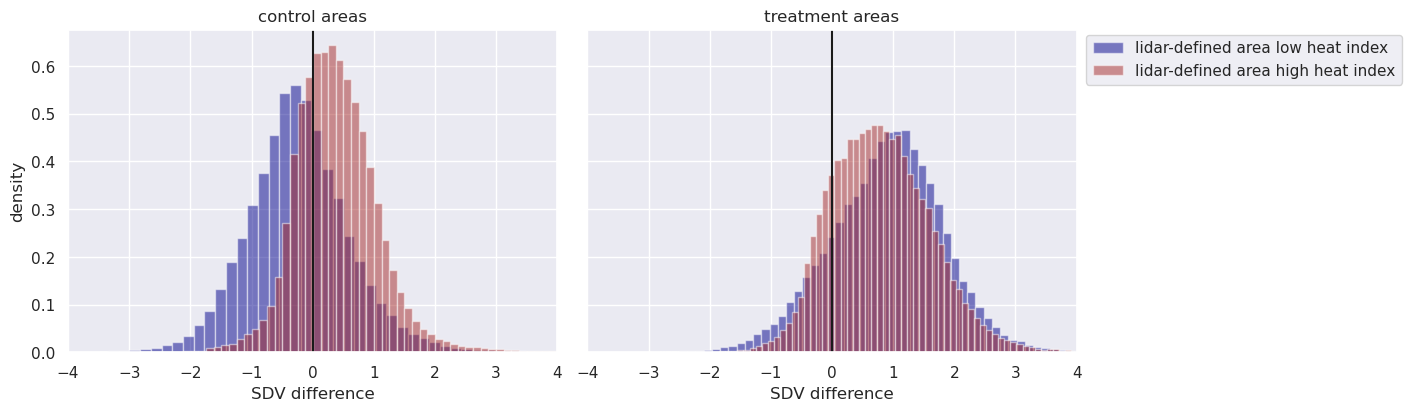

In [124]:
# make this subplots with control on the left, and treatment on the right 
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(14,4), constrained_layout = True)

ds['diff_sdv_rapid_ncalm_lidar'].where(ds['lidar_nocanopychange_dahneg'].notnull()).plot.hist(ax=axes[0], color='darkblue', bins=100, alpha=0.5, density=True, label='lidar-defined area low heat index');
ds['diff_sdv_rapid_ncalm_lidar'].where(ds['lidar_nocanopychange_dahpos'].notnull()).plot.hist(ax=axes[0], color='brown', bins=100, alpha=0.5, density=True, label='lidar-defined area high heat index');
# ds['diff_sdv_rapid_ncalm_baf'].where(ds['baf_nocanopychange_dahneg'].notnull()).plot.hist(ax=axes[0], color='tab:blue', bins=100, alpha=0.5, density=True, label='BAF-defined area low heat index');
# ds['diff_sdv_rapid_ncalm_baf'].where(ds['baf_nocanopychange_dahpos'].notnull()).plot.hist(ax=axes[0], color='tab:orange', bins=100, alpha=0.5, density=True, label='BAF-defined area high heat index');

ds['diff_sdv_rapid_ncalm_lidar'].where(ds['lidar_canopychange_dahneg'].notnull()).plot.hist(ax=axes[1], color='darkblue', bins=100, alpha=0.5, density=True, label='lidar-defined area low heat index');
ds['diff_sdv_rapid_ncalm_lidar'].where(ds['lidar_canopychange_dahpos'].notnull()).plot.hist(ax=axes[1], color='brown', bins=100, alpha=0.5, density=True, label='lidar-defined area high heat index');
# ds['diff_sdv_rapid_ncalm_baf'].where(ds['baf_canopychange_dahneg'].notnull()).plot.hist(ax=axes[1], color='tab:blue', bins=100, alpha=0.5, density=True, label='BAF-defined area low heat index');
# ds['diff_sdv_rapid_ncalm_baf'].where(ds['baf_canopychange_dahpos'].notnull()).plot.hist(ax=axes[1], color='tab:orange', bins=100, alpha=0.5, density=True, label='BAF-defined area high heat index');

# plot a vertical line at zero
axes[0].axvline(0,c='k')
axes[1].axvline(0,c='k')

plt.xlim(-4,4);
plt.legend(loc=(1.02,.83));

axes[0].set_ylabel('density')

# plt.xlabel('standardized depth values (SDV) difference\nrapid SDV (post-treatment) minus ncalm SDV (pre-treatment)')
axes[0].set_xlabel('SDV difference') 
axes[1].set_xlabel('SDV difference')

# plt.suptitle('SDV difference histogram')
# adjust the location of the suptitle to the left 
axes[0].set_title('control areas')
axes[1].set_title('treatment areas');

plt.show()

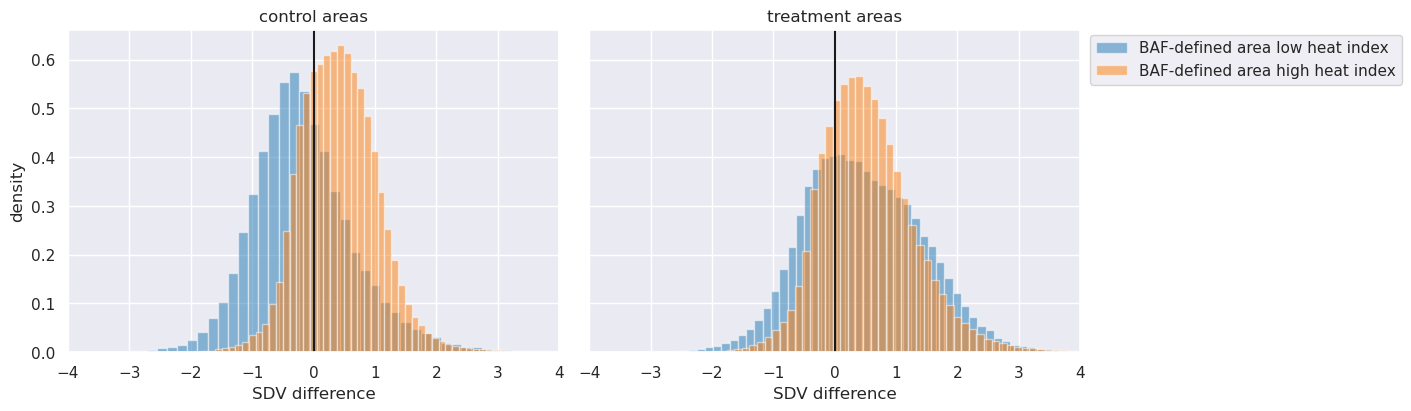

In [125]:
# make this subplots with control on the left, and treatment on the right 
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(14,4), constrained_layout = True)

# ds['diff_sdv_rapid_ncalm_lidar'].where(ds['lidar_nocanopychange_dahneg'].notnull()).plot.hist(ax=axes[0], color='darkblue', bins=100, alpha=0.5, density=True, label='lidar-defined area low heat index');
# ds['diff_sdv_rapid_ncalm_lidar'].where(ds['lidar_nocanopychange_dahpos'].notnull()).plot.hist(ax=axes[0], color='brown', bins=100, alpha=0.5, density=True, label='lidar-defined area high heat index');
ds['diff_sdv_rapid_ncalm_baf'].where(ds['baf_nocanopychange_dahneg'].notnull()).plot.hist(ax=axes[0], color='tab:blue', bins=100, alpha=0.5, density=True, label='BAF-defined area low heat index');
ds['diff_sdv_rapid_ncalm_baf'].where(ds['baf_nocanopychange_dahpos'].notnull()).plot.hist(ax=axes[0], color='tab:orange', bins=100, alpha=0.5, density=True, label='BAF-defined area high heat index');

# ds['diff_sdv_rapid_ncalm_lidar'].where(ds['lidar_canopychange_dahneg'].notnull()).plot.hist(ax=axes[1], color='darkblue', bins=100, alpha=0.5, density=True, label='lidar-defined area low heat index');
# ds['diff_sdv_rapid_ncalm_lidar'].where(ds['lidar_canopychange_dahpos'].notnull()).plot.hist(ax=axes[1], color='brown', bins=100, alpha=0.5, density=True, label='lidar-defined area high heat index');
ds['diff_sdv_rapid_ncalm_baf'].where(ds['baf_canopychange_dahneg'].notnull()).plot.hist(ax=axes[1], color='tab:blue', bins=100, alpha=0.5, density=True, label='BAF-defined area low heat index');
ds['diff_sdv_rapid_ncalm_baf'].where(ds['baf_canopychange_dahpos'].notnull()).plot.hist(ax=axes[1], color='tab:orange', bins=100, alpha=0.5, density=True, label='BAF-defined area high heat index');

# plot a vertical line at zero
axes[0].axvline(0,c='k')
axes[1].axvline(0,c='k')

plt.xlim(-4,4);
plt.legend(loc=(1.02,.83));

axes[0].set_ylabel('density')

# plt.xlabel('standardized depth values (SDV) difference\nrapid SDV (post-treatment) minus ncalm SDV (pre-treatment)')
axes[0].set_xlabel('SDV difference') 
axes[1].set_xlabel('SDV difference')

# plt.suptitle('SDV difference histogram')
# adjust the location of the suptitle to the left 
axes[0].set_title('control areas')
axes[1].set_title('treatment areas');

plt.show()

Let's focus on just the lidar defined areas for now

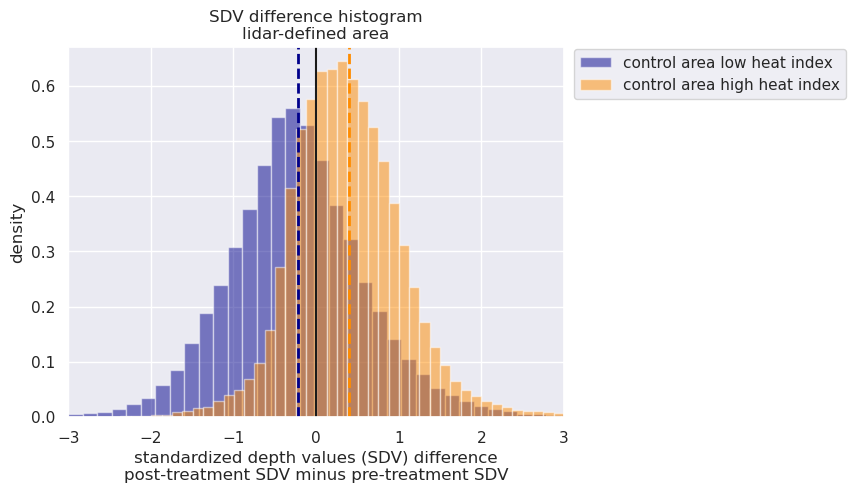

In [126]:
ds['diff_sdv_rapid_ncalm_lidar'].where(ds['lidar_nocanopychange_dahneg'].notnull()).plot.hist(color='darkblue', bins=100, alpha=0.5, density=True, label='control area low heat index');
ds['diff_sdv_rapid_ncalm_lidar'].where(ds['lidar_nocanopychange_dahpos'].notnull()).plot.hist(color='darkorange', bins=100, alpha=0.5, density=True, label='control area high heat index');

# ds['diff_sdv_rapid_ncalm_lidar'].where(ds['lidar_canopychange_dahneg'].notnull()).plot.hist(color='darkblue', bins=100, alpha=0.8, density=True, label='treatment area low heat index');
# ds['diff_sdv_rapid_ncalm_lidar'].where(ds['lidar_canopychange_dahpos'].notnull()).plot.hist(color='darkorange', bins=100, alpha=0.8, density=True, label='treatment area high heat index');

# plot all the mean lines 
width=2
plt.axvline(ds['diff_sdv_rapid_ncalm_lidar'].where(ds['lidar_nocanopychange_dahneg'].notnull()).mean(), color='darkblue', linestyle='dashed', linewidth=width)
plt.axvline(ds['diff_sdv_rapid_ncalm_lidar'].where(ds['lidar_nocanopychange_dahpos'].notnull()).mean(), color='darkorange', linestyle='dashed', linewidth=width)
# plt.axvline(ds['diff_sdv_rapid_ncalm_lidar'].where(ds['lidar_canopychange_dahneg'].notnull()).mean(), color='darkblue', linestyle='dashed', linewidth=width)
# plt.axvline(ds['diff_sdv_rapid_ncalm_lidar'].where(ds['lidar_canopychange_dahpos'].notnull()).mean(), color='darkorange', linestyle='dashed', linewidth=width)

# constants
plt.ylim(0, 0.67)
plt.xlim(-3,3);
plt.legend(loc=(1.02,.86));
plt.axvline(0,c='k')
plt.ylabel('density')
# plt.xlabel('standardized depth values (SDV) difference\nrapid SDV (post-treatment) minus ncalm SDV (pre-treatment)')
plt.xlabel('standardized depth values (SDV) difference\npost-treatment SDV minus pre-treatment SDV')

plt.title('SDV difference histogram\nlidar-defined area');
# plt.title('SDV difference histogram for "control" areas only\n(SDV computed with lidar-derived control areas)');


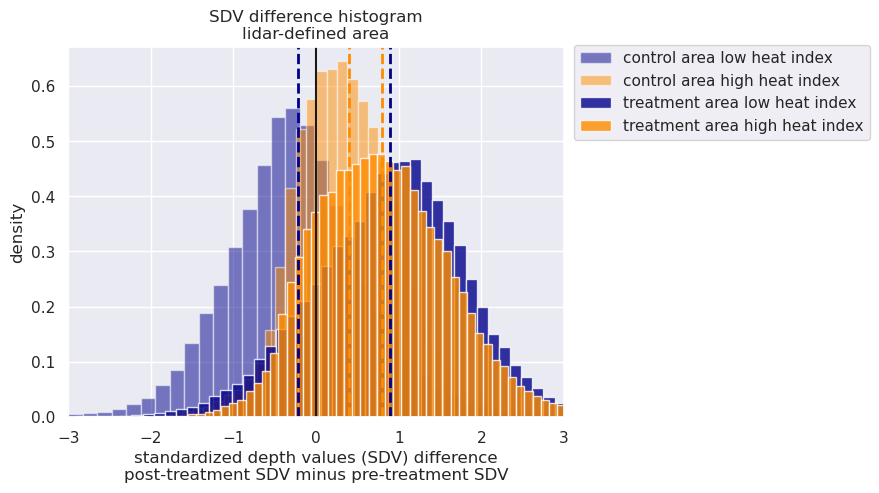

In [127]:
ds['diff_sdv_rapid_ncalm_lidar'].where(ds['lidar_nocanopychange_dahneg'].notnull()).plot.hist(color='darkblue', bins=100, alpha=0.5, density=True, label='control area low heat index');
ds['diff_sdv_rapid_ncalm_lidar'].where(ds['lidar_nocanopychange_dahpos'].notnull()).plot.hist(color='darkorange', bins=100, alpha=0.5, density=True, label='control area high heat index');

ds['diff_sdv_rapid_ncalm_lidar'].where(ds['lidar_canopychange_dahneg'].notnull()).plot.hist(color='darkblue', bins=100, alpha=0.8, density=True, label='treatment area low heat index');
ds['diff_sdv_rapid_ncalm_lidar'].where(ds['lidar_canopychange_dahpos'].notnull()).plot.hist(color='darkorange', bins=100, alpha=0.8, density=True, label='treatment area high heat index');

# plot all the mean lines 
width=2
plt.axvline(ds['diff_sdv_rapid_ncalm_lidar'].where(ds['lidar_nocanopychange_dahneg'].notnull()).mean(), color='darkblue', linestyle='dashed', linewidth=width)
plt.axvline(ds['diff_sdv_rapid_ncalm_lidar'].where(ds['lidar_nocanopychange_dahpos'].notnull()).mean(), color='darkorange', linestyle='dashed', linewidth=width)
plt.axvline(ds['diff_sdv_rapid_ncalm_lidar'].where(ds['lidar_canopychange_dahneg'].notnull()).mean(), color='darkblue', linestyle='dashed', linewidth=width)
plt.axvline(ds['diff_sdv_rapid_ncalm_lidar'].where(ds['lidar_canopychange_dahpos'].notnull()).mean(), color='darkorange', linestyle='dashed', linewidth=width)

# constants
plt.ylim(0, 0.67)
plt.xlim(-3,3);
plt.legend(loc=(1.02,.75));
plt.axvline(0,c='k')
plt.ylabel('density')
# plt.xlabel('standardized depth values (SDV) difference\nrapid SDV (post-treatment) minus ncalm SDV (pre-treatment)')
plt.xlabel('standardized depth values (SDV) difference\npost-treatment SDV minus pre-treatment SDV')

plt.title('SDV difference histogram\nlidar-defined area');
# plt.title('SDV difference histogram for "control" areas only\n(SDV computed with lidar-derived control areas)');


Print the median values, 

In [147]:
print("SDV diff median control", ds['diff_sdv_rapid_ncalm_lidar'].where(select_lidar_nocanopychange).median().values)
print("SDV diff median treatments", ds['diff_sdv_rapid_ncalm_lidar'].where(~select_lidar_nocanopychange).median().values)

print("SDV diff median control high heat", ds['diff_sdv_rapid_ncalm_lidar'].where(ds['lidar_nocanopychange_dahpos'].notnull()).median().values)
print("SDV diff median control low heat", ds['diff_sdv_rapid_ncalm_lidar'].where(ds['lidar_nocanopychange_dahneg'].notnull()).median().values)

print("SDV diff median treatment high heat",  ds['diff_sdv_rapid_ncalm_lidar'].where(ds['lidar_canopychange_dahpos'].notnull()).median().values)
print("SDV diff median treatment low heat",  ds['diff_sdv_rapid_ncalm_lidar'].where(ds['lidar_canopychange_dahneg'].notnull()).median().values)

SDV diff median control 0.10316113
SDV diff median treatments 0.45457423
SDV diff median control high heat 0.3413216
SDV diff median control low heat -0.25672412
SDV diff median treatment high heat 0.7514348
SDV diff median treatment low heat 0.93970454


In [148]:
print("SDV diff std control", ds['diff_sdv_rapid_ncalm_lidar'].where(select_lidar_nocanopychange).std().values)
print("SDV diff std treatments", ds['diff_sdv_rapid_ncalm_lidar'].where(~select_lidar_nocanopychange).std().values)

print("SDV diff std control high heat", ds['diff_sdv_rapid_ncalm_lidar'].where(ds['lidar_nocanopychange_dahpos'].notnull()).std().values)
print("SDV diff std control low heat", ds['diff_sdv_rapid_ncalm_lidar'].where(ds['lidar_nocanopychange_dahneg'].notnull()).std().values)

print("SDV diff std treatment high heat",  ds['diff_sdv_rapid_ncalm_lidar'].where(ds['lidar_canopychange_dahpos'].notnull()).std().values)
print("SDV diff std treatment low heat",  ds['diff_sdv_rapid_ncalm_lidar'].where(ds['lidar_canopychange_dahneg'].notnull()).std().values)

SDV diff std control 0.85067105
SDV diff std treatments 0.95766234
SDV diff std control high heat 0.7254434
SDV diff std control low heat 0.8670376
SDV diff std treatment high heat 0.82003313
SDV diff std treatment low heat 0.9307904


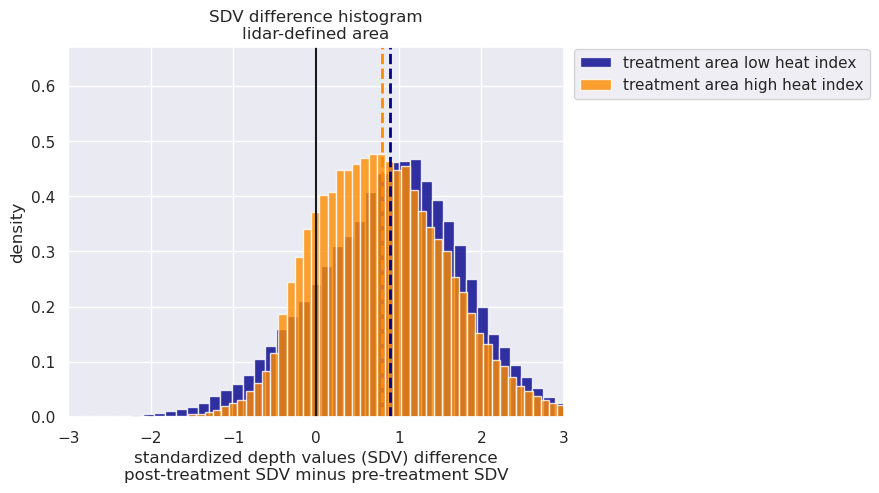

In [128]:
# ds['diff_sdv_rapid_ncalm_lidar'].where(ds['lidar_nocanopychange_dahneg'].notnull()).plot.hist(color='darkblue', bins=100, alpha=0.5, density=True, label='control area low heat index');
# ds['diff_sdv_rapid_ncalm_lidar'].where(ds['lidar_nocanopychange_dahpos'].notnull()).plot.hist(color='darkorange', bins=100, alpha=0.5, density=True, label='control area high heat index');

ds['diff_sdv_rapid_ncalm_lidar'].where(ds['lidar_canopychange_dahneg'].notnull()).plot.hist(color='darkblue', bins=100, alpha=0.8, density=True, label='treatment area low heat index');
ds['diff_sdv_rapid_ncalm_lidar'].where(ds['lidar_canopychange_dahpos'].notnull()).plot.hist(color='darkorange', bins=100, alpha=0.8, density=True, label='treatment area high heat index');

# plot all the mean lines 
width=2
# plt.axvline(ds['diff_sdv_rapid_ncalm_lidar'].where(ds['lidar_nocanopychange_dahneg'].notnull()).mean(), color='darkblue', linestyle='dashed', linewidth=width)
# plt.axvline(ds['diff_sdv_rapid_ncalm_lidar'].where(ds['lidar_nocanopychange_dahpos'].notnull()).mean(), color='darkorange', linestyle='dashed', linewidth=width)
plt.axvline(ds['diff_sdv_rapid_ncalm_lidar'].where(ds['lidar_canopychange_dahneg'].notnull()).mean(), color='darkblue', linestyle='dashed', linewidth=width)
plt.axvline(ds['diff_sdv_rapid_ncalm_lidar'].where(ds['lidar_canopychange_dahpos'].notnull()).mean(), color='darkorange', linestyle='dashed', linewidth=width)

# constants
plt.ylim(0, 0.67)
plt.xlim(-3,3);
plt.legend(loc=(1.02,.86));
plt.axvline(0,c='k')
plt.ylabel('density')
# plt.xlabel('standardized depth values (SDV) difference\nrapid SDV (post-treatment) minus ncalm SDV (pre-treatment)')
plt.xlabel('standardized depth values (SDV) difference\npost-treatment SDV minus pre-treatment SDV')

plt.title('SDV difference histogram\nlidar-defined area');
# plt.title('SDV difference histogram for "control" areas only\n(SDV computed with lidar-derived control areas)');


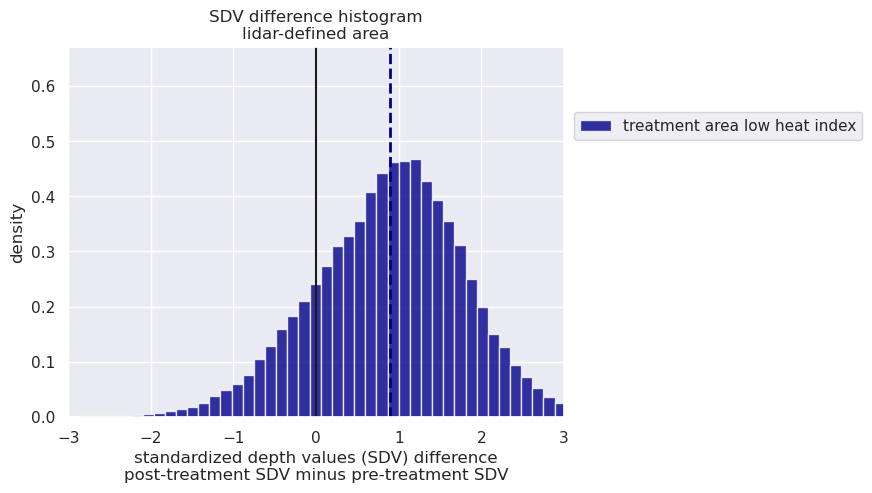

In [129]:
# ds['diff_sdv_rapid_ncalm_lidar'].where(ds['lidar_nocanopychange_dahneg'].notnull()).plot.hist(color='darkblue', bins=100, alpha=0.5, density=True, label='control area low heat index');
# ds['diff_sdv_rapid_ncalm_lidar'].where(ds['lidar_nocanopychange_dahpos'].notnull()).plot.hist(color='darkorange', bins=100, alpha=0.5, density=True, label='control area high heat index');

ds['diff_sdv_rapid_ncalm_lidar'].where(ds['lidar_canopychange_dahneg'].notnull()).plot.hist(color='darkblue', bins=100, alpha=0.8, density=True, label='treatment area low heat index');
# ds['diff_sdv_rapid_ncalm_lidar'].where(ds['lidar_canopychange_dahpos'].notnull()).plot.hist(color='darkorange', bins=100, alpha=0.8, density=True, label='treatment area high heat index');

# plot all the mean lines 
width=2
# plt.axvline(ds['diff_sdv_rapid_ncalm_lidar'].where(ds['lidar_nocanopychange_dahneg'].notnull()).mean(), color='darkblue', linestyle='dashed', linewidth=width)
# plt.axvline(ds['diff_sdv_rapid_ncalm_lidar'].where(ds['lidar_nocanopychange_dahpos'].notnull()).mean(), color='darkorange', linestyle='dashed', linewidth=width)
plt.axvline(ds['diff_sdv_rapid_ncalm_lidar'].where(ds['lidar_canopychange_dahneg'].notnull()).mean(), color='darkblue', linestyle='dashed', linewidth=width)
# plt.axvline(ds['diff_sdv_rapid_ncalm_lidar'].where(ds['lidar_canopychange_dahpos'].notnull()).mean(), color='darkorange', linestyle='dashed', linewidth=width)

# constants
plt.ylim(0, 0.67)
plt.xlim(-3,3);
plt.legend(loc=(1.02,.75));
plt.axvline(0,c='k')
plt.ylabel('density')
# plt.xlabel('standardized depth values (SDV) difference\nrapid SDV (post-treatment) minus ncalm SDV (pre-treatment)')
plt.xlabel('standardized depth values (SDV) difference\npost-treatment SDV minus pre-treatment SDV')

plt.title('SDV difference histogram\nlidar-defined area');
# plt.title('SDV difference histogram for "control" areas only\n(SDV computed with lidar-derived control areas)');


Changes below made for manuscript figure shapes

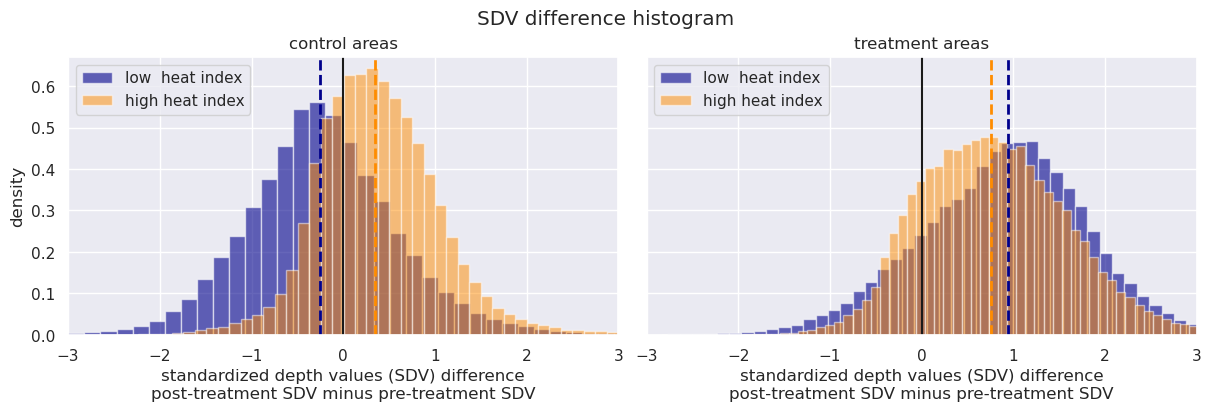

In [130]:
# make this subplots with control on the left, and treatment on the right 
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12,4), constrained_layout = True)

ds['diff_sdv_rapid_ncalm_lidar'].where(ds['lidar_nocanopychange_dahneg'].notnull()).plot.hist(ax=axes[0], color='darkblue', bins=100, alpha=0.6, density=True,   label='low  heat index');
ds['diff_sdv_rapid_ncalm_lidar'].where(ds['lidar_nocanopychange_dahpos'].notnull()).plot.hist(ax=axes[0], color='darkorange', bins=100, alpha=0.5, density=True, label='high heat index');

ds['diff_sdv_rapid_ncalm_lidar'].where(ds['lidar_canopychange_dahneg'].notnull()).plot.hist(ax=axes[1], color='darkblue', bins=100, alpha=0.6, density=True,   label='low  heat index');
ds['diff_sdv_rapid_ncalm_lidar'].where(ds['lidar_canopychange_dahpos'].notnull()).plot.hist(ax=axes[1], color='darkorange', bins=100, alpha=0.5, density=True, label='high heat index');

# plot the median lines for each variable 
width=2
axes[0].axvline(ds['diff_sdv_rapid_ncalm_lidar'].where(ds['lidar_nocanopychange_dahneg'].notnull()).median(), color='darkblue', linestyle='dashed', linewidth=width)
axes[0].axvline(ds['diff_sdv_rapid_ncalm_lidar'].where(ds['lidar_nocanopychange_dahpos'].notnull()).median(), color='darkorange', linestyle='dashed', linewidth=width)
axes[1].axvline(ds['diff_sdv_rapid_ncalm_lidar'].where(ds['lidar_canopychange_dahneg'].notnull()).median(), color='darkblue', linestyle='dashed', linewidth=width)
axes[1].axvline(ds['diff_sdv_rapid_ncalm_lidar'].where(ds['lidar_canopychange_dahpos'].notnull()).median(), color='darkorange', linestyle='dashed', linewidth=width)


# plot a vertical line at zero
axes[0].axvline(0,c='k')
axes[1].axvline(0,c='k')

plt.ylim(0, 0.67)
plt.xlim(-3,3);
# plt.legend(loc=(1.02,.84));
axes[0].legend(loc='upper left')
axes[1].legend(loc='upper left')

axes[0].set_ylabel('density')

plt.suptitle('SDV difference histogram')
# center the suptitle over the plots and not the legend 
# plt.subplots_adjust(top=0.0)
axes[0].set_xlabel('standardized depth values (SDV) difference\npost-treatment SDV minus pre-treatment SDV')
# axes[0].xaxis.set_label_coords(-0.1, 0)
axes[1].set_xlabel('standardized depth values (SDV) difference\npost-treatment SDV minus pre-treatment SDV')
# axes[0].set_xlabel('SDV difference') 
# axes[1].set_xlabel('SDV difference')

axes[0].set_title('control areas')
axes[1].set_title('treatment areas');

plt.show()

Same plot, but put the lows together and highs together

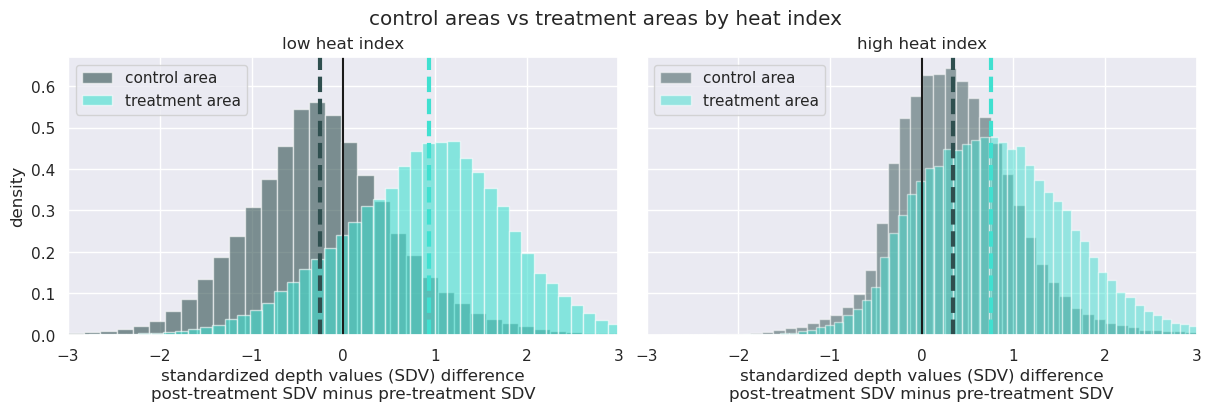

In [131]:
# make this subplots with control on the left, and treatment on the right 
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12,4), constrained_layout = True)

ds['diff_sdv_rapid_ncalm_lidar'].where(ds['lidar_nocanopychange_dahneg'].notnull()).plot.hist(ax=axes[0], color='darkslategrey', bins=100, alpha=0.6, density=True,   label='control area');
ds['diff_sdv_rapid_ncalm_lidar'].where(ds['lidar_nocanopychange_dahpos'].notnull()).plot.hist(ax=axes[1], color='darkslategrey', bins=100, alpha=0.5, density=True, label='control area');

ds['diff_sdv_rapid_ncalm_lidar'].where(ds['lidar_canopychange_dahneg'].notnull()).plot.hist(ax=axes[0], color='turquoise', bins=100, alpha=0.6, density=True,   label='treatment area');
ds['diff_sdv_rapid_ncalm_lidar'].where(ds['lidar_canopychange_dahpos'].notnull()).plot.hist(ax=axes[1], color='turquoise', bins=100, alpha=0.5, density=True, label='treatment area');

# plot the median lines for each variable 
width=3
axes[0].axvline(ds['diff_sdv_rapid_ncalm_lidar'].where(ds['lidar_nocanopychange_dahneg'].notnull()).median(), color='darkslategrey', linestyle='dashed', linewidth=width)
axes[1].axvline(ds['diff_sdv_rapid_ncalm_lidar'].where(ds['lidar_nocanopychange_dahpos'].notnull()).median(), color='darkslategrey', linestyle='dashed', linewidth=width)
axes[0].axvline(ds['diff_sdv_rapid_ncalm_lidar'].where(ds['lidar_canopychange_dahneg'].notnull()).median(), color='turquoise', linestyle='dashed', linewidth=width)
axes[1].axvline(ds['diff_sdv_rapid_ncalm_lidar'].where(ds['lidar_canopychange_dahpos'].notnull()).median(), color='turquoise', linestyle='dashed', linewidth=width)


# plot a vertical line at zero
axes[0].axvline(0,c='k')
axes[1].axvline(0,c='k')

plt.ylim(0, 0.67)
plt.xlim(-3,3);
# plt.legend(loc=(1.02,.84));
axes[0].legend(loc='upper left')
axes[1].legend(loc='upper left')

axes[0].set_ylabel('density')

plt.suptitle('control areas vs treatment areas by heat index')
# center the suptitle over the plots and not the legend 
# plt.subplots_adjust(top=0.0)
axes[0].set_xlabel('standardized depth values (SDV) difference\npost-treatment SDV minus pre-treatment SDV')
# axes[0].xaxis.set_label_coords(-0.1, 0)
axes[1].set_xlabel('standardized depth values (SDV) difference\npost-treatment SDV minus pre-treatment SDV')
# axes[0].set_xlabel('SDV difference') 
# axes[1].set_xlabel('SDV difference')

axes[0].set_title('low heat index')
axes[1].set_title('high heat index');

plt.show()

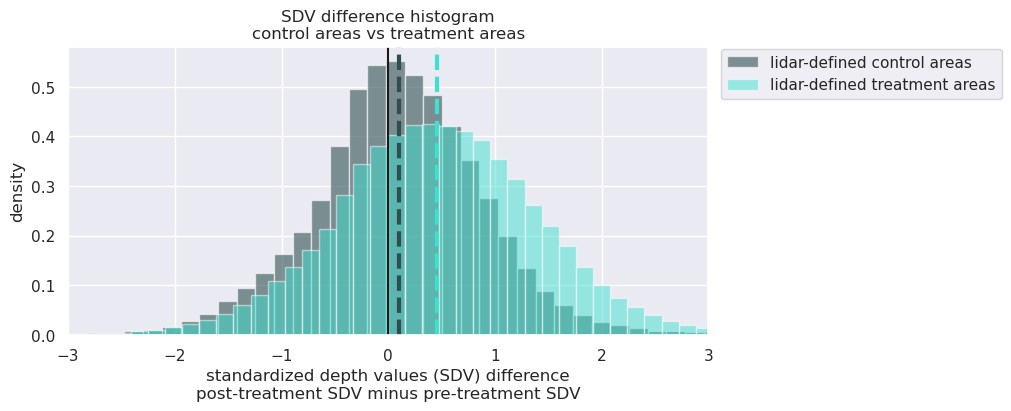

In [132]:
# colors for change and no change, making them completly different colors to not be confused with the other plots 
# define the figure size
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(10,4), constrained_layout = True)

# cmap=ListedColormap(['darkslategrey','turquoise']
ds['diff_sdv_rapid_ncalm_lidar'].where(select_lidar_nocanopychange).plot.hist(bins=100, color='darkslategrey', alpha=0.6, density=True, label='lidar-defined control areas');
# ds['diff_sdv_rapid_ncalm_baf'].where(select_baf_nocanopychange).plot.hist(bins=100, color='darkslategrey', alpha=0.5, density=True, label='BAF-defined control areas');
ds['diff_sdv_rapid_ncalm_lidar'].where(~select_lidar_nocanopychange).plot.hist(bins=100, color='turquoise',alpha=0.5, density=True, label='lidar-defined treatment areas');
# ds['diff_sdv_rapid_ncalm_baf'].where(~select_baf_nocanopychange).plot.hist(bins=100, color='turquoise',alpha=0.5, density=True, label='BAF-defined treatment areas');

# plot median lines for all of those histograms
width=3
# plt.axvline(ds['diff_sdv_rapid_ncalm_lidar'].where(select_lidar_nocanopychange).median(), color='darkslategrey', linestyle='dashed', linewidth=width)
# # plt.axvline(ds['diff_sdv_rapid_ncalm_baf'].where(select_baf_nocanopychange).median(), color='darkslategrey', linestyle='solid', linewidth=width)
# plt.axvline(ds['diff_sdv_rapid_ncalm_lidar'].where(~select_lidar_nocanopychange).median(), color='turquoise', linestyle='dashed', linewidth=width)
# # plt.axvline(ds['diff_sdv_rapid_ncalm_baf'].where(~select_baf_nocanopychange).median(), color='turquoise', linestyle='solid', linewidth=width)

plt.axvline(ds['diff_sdv_rapid_ncalm_lidar'].where(select_lidar_nocanopychange).median(), color='darkslategrey', linestyle='dashed', linewidth=width)
# plt.axvline(ds['diff_sdv_rapid_ncalm_baf'].where(select_baf_nocanopychange).mean(), color='darkslategrey', linestyle='solid', linewidth=width)
plt.axvline(ds['diff_sdv_rapid_ncalm_lidar'].where(~select_lidar_nocanopychange).median(), color='turquoise', linestyle='dashed', linewidth=width)
# plt.axvline(ds['diff_sdv_rapid_ncalm_baf'].where(~select_baf_nocanopychange).mean(), color='turquoise', linestyle='solid', linewidth=width)

plt.xlim(-3,3);
plt.legend(loc=(1.02,.82));
plt.axvline(0,c='k')
plt.ylabel('density')
# plt.xlabel('standardized depth values (SDV) difference\nrapid SDV (post-treatment) minus ncalm SDV (pre-treatment)')
plt.xlabel('standardized depth values (SDV) difference\npost-treatment SDV minus pre-treatment SDV')

plt.title('SDV difference histogram\ncontrol areas vs treatment areas');
# plt.title('SDV difference histogram for "canopy change" areas only');

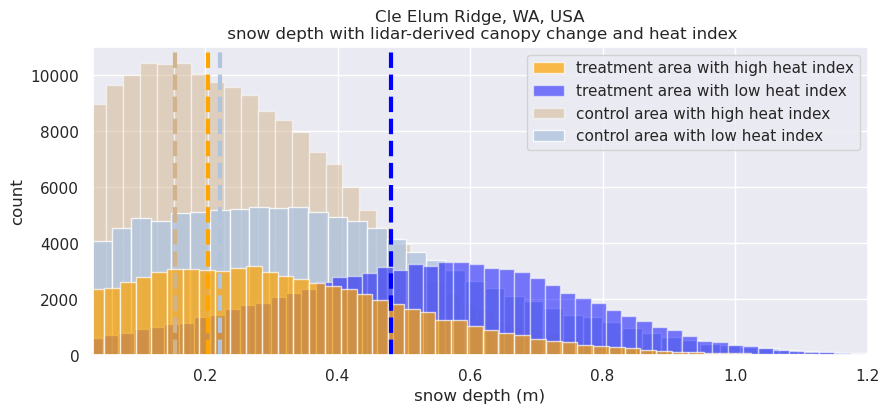

In [152]:
# plot histograms of the four groups 
fig, axes = plt.subplots(1, 1, figsize=(10,4))

p1 = ds['hs_lidar_nocanopychange_dahpos'].plot.hist(bins=100, label='control area with high heat index', alpha=.5, color='tan')
p2 = ds['hs_lidar_nocanopychange_dahneg'].plot.hist(bins=100, label='control area with low heat index', alpha=.8, color='lightsteelblue')

p4 = ds['hs_lidar_canopychange_dahneg'].plot.hist(bins=100, label='treatment area with low heat index', alpha=.5, color='blue')
p3 = ds['hs_lidar_canopychange_dahpos'].plot.hist(bins=100, label='treatment area with high heat index', alpha=.7, color='orange')

# plot the median lines for the histograms\
width=3
plt.axvline(ds['hs_lidar_nocanopychange_dahneg'].median(), color='lightsteelblue', linestyle='dashed', linewidth=width)
plt.axvline(ds['hs_lidar_nocanopychange_dahpos'].median(), color='tan', linestyle='dashed', linewidth=width)
plt.axvline(ds['hs_lidar_canopychange_dahneg'].median(), color='blue', linestyle='dashed', linewidth=width)
plt.axvline(ds['hs_lidar_canopychange_dahpos'].median(), color='orange', linestyle='dashed', linewidth=width)

# legend order
handles, labels = plt.gca().get_legend_handles_labels()
order=[3,2,0,1]
# order=[2,3,1,0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])

# constants
plt.title('Cle Elum Ridge, WA, USA\n snow depth with lidar-derived canopy change and heat index')
plt.xlabel('snow depth (m)')
plt.ylabel('count')

plt.xlim(0.03,1.2)
plt.ylim(0,11000)
plt.show()

We need to mkae all of the groups seperate variables to plot them in histograms together

In [54]:
# RAPID
# 'sdv_rapid' , 'sdv_rapid_lidar', 'sdv_rapid_baf'
# now, save snow depth as a variable for each of those conditions, where the values are not null
ds['sdv_rapid_lidar_canopychange_dahneg'] = ds['sdv_rapid_lidar'].where(ds['lidar_canopychange_dahneg'].notnull())
ds['sdv_rapid_lidar_canopychange_dahpos'] = ds['sdv_rapid_lidar'].where(ds['lidar_canopychange_dahpos'].notnull())
ds['sdv_rapid_lidar_nocanopychange_dahneg'] = ds['sdv_rapid_lidar'].where(ds['lidar_nocanopychange_dahneg'].notnull())
ds['sdv_rapid_lidar_nocanopychange_dahpos'] = ds['sdv_rapid_lidar'].where(ds['lidar_nocanopychange_dahpos'].notnull())

# same, with baf canopy change
ds['sdv_rapid_baf_canopychange_dahneg'] = ds['sdv_rapid_baf'].where(ds['baf_canopychange_dahneg'].notnull())
ds['sdv_rapid_baf_canopychange_dahpos'] = ds['sdv_rapid_baf'].where(ds['baf_canopychange_dahpos'].notnull())
ds['sdv_rapid_baf_nocanopychange_dahneg'] = ds['sdv_rapid_baf'].where(ds['baf_nocanopychange_dahneg'].notnull())
ds['sdv_rapid_baf_nocanopychange_dahpos'] = ds['sdv_rapid_baf'].where(ds['baf_nocanopychange_dahpos'].notnull())

# NCALM
# 'sdv_ncalm' , 'sdv_ncalm_lidar', 'sdv_ncalm_baf'
# now, save snow depth as a variable for each of those conditions, where the values are not null
ds['sdv_ncalm_lidar_canopychange_dahneg'] = ds['sdv_ncalm_lidar'].where(ds['lidar_canopychange_dahneg'].notnull())
ds['sdv_ncalm_lidar_canopychange_dahpos'] = ds['sdv_ncalm_lidar'].where(ds['lidar_canopychange_dahpos'].notnull())
ds['sdv_ncalm_lidar_nocanopychange_dahneg'] = ds['sdv_ncalm_lidar'].where(ds['lidar_nocanopychange_dahneg'].notnull())
ds['sdv_ncalm_lidar_nocanopychange_dahpos'] = ds['sdv_ncalm_lidar'].where(ds['lidar_nocanopychange_dahpos'].notnull())

# same, with baf canopy change
ds['sdv_ncalm_baf_canopychange_dahneg'] = ds['sdv_ncalm_baf'].where(ds['baf_canopychange_dahneg'].notnull())
ds['sdv_ncalm_baf_canopychange_dahpos'] = ds['sdv_ncalm_baf'].where(ds['baf_canopychange_dahpos'].notnull())
ds['sdv_ncalm_baf_nocanopychange_dahneg'] = ds['sdv_ncalm_baf'].where(ds['baf_nocanopychange_dahneg'].notnull())
ds['sdv_ncalm_baf_nocanopychange_dahpos'] = ds['sdv_ncalm_baf'].where(ds['baf_nocanopychange_dahpos'].notnull())

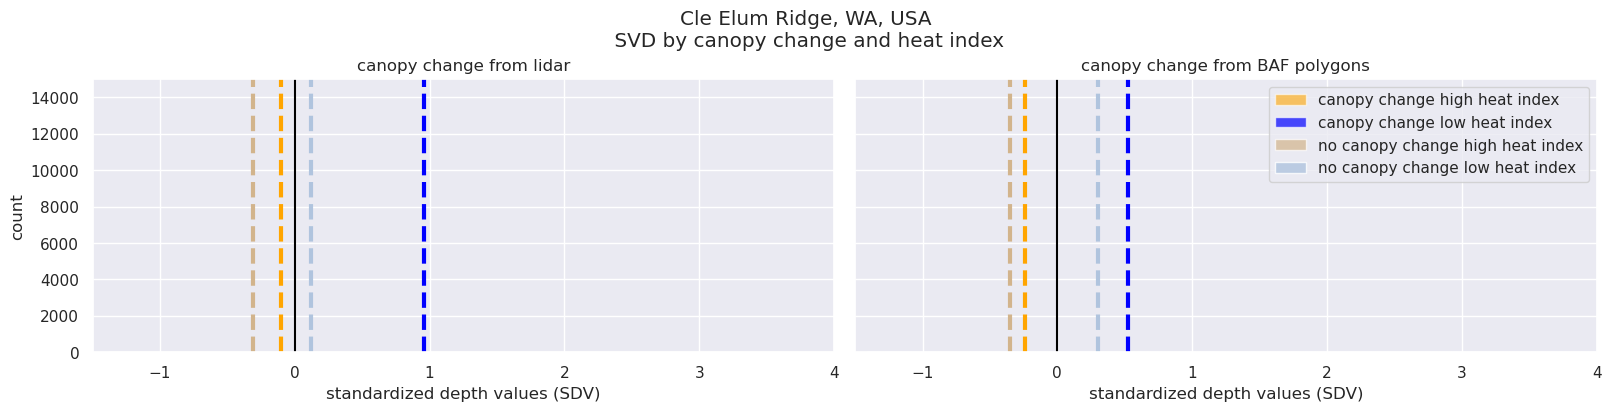

In [55]:
# plot histograms of the four groups 
fig, axes = plt.subplots(1, 2, figsize=(16,4), sharex=True, sharey=True, constrained_layout=True)

# LIDAR 
p1 = ds['sdv_rapid_lidar_nocanopychange_dahpos'].plot.hist(ax=axes[0], bins=100, density=True, label='no canopy change high heat index', alpha=.5, color='tan')
p2 = ds['sdv_rapid_lidar_nocanopychange_dahneg'].plot.hist(ax=axes[0], bins=100, density=True, label='no canopy change low heat index', alpha=.8, color='lightsteelblue')

p4 = ds['sdv_rapid_lidar_canopychange_dahneg'].plot.hist(ax=axes[0], bins=100, density=True, label='canopy change low heat index', alpha=.5, color='blue')
p3 = ds['sdv_rapid_lidar_canopychange_dahpos'].plot.hist(ax=axes[0], bins=100, density=True, label='canopy change high heat index', alpha=.7, color='orange')

width=3
axes[0].axvline(ds['sdv_rapid_lidar_nocanopychange_dahneg'].median(), color='lightsteelblue', linestyle='dashed', linewidth=width)
axes[0].axvline(ds['sdv_rapid_lidar_nocanopychange_dahpos'].median(), color='tan', linestyle='dashed', linewidth=width)
axes[0].axvline(ds['sdv_rapid_lidar_canopychange_dahneg'].median(), color='blue', linestyle='dashed', linewidth=width)
axes[0].axvline(ds['sdv_rapid_lidar_canopychange_dahpos'].median(), color='orange', linestyle='dashed', linewidth=width)

# # legend order
# order=[0,1,3,2]
# handles, labels = plt.gca().get_legend_handles_labels()
# axes[0].legend([handles[idx] for idx in order],[labels[idx] for idx in order])


# BAF
p3 = ds['sdv_rapid_baf_canopychange_dahpos'].plot.hist(ax=axes[1], bins=100, density=True, label='canopy change high heat index', alpha=.6, color='orange')
p4 = ds['sdv_rapid_baf_canopychange_dahneg'].plot.hist(ax=axes[1], bins=100, density=True, label='canopy change low heat index', alpha=.7, color='blue')

p1 = ds['sdv_rapid_baf_nocanopychange_dahpos'].plot.hist(ax=axes[1], bins=100, density=True, label='no canopy change high heat index', alpha=.7, color='tan')
p2 = ds['sdv_rapid_baf_nocanopychange_dahneg'].plot.hist(ax=axes[1], bins=100, density=True, label='no canopy change low heat index', alpha=.8, color='lightsteelblue')

width=3
axes[1].axvline(ds['sdv_rapid_baf_nocanopychange_dahneg'].median(), color='lightsteelblue', linestyle='dashed', linewidth=width)
axes[1].axvline(ds['sdv_rapid_baf_nocanopychange_dahpos'].median(), color='tan', linestyle='dashed', linewidth=width)
axes[1].axvline(ds['sdv_rapid_baf_canopychange_dahneg'].median(), color='blue', linestyle='dashed', linewidth=width)
axes[1].axvline(ds['sdv_rapid_baf_canopychange_dahpos'].median(), color='orange', linestyle='dashed', linewidth=width)

# plot a verticle line at zero for both subplots
axes[0].axvline(0, color='black')
axes[1].axvline(0, color='black')

# # legend order
# order=[2,3,0,1]
# handles, labels = plt.gca().get_legend_handles_labels()
# axes[1].legend([handles[idx] for idx in order],[labels[idx] for idx in order])

# constants
plt.suptitle('Cle Elum Ridge, WA, USA\n SVD by canopy change and heat index')

axes[0].set_title('canopy change from lidar')
axes[1].set_title('canopy change from BAF polygons')

axes[0].set_xlabel('standardized depth values (SDV)')
axes[0].set_ylabel('count')
#axes[0].set_xlim(-1,4)
axes[0].set_ylim(0,15000)

axes[1].set_xlabel('standardized depth values (SDV)')
# axes[1].set_ylabel('count')
axes[1].set_xlim(-1.5,4)
# axes[1].set_ylim(0,15000)

plt.legend()

plt.show()

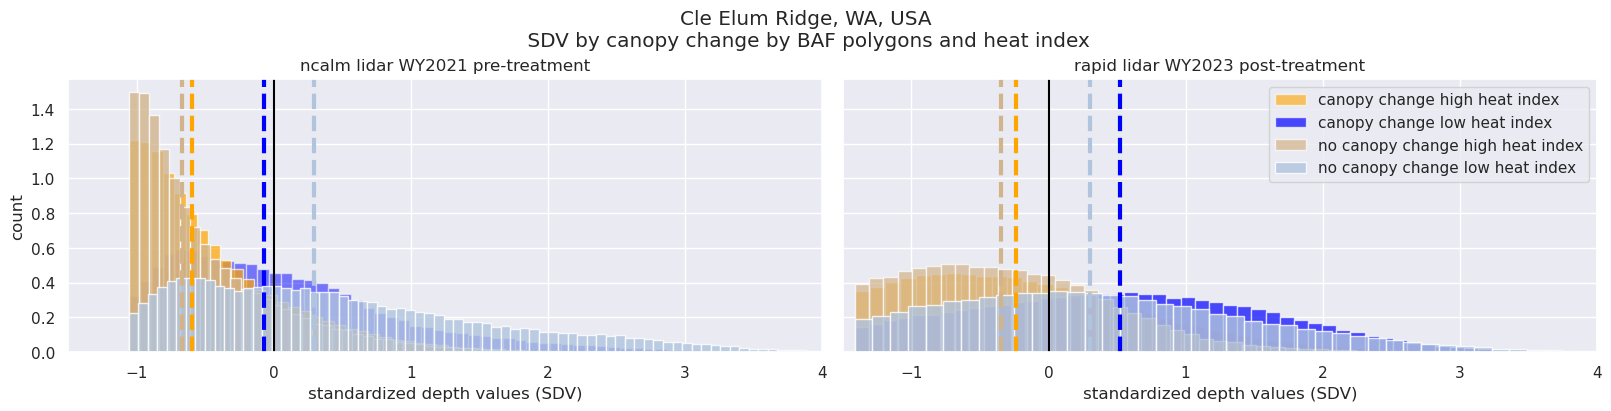

In [56]:
# plot histograms of the four groups 
fig, axes = plt.subplots(1, 2, figsize=(16,4), sharex=True, sharey=True, constrained_layout=True)

# NCALM 
p4 = ds['sdv_ncalm_baf_canopychange_dahneg'].plot.hist(ax=axes[0], bins=100, density=True, label='canopy change low heat index', alpha=.5, color='blue')
p3 = ds['sdv_ncalm_baf_canopychange_dahpos'].plot.hist(ax=axes[0], bins=100, density=True, label='canopy change high heat index', alpha=.7, color='orange')
p1 = ds['sdv_ncalm_baf_nocanopychange_dahpos'].plot.hist(ax=axes[0], bins=100, density=True, label='no canopy change high heat index', alpha=.8, color='tan')
p2 = ds['sdv_ncalm_baf_nocanopychange_dahneg'].plot.hist(ax=axes[0], bins=100, density=True, label='no canopy change low heat index', alpha=.8, color='lightsteelblue')


width=3
axes[0].axvline(ds['sdv_ncalm_baf_nocanopychange_dahneg'].median(), color='lightsteelblue', linestyle='dashed', linewidth=width)
axes[0].axvline(ds['sdv_ncalm_baf_nocanopychange_dahpos'].median(), color='tan', linestyle='dashed', linewidth=width)
axes[0].axvline(ds['sdv_ncalm_baf_canopychange_dahneg'].median(), color='blue', linestyle='dashed', linewidth=width)
axes[0].axvline(ds['sdv_ncalm_baf_canopychange_dahpos'].median(), color='orange', linestyle='dashed', linewidth=width)

# # legend order
# order=[0,1,3,2]
# handles, labels = plt.gca().get_legend_handles_labels()
# axes[0].legend([handles[idx] for idx in order],[labels[idx] for idx in order])


# BAF
p3 = ds['sdv_rapid_baf_canopychange_dahpos'].plot.hist(ax=axes[1], bins=100, density=True, label='canopy change high heat index', alpha=.6, color='orange')
p4 = ds['sdv_rapid_baf_canopychange_dahneg'].plot.hist(ax=axes[1], bins=100, density=True, label='canopy change low heat index', alpha=.7, color='blue')

p1 = ds['sdv_rapid_baf_nocanopychange_dahpos'].plot.hist(ax=axes[1], bins=100, density=True, label='no canopy change high heat index', alpha=.7, color='tan')
p2 = ds['sdv_rapid_baf_nocanopychange_dahneg'].plot.hist(ax=axes[1], bins=100, density=True, label='no canopy change low heat index', alpha=.8, color='lightsteelblue')

width=3
axes[1].axvline(ds['sdv_rapid_baf_nocanopychange_dahneg'].median(), color='lightsteelblue', linestyle='dashed', linewidth=width)
axes[1].axvline(ds['sdv_rapid_baf_nocanopychange_dahpos'].median(), color='tan', linestyle='dashed', linewidth=width)
axes[1].axvline(ds['sdv_rapid_baf_canopychange_dahneg'].median(), color='blue', linestyle='dashed', linewidth=width)
axes[1].axvline(ds['sdv_rapid_baf_canopychange_dahpos'].median(), color='orange', linestyle='dashed', linewidth=width)

# plot a verticle line at zero for both subplots
axes[0].axvline(0, color='black')
axes[1].axvline(0, color='black')

# # legend order
# order=[2,3,0,1]
# handles, labels = plt.gca().get_legend_handles_labels()
# axes[1].legend([handles[idx] for idx in order],[labels[idx] for idx in order])

# constants
plt.suptitle('Cle Elum Ridge, WA, USA\n SDV by canopy change by BAF polygons and heat index')

axes[0].set_title('ncalm lidar WY2021 pre-treatment')
axes[1].set_title('rapid lidar WY2023 post-treatment')

axes[0].set_xlabel('standardized depth values (SDV)')
axes[0].set_ylabel('count')
#axes[0].set_xlim(-1,5)
#axes[0].set_ylim(0,15000)

axes[1].set_xlabel('standardized depth values (SDV)')
# axes[1].set_ylabel('count')
axes[1].set_xlim(-1.5,4)
# axes[1].set_ylim(0,15000)

plt.legend()

plt.show()

## Raster Plots

In [15]:
# calculate difference in snow depth 
ds['diff_hs_rapid_ncalm'] = ds['hs_rapid'] - ds['hs_ncalm']

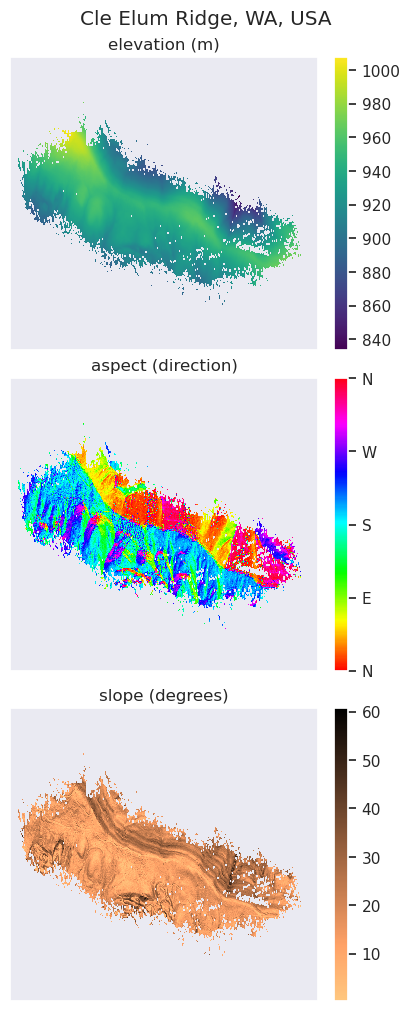

In [74]:
fig, axes = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(4,10), constrained_layout = True)

fig.suptitle('Cle Elum Ridge, WA, USA')

ds.dem.plot(ax=axes[0], cmap='viridis', cbar_kwargs={'label':''})
cax = ds.aspect.plot(ax=axes[1], cmap='hsv', vmin=-1, vmax=360, add_colorbar=False)
ds.slope.plot(ax=axes[2], cmap='copper_r', cbar_kwargs={'label':''})


# aspect colorbar ticks
cbar = fig.colorbar(cax, ticks=[0,90,180,270,360])
cbar.set_ticklabels(['N','E','S','W','N'])

axes[0].set_title('elevation (m)')
axes[1].set_title('aspect (direction)')
axes[2].set_title('slope (degrees)')

axes[0].set_xlabel('')
axes[0].set_ylabel('') 
axes[0].set_xticks([])
axes[0].set_yticks([])

axes[1].set_xlabel('')
axes[1].set_ylabel('') 
axes[1].set_xticks([])
axes[1].set_yticks([])

axes[2].set_xlabel('')
axes[2].set_ylabel('') 
axes[2].set_xticks([])
axes[2].set_yticks([])

plt.show()

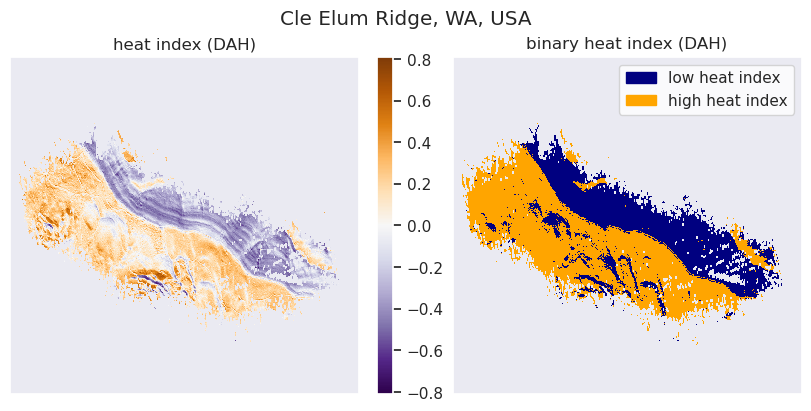

In [75]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(8,4), constrained_layout = True)

fig.suptitle('Cle Elum Ridge, WA, USA')

ds.dah.plot(ax=axes[0], cmap='PuOr_r', cbar_kwargs={'label':''})
ds['dah_binary'].plot(ax=axes[1], vmin=0, vmax=1, cmap=ListedColormap(['navy','orange']), add_colorbar=False)  


# Add a legend for labels, to have different labels for each plot
legend_labels2 = {"navy": "low heat index", 
                 "orange": "high heat index"}                 

patches2 = [Patch(color=color, label=label)
           for color, label in legend_labels2.items()]

axes[1].legend(handles=patches2,
          bbox_to_anchor=(1, 1),
          facecolor="white")

axes[0].set_title('heat index (DAH)')
axes[1].set_title('binary heat index (DAH)')
# axes[2].set_title('')

axes[0].set_xlabel('')
axes[0].set_ylabel('') 
axes[0].set_xticks([])
axes[0].set_yticks([])

axes[1].set_xlabel('')
axes[1].set_ylabel('') 
axes[1].set_xticks([])
axes[1].set_yticks([])

# axes[2].set_xlabel('')
# axes[2].set_ylabel('') 
# axes[2].set_xticks([])
# axes[2].set_yticks([])

plt.show()

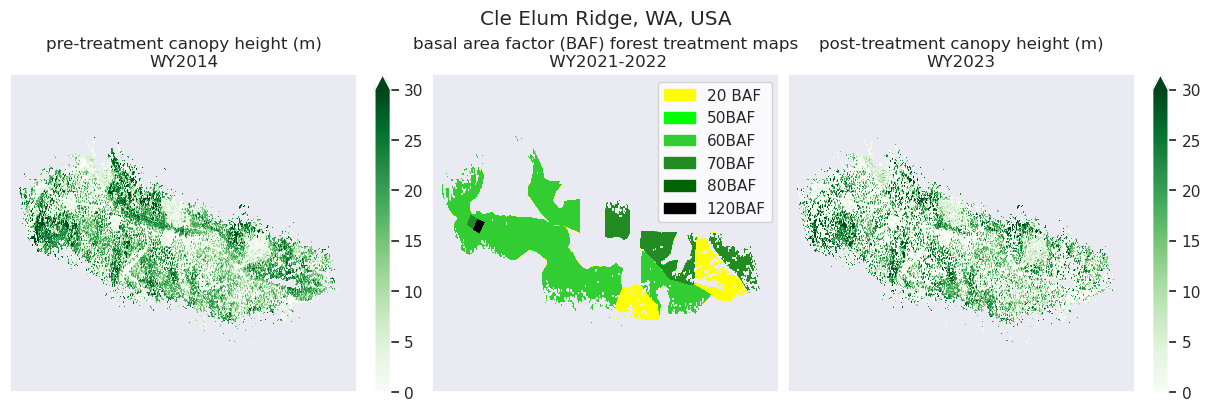

In [77]:
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(12,4), constrained_layout = True)

fig.suptitle('Cle Elum Ridge, WA, USA')

ds.chm_snowoff.plot(ax=axes[0], vmin=0, vmax=30, cmap='Greens', cbar_kwargs={'label':''})
ds.baf.plot(ax=axes[1], cmap=ListedColormap(['yellow', 'lime', 'limegreen', 'forestgreen','darkgreen','black']), add_colorbar=False)
ds.chmws_rapid.plot(ax=axes[2], vmin=0, vmax=30, cmap='Greens', cbar_kwargs={'label':''})  


# Add a legend for labels for baf
legend_labels = {"yellow": "20 BAF", 
                 "lime": "50BAF",
                 "limegreen": "60BAF",
                 "forestgreen": "70BAF",
                 "darkgreen": "80BAF",
                 "black": "120BAF"}

patches = [Patch(color=color, label=label)
           for color, label in legend_labels.items()]

axes[1].legend(handles=patches,
          bbox_to_anchor=(1, 1),
          facecolor="white")


axes[0].set_title('pre-treatment canopy height (m)\nWY2014')
axes[1].set_title('basal area factor (BAF) forest treatment maps\n WY2021-2022')
axes[2].set_title('post-treatment canopy height (m)\nWY2023')

axes[0].set_xlabel('')
axes[0].set_ylabel('') 
axes[0].set_xticks([])
axes[0].set_yticks([])

axes[1].set_xlabel('')
axes[1].set_ylabel('') 
axes[1].set_xticks([])
axes[1].set_yticks([])

axes[2].set_xlabel('')
axes[2].set_ylabel('') 
axes[2].set_xticks([])
axes[2].set_yticks([])

plt.show()

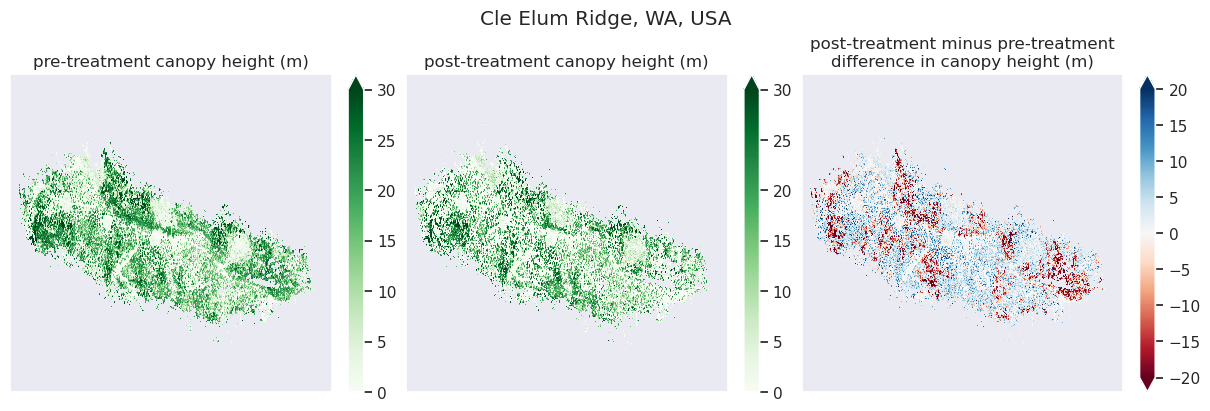

In [19]:
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(12,4), constrained_layout = True)

fig.suptitle('Cle Elum Ridge, WA, USA')

ds.chm_snowoff.plot(ax=axes[0], vmin=0, vmax=30, cmap='Greens', cbar_kwargs={'label':''})
ds.chmws_rapid.plot(ax=axes[1], vmin=0, vmax=30, cmap='Greens', cbar_kwargs={'label':''})  
ds.diff_chm_rapid_ncalm.plot(ax=axes[2], vmin=-20, vmax=20, cmap='RdBu', cbar_kwargs={'label':''})

# ds.baf.plot(ax=axes[1], cmap=ListedColormap(['yellow', 'lime', 'limegreen', 'forestgreen','darkgreen','black']), add_colorbar=False)

# # Add a legend for labels for baf
# legend_labels = {"yellow": "20 BAF", 
#                  "lime": "50BAF",
#                  "limegreen": "60BAF",
#                  "forestgreen": "70BAF",
#                  "darkgreen": "80BAF",
#                  "black": "120BAF"}

# patches = [Patch(color=color, label=label)
#            for color, label in legend_labels.items()]

# axes[1].legend(handles=patches,
#           bbox_to_anchor=(1, 1),
#           facecolor="white")


axes[0].set_title('pre-treatment canopy height (m)')
# axes[1].set_title('basal area factor (BAF) forest treatment maps\n WY2021-2022')
axes[1].set_title('post-treatment canopy height (m)')
axes[2].set_title('post-treatment minus pre-treatment\ndifference in canopy height (m)')

axes[0].set_xlabel('')
axes[0].set_ylabel('') 
axes[0].set_xticks([])
axes[0].set_yticks([])

axes[1].set_xlabel('')
axes[1].set_ylabel('') 
axes[1].set_xticks([])
axes[1].set_yticks([])

axes[2].set_xlabel('')
axes[2].set_ylabel('') 
axes[2].set_xticks([])
axes[2].set_yticks([])

plt.show()

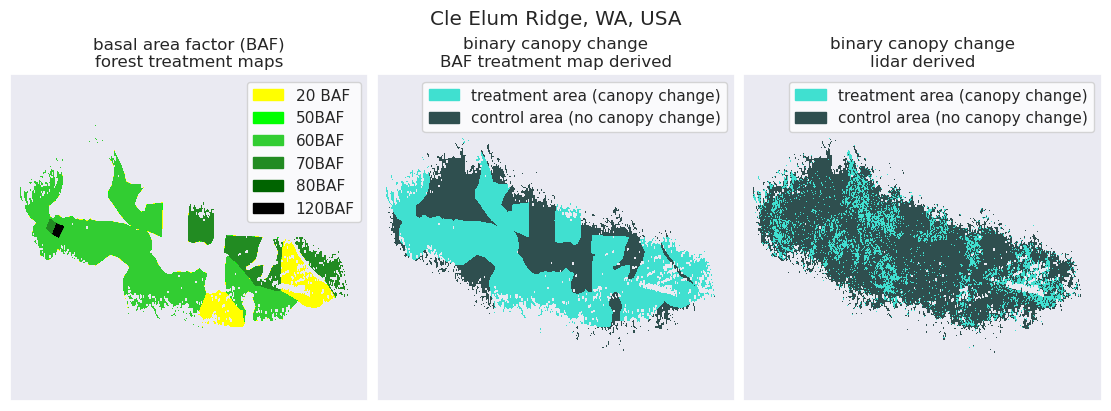

In [18]:
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(11,4), constrained_layout = True)

fig.suptitle('Cle Elum Ridge, WA, USA')

ds.baf.plot(ax=axes[0], cmap=ListedColormap(['yellow', 'lime', 'limegreen', 'forestgreen','darkgreen','black']), add_colorbar=False)

# Add a legend for labels for baf
legend_labels = {"yellow": "20 BAF", 
                 "lime": "50BAF",
                 "limegreen": "60BAF",
                 "forestgreen": "70BAF",
                 "darkgreen": "80BAF",
                 "black": "120BAF"}

patches = [Patch(color=color, label=label)
           for color, label in legend_labels.items()]

axes[0].legend(handles=patches,
          bbox_to_anchor=(1, 1),
          facecolor="white")

axes[0].set_title('basal area factor (BAF)\nforest treatment maps')

p2 = ds['baf_canopychange_binary'].plot(ax=axes[1],   cmap=ListedColormap(['darkslategrey','turquoise']), add_colorbar=False)  
p1 = ds['lidar_canopychange_binary'].plot(ax=axes[2], cmap=ListedColormap(['darkslategrey','turquoise']), add_colorbar=False) 

# Add a legend for labels
legend_labels = {"turquoise": "treatment area (canopy change)", 
                 "darkslategrey": "control area (no canopy change)"}

patches = [Patch(color=color, label=label)
           for color, label in legend_labels.items()]

axes[1].legend(handles=patches,
          bbox_to_anchor=(1, 1),
          facecolor="white")

axes[2].legend(handles=patches,
          bbox_to_anchor=(1, 1),
          facecolor="white")

axes[1].set_title('binary canopy change\nBAF treatment map derived')
axes[2].set_title('binary canopy change\nlidar derived')

axes[0].set_xlabel('')
axes[0].set_ylabel('') 
axes[0].set_xticks([])
axes[0].set_yticks([])

axes[1].set_xlabel('')
axes[1].set_ylabel('') 
axes[1].set_xticks([])
axes[1].set_yticks([])

axes[2].set_xlabel('')
axes[2].set_ylabel('') 
axes[2].set_xticks([])
axes[2].set_yticks([])

plt.show()

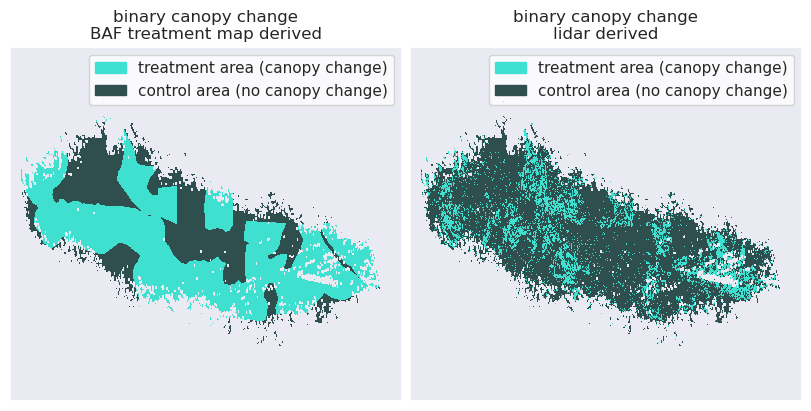

In [82]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(8,4), constrained_layout = True)

# fig.suptitle('Cle Elum Ridge, WA, USA')

p2 = ds['baf_canopychange_binary'].plot(ax=axes[0],   cmap=ListedColormap(['darkslategrey','turquoise']), add_colorbar=False)  
p1 = ds['lidar_canopychange_binary'].plot(ax=axes[1], cmap=ListedColormap(['darkslategrey','turquoise']), add_colorbar=False) 

# Add a legend for labels
legend_labels = {"turquoise": "treatment area (canopy change)", 
                 "darkslategrey": "control area (no canopy change)"}

patches = [Patch(color=color, label=label)
           for color, label in legend_labels.items()]

axes[0].legend(handles=patches,
          bbox_to_anchor=(1, 1),
          facecolor="white")

axes[1].legend(handles=patches,
          bbox_to_anchor=(1, 1),
          facecolor="white")


# fix a few things on the figure 
axes[0].set_title('binary canopy change\nBAF treatment map derived')
axes[1].set_title('binary canopy change\nlidar derived')

axes[0].set_xlabel('')
axes[0].set_ylabel('') 
axes[0].set_xticks([])
axes[0].set_yticks([])

axes[1].set_xlabel('')
axes[1].set_ylabel('') 
axes[1].set_xticks([])
axes[1].set_yticks([])

plt.show()

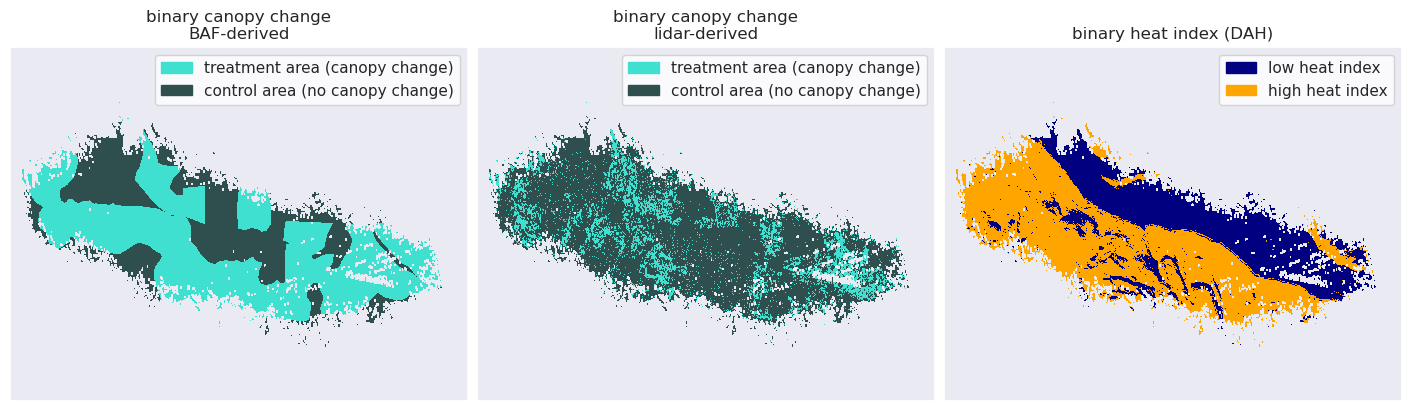

In [66]:
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(14,4), constrained_layout = True)

# fig.suptitle('Cle Elum Ridge, WA, USA')

p2 = ds['baf_canopychange_binary'].plot(ax=axes[0],   cmap=ListedColormap(['darkslategrey','turquoise']), add_colorbar=False)  
p1 = ds['lidar_canopychange_binary'].plot(ax=axes[1], cmap=ListedColormap(['darkslategrey','turquoise']), add_colorbar=False) 
p3 = ds['dah_binary'].plot(ax=axes[2], vmin=0, vmax=1, cmap=ListedColormap(['navy','orange']), add_colorbar=False) 


# Add a legend for labels
legend_labels = {"turquoise": "treatment area (canopy change)", 
                 "darkslategrey": "control area (no canopy change)"}

patches = [Patch(color=color, label=label)
           for color, label in legend_labels.items()]

axes[0].legend(handles=patches,
          bbox_to_anchor=(1, 1),
          facecolor="white")

axes[1].legend(handles=patches,
          bbox_to_anchor=(1, 1),
          facecolor="white")

# Add a legend for labels, to have different labels for each plot
legend_labels2 = {"navy": "low heat index", 
                 "orange": "high heat index"}                 

patches2 = [Patch(color=color, label=label)
           for color, label in legend_labels2.items()]

axes[2].legend(handles=patches2,
          bbox_to_anchor=(1, 1),
          facecolor="white")


# fix a few things on the figure 
axes[0].set_title('binary canopy change\nBAF-derived')
axes[1].set_title('binary canopy change\nlidar-derived')
axes[2].set_title('binary heat index (DAH)')

axes[0].set_xlabel('')
axes[0].set_ylabel('') 
axes[0].set_xticks([])
axes[0].set_yticks([])

axes[1].set_xlabel('')
axes[1].set_ylabel('') 
axes[1].set_xticks([])
axes[1].set_yticks([])

axes[2].set_xlabel('')
axes[2].set_ylabel('') 
axes[2].set_xticks([])
axes[2].set_yticks([])

plt.show()

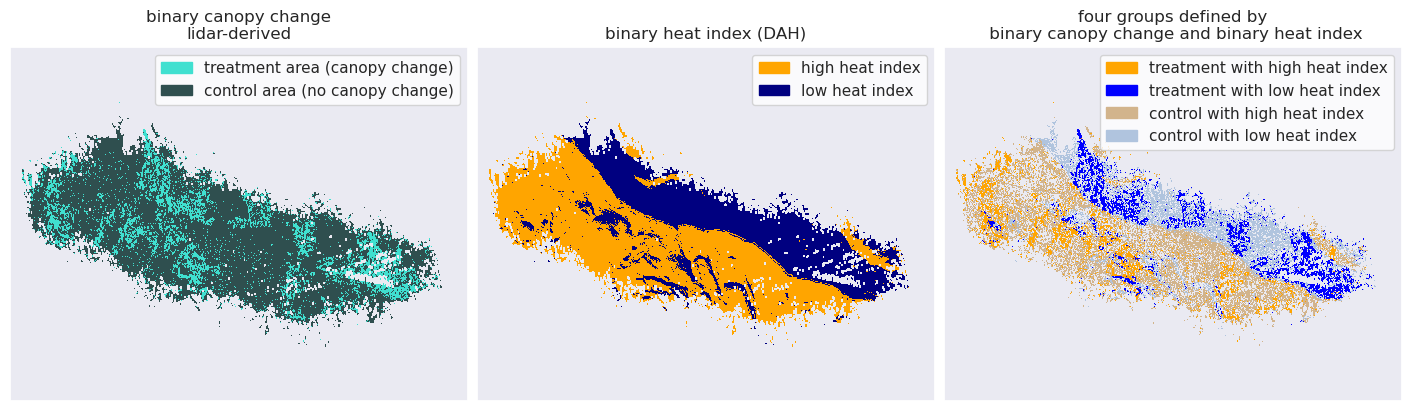

In [159]:
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(14,4), constrained_layout = True)

# fig.suptitle('Cle Elum Ridge, WA, USA')


p1 = ds['lidar_canopychange_binary'].plot(ax=axes[0], cmap=ListedColormap(['darkslategrey','turquoise']), add_colorbar=False) 
p2 = ds['dah_binary'].plot(ax=axes[1], vmin=0, vmax=1, cmap=ListedColormap(['navy','orange']), add_colorbar=False) 

# lidar
p3 = ds['hs_lidar_nocanopychange_dahpos'].plot(ax=axes[2], cmap=ListedColormap(['tan']),  
                                               label='control area with high heat index', add_colorbar=False) 
p4 = ds['hs_lidar_nocanopychange_dahneg'].plot(ax=axes[2], cmap=ListedColormap(['lightsteelblue']),
                                               label='control area with low heat index', add_colorbar=False) 

p5 = ds['hs_lidar_canopychange_dahneg'].plot(ax=axes[2], cmap=ListedColormap(['blue']),  
                                               label='treatment area with high heat index', add_colorbar=False) 
p6 = ds['hs_lidar_canopychange_dahpos'].plot(ax=axes[2], cmap=ListedColormap(['orange']),
                                               label='treatment area with low heat index', add_colorbar=False) 


# Add a legend for labels
legend_labels = {"turquoise": "treatment area (canopy change)", 
                 "darkslategrey": "control area (no canopy change)"}

patches = [Patch(color=color, label=label)
           for color, label in legend_labels.items()]

axes[0].legend(handles=patches,
          bbox_to_anchor=(1, 1),
          facecolor="white")

# Add a legend for labels, to have different labels for each plot
legend_labels2 = {"orange": "high heat index",
                  "navy": "low heat index", 
                 }                 

patches2 = [Patch(color=color, label=label)
           for color, label in legend_labels2.items()]

axes[1].legend(handles=patches2,
          bbox_to_anchor=(1, 1),
          facecolor="white")

# Add a legend for labels, to have different labels for each plot
legend_labels3 = {"orange": "treatment with high heat index",
                  "blue": "treatment with low heat index",
                  "tan": "control with high heat index", 
                 "lightsteelblue": "control with low heat index",}                 

patches2 = [Patch(color=color, label=label)
           for color, label in legend_labels3.items()]

axes[2].legend(handles=patches2,
          bbox_to_anchor=(1, 1),
          facecolor="white")


# fix a few things on the figure 
axes[0].set_title('binary canopy change\nlidar-derived')
axes[1].set_title('binary heat index (DAH)')
axes[2].set_title('four groups defined by\n binary canopy change and binary heat index')

axes[0].set_xlabel('')
axes[0].set_ylabel('') 
axes[0].set_xticks([])
axes[0].set_yticks([])

axes[1].set_xlabel('')
axes[1].set_ylabel('') 
axes[1].set_xticks([])
axes[1].set_yticks([])

axes[2].set_xlabel('')
axes[2].set_ylabel('') 
axes[2].set_xticks([])
axes[2].set_yticks([])

plt.show()

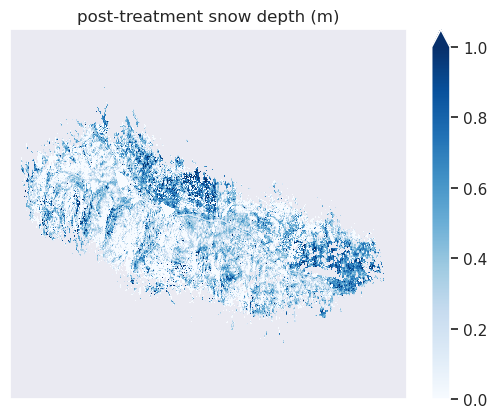

In [84]:
ds['hs_rapid'].plot(cmap='Blues', vmin=0, vmax=1, cbar_kwargs={'label':''})
plt.xlabel('')
plt.ylabel('') 
plt.xticks([])
plt.yticks([])
plt.title('post-treatment snow depth (m)')

plt.show()

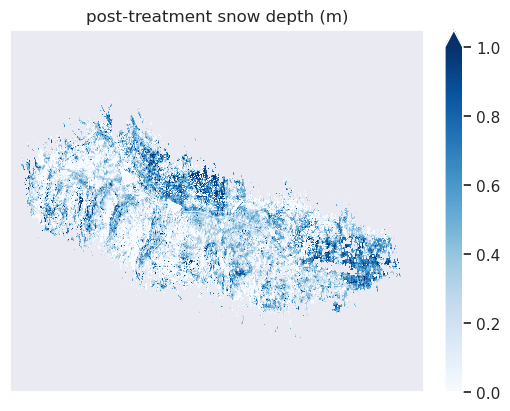

In [87]:
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(5,4), constrained_layout = True)

ds.hs_rapid.plot(cmap='Blues', vmin=0, vmax=1, cbar_kwargs={'label':''})

axes.set_title('post-treatment snow depth (m)')

axes.set_xlabel('')
axes.set_ylabel('') 
axes.set_xticks([])
axes.set_yticks([])

plt.show()

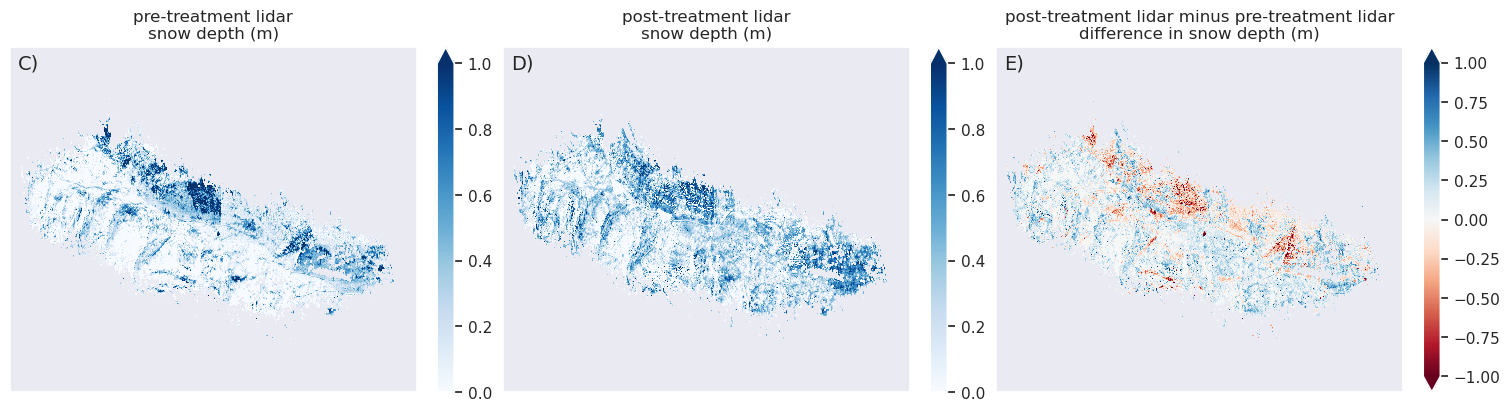

In [15]:
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(15,4), constrained_layout = True)

# fig.suptitle('Cle Elum Ridge, WA, USA\n canopy structure before and after forest treatments')

# row 3 
ds.hs_ncalm.plot(ax=axes[0], cmap='Blues', vmin=0, vmax=1, cbar_kwargs={'label':''})
ds.hs_rapid.plot(ax=axes[1], cmap='Blues', vmin=0, vmax=1, cbar_kwargs={'label':''})
ds.diff_hs_rapid_ncalm.plot(ax=axes[2], cmap='RdBu', vmin=-1, vmax=1, cbar_kwargs={'label':''})

axes[0].set_title('pre-treatment lidar\nsnow depth (m)')
axes[1].set_title('post-treatment lidar\nsnow depth (m)')
axes[2].set_title('post-treatment lidar minus pre-treatment lidar\ndifference in snow depth (m)')


axes[0].set_xlabel('')
axes[0].set_ylabel('') 
axes[0].set_xticks([])
axes[0].set_yticks([])

axes[1].set_xlabel('')
axes[1].set_ylabel('') 
axes[1].set_xticks([])
axes[1].set_yticks([])

axes[2].set_xlabel('')
axes[2].set_ylabel('') 
axes[2].set_xticks([])
axes[2].set_yticks([])

# add A) B) C) labels to the subplots in the top left corner 
axes[0].text(0.02, 0.98, 'C)', transform=axes[0].transAxes, fontsize=14,  va='top')
axes[1].text(0.02, 0.98, 'D)', transform=axes[1].transAxes, fontsize=14,  va='top')
axes[2].text(0.02, 0.98, 'E)', transform=axes[2].transAxes, fontsize=14,  va='top')

plt.show()

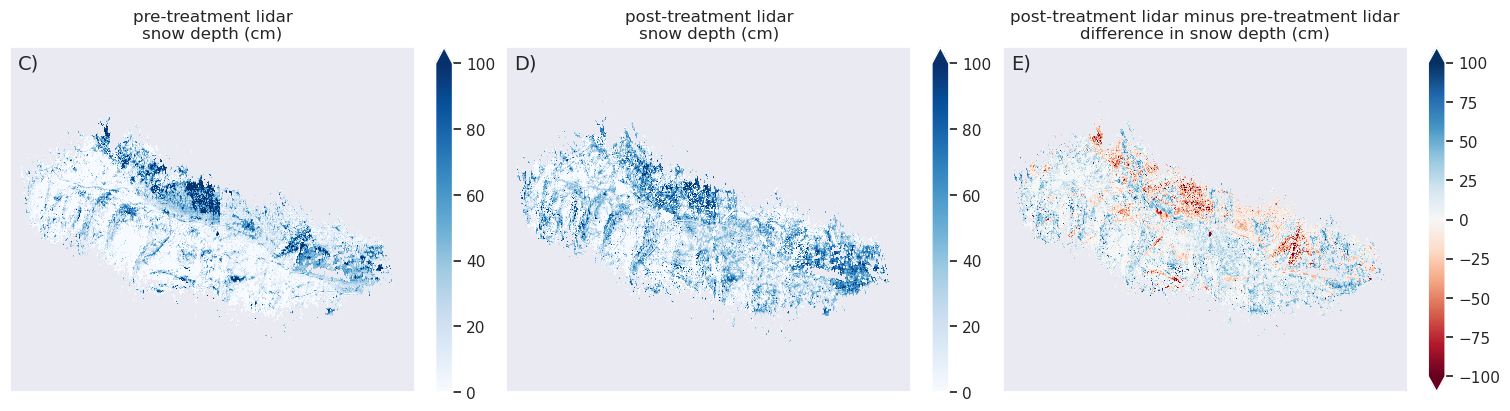

In [17]:
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(15,4), constrained_layout = True)

# fig.suptitle('Cle Elum Ridge, WA, USA\n canopy structure before and after forest treatments')

# row 3 
(ds.hs_ncalm*100).plot(ax=axes[0], cmap='Blues', vmin=0, vmax=100, cbar_kwargs={'label':''})
(ds.hs_rapid*100).plot(ax=axes[1], cmap='Blues', vmin=0, vmax=100, cbar_kwargs={'label':''})
(ds.diff_hs_rapid_ncalm*100).plot(ax=axes[2], cmap='RdBu', vmin=-100, vmax=100, cbar_kwargs={'label':''})

axes[0].set_title('pre-treatment lidar\nsnow depth (cm)')
axes[1].set_title('post-treatment lidar\nsnow depth (cm)')
axes[2].set_title('post-treatment lidar minus pre-treatment lidar\ndifference in snow depth (cm)')


axes[0].set_xlabel('')
axes[0].set_ylabel('') 
axes[0].set_xticks([])
axes[0].set_yticks([])

axes[1].set_xlabel('')
axes[1].set_ylabel('') 
axes[1].set_xticks([])
axes[1].set_yticks([])

axes[2].set_xlabel('')
axes[2].set_ylabel('') 
axes[2].set_xticks([])
axes[2].set_yticks([])

# add A) B) C) labels to the subplots in the top left corner 
axes[0].text(0.02, 0.98, 'C)', transform=axes[0].transAxes, fontsize=14,  va='top')
axes[1].text(0.02, 0.98, 'D)', transform=axes[1].transAxes, fontsize=14,  va='top')
axes[2].text(0.02, 0.98, 'E)', transform=axes[2].transAxes, fontsize=14,  va='top')

plt.show()

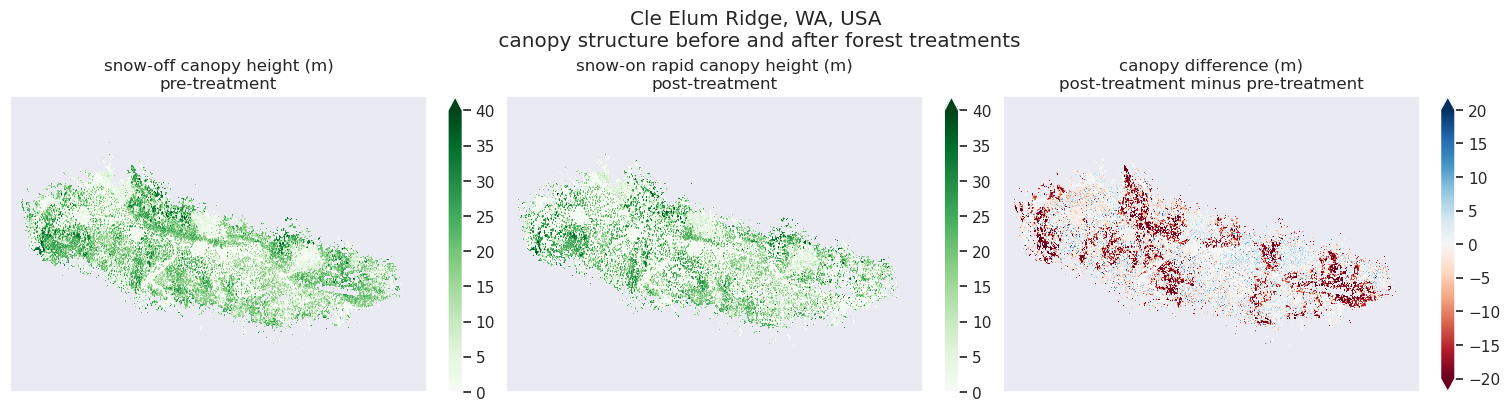

In [69]:
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(15,4), constrained_layout = True)

fig.suptitle('Cle Elum Ridge, WA, USA\n canopy structure before and after forest treatments')

ds.chm_snowoff.plot(ax=axes[0], cmap='Greens', vmin=0, vmax=40, cbar_kwargs={'label':''}) 
ds.chmws_rapid.plot(ax=axes[1], cmap='Greens', vmin=0, vmax=40, cbar_kwargs={'label':''}) 
ds.diff_chm_rapid_snowoff.plot(ax=axes[2], cmap='RdBu', vmin=-20, vmax=20, cbar_kwargs={'label':''}) 

axes[0].set_title('snow-off canopy height (m)\npre-treatment')
axes[1].set_title('snow-on rapid canopy height (m)\npost-treatment')
axes[2].set_title('canopy difference (m)\npost-treatment minus pre-treatment')

# fix a few things on the figure 
axes[0].set_xlabel('')
axes[0].set_ylabel('') 
axes[0].set_xticks([])
axes[0].set_yticks([])

axes[1].set_xlabel('')
axes[1].set_ylabel('') 
axes[1].set_xticks([])
axes[1].set_yticks([])

axes[2].set_xlabel('')
axes[2].set_ylabel('') 
axes[2].set_xticks([])
axes[2].set_yticks([])

plt.show()

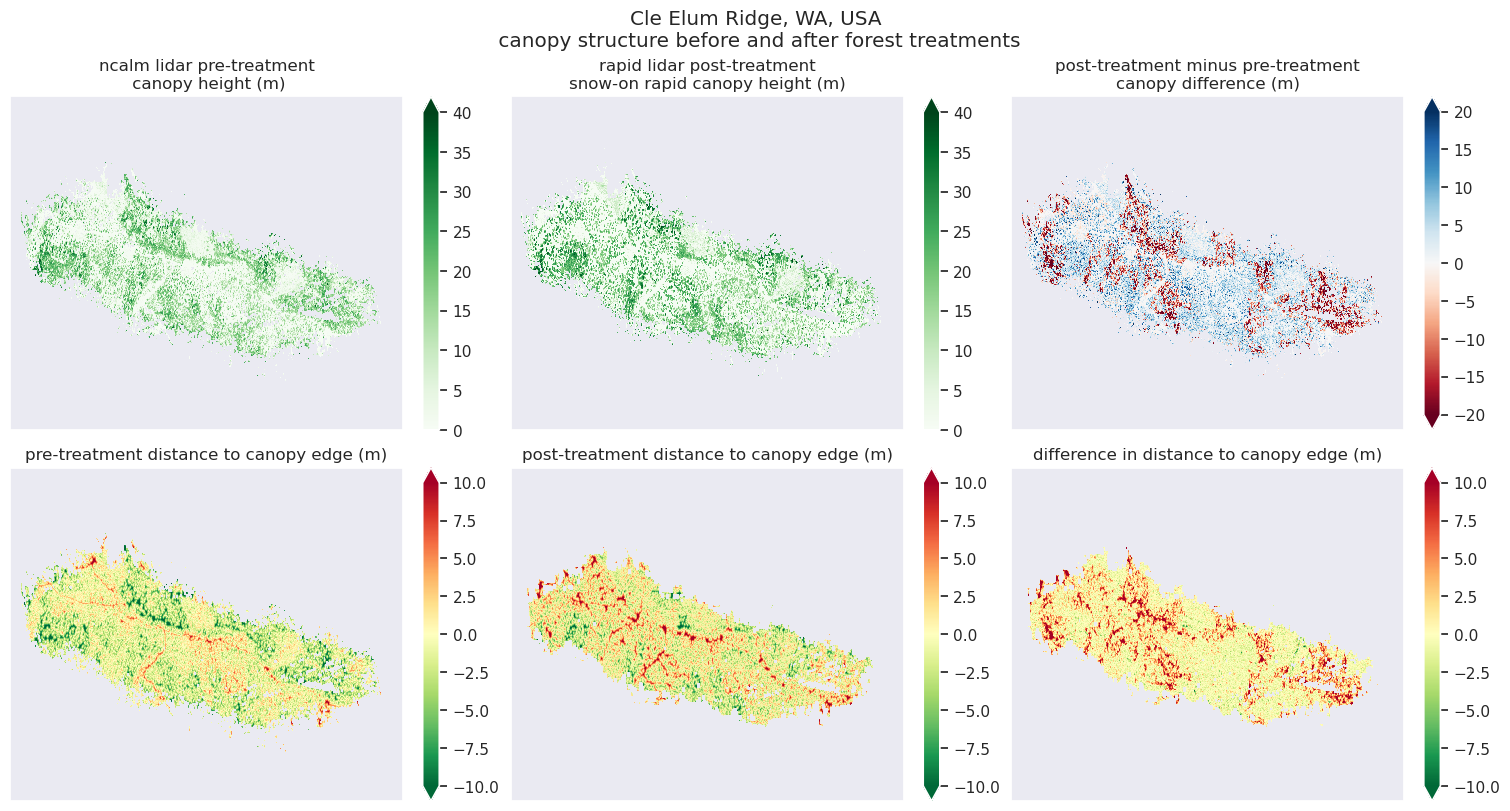

In [70]:
fig, axes = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(15,8), constrained_layout = True)

fig.suptitle('Cle Elum Ridge, WA, USA\n canopy structure before and after forest treatments')

# row 1
# ds.chm_snowoff.plot(ax=axes[0,0], cmap='Greens', vmin=0, vmax=40, cbar_kwargs={'label':''}) 
ds.chmws_ncalm.plot(ax=axes[0,0], cmap='Greens', vmin=0, vmax=40, cbar_kwargs={'label':''}) 
ds.chmws_rapid.plot(ax=axes[0,1], cmap='Greens', vmin=0, vmax=40, cbar_kwargs={'label':''}) 
# ds.diff_chm_rapid_snowoff.plot(ax=axes[0,2], cmap='RdBu', vmin=-20, vmax=20, cbar_kwargs={'label':''}) 
ds.diff_chm_rapid_ncalm.plot(ax=axes[0,2], cmap='RdBu', vmin=-20, vmax=20, cbar_kwargs={'label':''}) 

axes[0,0].set_title('ncalm lidar pre-treatment\n canopy height (m)')
axes[0,1].set_title('rapid lidar post-treatment\nsnow-on rapid canopy height (m)')
axes[0,2].set_title('post-treatment minus pre-treatment\ncanopy difference (m)')

# row 2
ds.dce_ncalm.plot(ax=axes[1,0], cmap='RdYlGn_r', vmin=-10, vmax=10, cbar_kwargs={'label':''})
ds.dce_rapid.plot(ax=axes[1,1], cmap='RdYlGn_r', vmin=-10, vmax=10, cbar_kwargs={'label':''})
ds.diff_dce_rapid_ncalm.plot(ax=axes[1,2], cmap='RdYlGn_r', vmin=-10, vmax=10, cbar_kwargs={'label':''})

axes[1,0].set_title('pre-treatment distance to canopy edge (m)')
axes[1,1].set_title('post-treatment distance to canopy edge (m)')
axes[1,2].set_title('difference in distance to canopy edge (m)')


# some constants 
# row 1 
axes[0,0].set_xlabel(''); axes[0,0].set_ylabel(''); axes[0,0].set_xticks([]); axes[0,0].set_yticks([])
axes[0,1].set_xlabel(''); axes[0,1].set_ylabel(''); axes[0,1].set_xticks([]); axes[0,1].set_yticks([])
axes[0,2].set_xlabel(''); axes[0,2].set_ylabel(''); axes[0,2].set_xticks([]); axes[0,2].set_yticks([])

# row 2
axes[1,0].set_xlabel(''); axes[1,0].set_ylabel(''); axes[1,0].set_xticks([]); axes[1,0].set_yticks([])
axes[1,1].set_xlabel(''); axes[1,1].set_ylabel(''); axes[1,1].set_xticks([]); axes[1,1].set_yticks([])
axes[1,2].set_xlabel(''); axes[1,2].set_ylabel(''); axes[1,2].set_xticks([]); axes[1,2].set_yticks([])

# # row 3 
# axes[2,0].set_xlabel(''); axes[2,0].set_ylabel(''); axes[2,0].set_xticks([]); axes[2,0].set_yticks([])
# axes[2,1].set_xlabel(''); axes[2,1].set_ylabel(''); axes[2,1].set_xticks([]); axes[2,1].set_yticks([])
# axes[2,2].set_xlabel(''); axes[2,2].set_ylabel(''); axes[2,2].set_xticks([]); axes[2,2].set_yticks([])
plt.show()

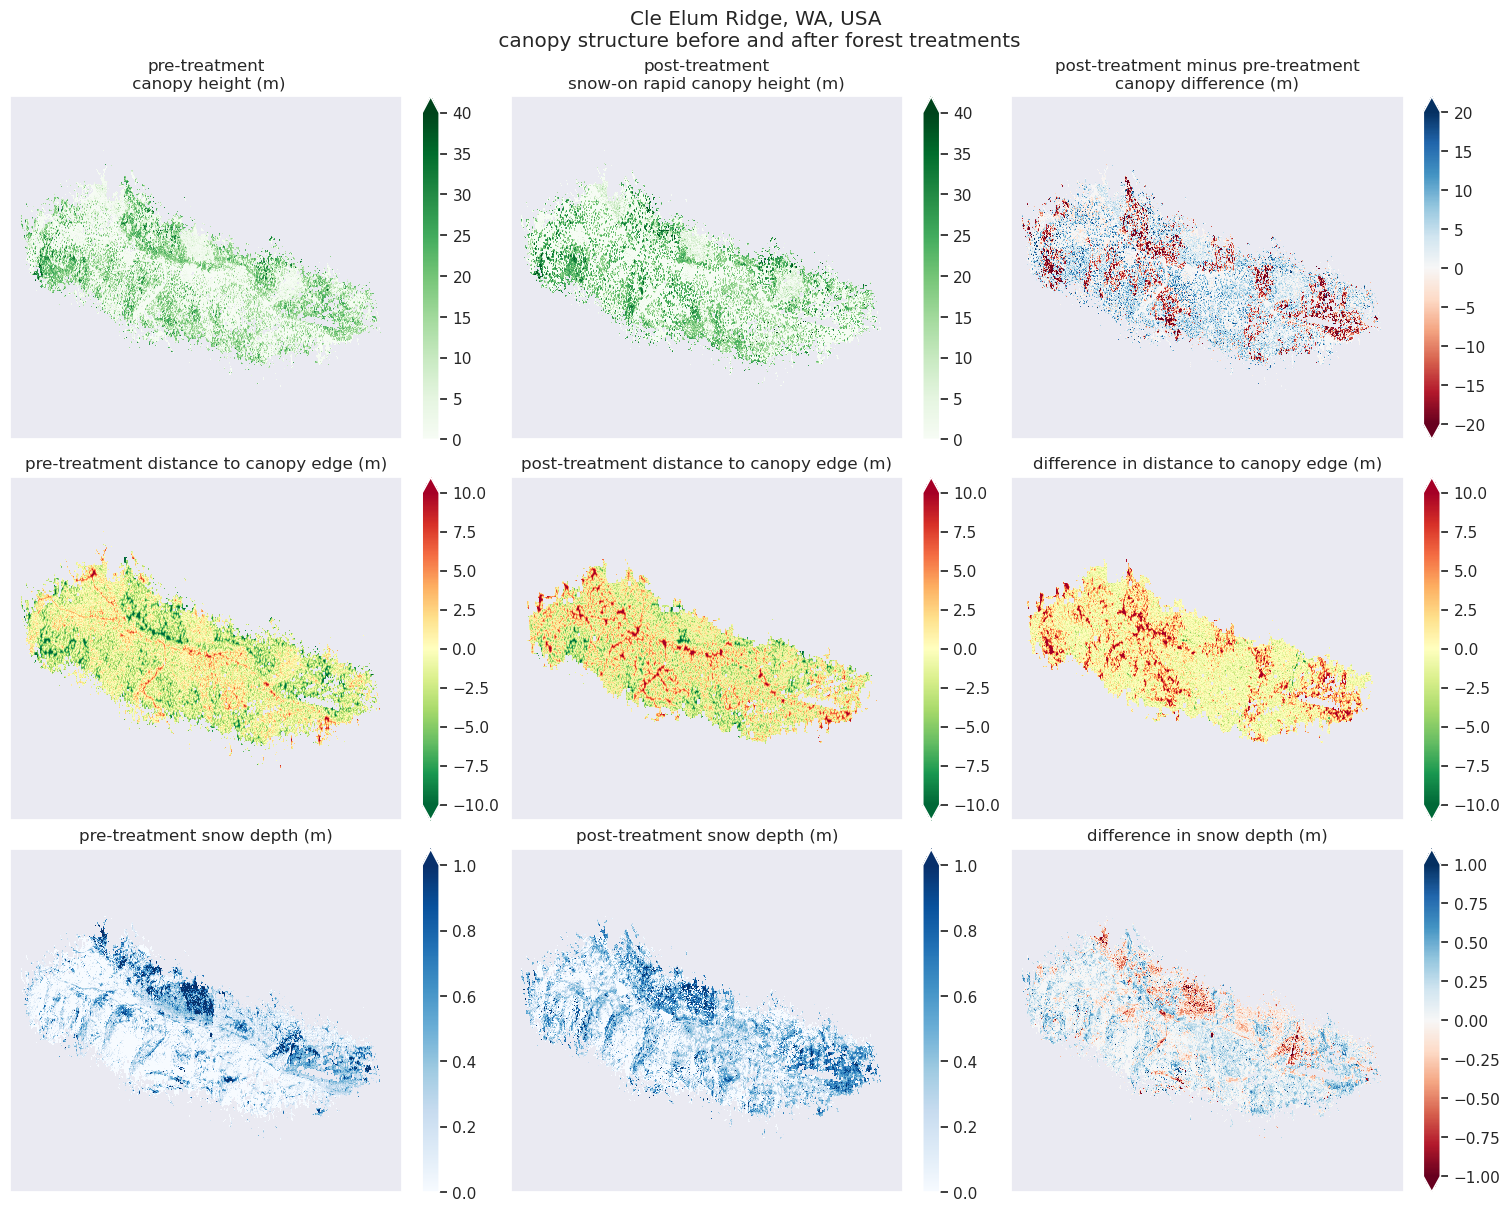

In [71]:
fig, axes = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(15,12), constrained_layout = True)

fig.suptitle('Cle Elum Ridge, WA, USA\n canopy structure before and after forest treatments')

# row 1
# ds.chm_snowoff.plot(ax=axes[0,0], cmap='Greens', vmin=0, vmax=40, cbar_kwargs={'label':''}) 
ds.chmws_ncalm.plot(ax=axes[0,0], cmap='Greens', vmin=0, vmax=40, cbar_kwargs={'label':''}) 
ds.chmws_rapid.plot(ax=axes[0,1], cmap='Greens', vmin=0, vmax=40, cbar_kwargs={'label':''}) 
# ds.diff_chm_rapid_snowoff.plot(ax=axes[0,2], cmap='RdBu', vmin=-20, vmax=20, cbar_kwargs={'label':''}) 
ds.diff_chm_rapid_ncalm.plot(ax=axes[0,2], cmap='RdBu', vmin=-20, vmax=20, cbar_kwargs={'label':''}) 

axes[0,0].set_title('pre-treatment\n canopy height (m)')
axes[0,1].set_title('post-treatment\nsnow-on rapid canopy height (m)')
axes[0,2].set_title('post-treatment minus pre-treatment\ncanopy difference (m)')

# row 2
ds.dce_ncalm.plot(ax=axes[1,0], cmap='RdYlGn_r', vmin=-10, vmax=10, cbar_kwargs={'label':''})
ds.dce_rapid.plot(ax=axes[1,1], cmap='RdYlGn_r', vmin=-10, vmax=10, cbar_kwargs={'label':''})
ds.diff_dce_rapid_ncalm.plot(ax=axes[1,2], cmap='RdYlGn_r', vmin=-10, vmax=10, cbar_kwargs={'label':''})

axes[1,0].set_title('pre-treatment distance to canopy edge (m)')
axes[1,1].set_title('post-treatment distance to canopy edge (m)')
axes[1,2].set_title('difference in distance to canopy edge (m)')

# row 3 
ds.hs_ncalm.plot(ax=axes[2,0], cmap='Blues', vmin=0, vmax=1, cbar_kwargs={'label':''})
ds.hs_rapid.plot(ax=axes[2,1], cmap='Blues', vmin=0, vmax=1, cbar_kwargs={'label':''})
ds.diff_hs_rapid_ncalm.plot(ax=axes[2,2], cmap='RdBu', vmin=-1, vmax=1, cbar_kwargs={'label':''})

axes[2,0].set_title('pre-treatment snow depth (m)')
axes[2,1].set_title('post-treatment snow depth (m)')
axes[2,2].set_title('difference in snow depth (m)')


# some constants 
# row 1 
axes[0,0].set_xlabel(''); axes[0,0].set_ylabel(''); axes[0,0].set_xticks([]); axes[0,0].set_yticks([])
axes[0,1].set_xlabel(''); axes[0,1].set_ylabel(''); axes[0,1].set_xticks([]); axes[0,1].set_yticks([])
axes[0,2].set_xlabel(''); axes[0,2].set_ylabel(''); axes[0,2].set_xticks([]); axes[0,2].set_yticks([])

# row 2
axes[1,0].set_xlabel(''); axes[1,0].set_ylabel(''); axes[1,0].set_xticks([]); axes[1,0].set_yticks([])
axes[1,1].set_xlabel(''); axes[1,1].set_ylabel(''); axes[1,1].set_xticks([]); axes[1,1].set_yticks([])
axes[1,2].set_xlabel(''); axes[1,2].set_ylabel(''); axes[1,2].set_xticks([]); axes[1,2].set_yticks([])

# row 3 
axes[2,0].set_xlabel(''); axes[2,0].set_ylabel(''); axes[2,0].set_xticks([]); axes[2,0].set_yticks([])
axes[2,1].set_xlabel(''); axes[2,1].set_ylabel(''); axes[2,1].set_xticks([]); axes[2,1].set_yticks([])
axes[2,2].set_xlabel(''); axes[2,2].set_ylabel(''); axes[2,2].set_xticks([]); axes[2,2].set_yticks([])
plt.show()

Space to add the random forest model prediction

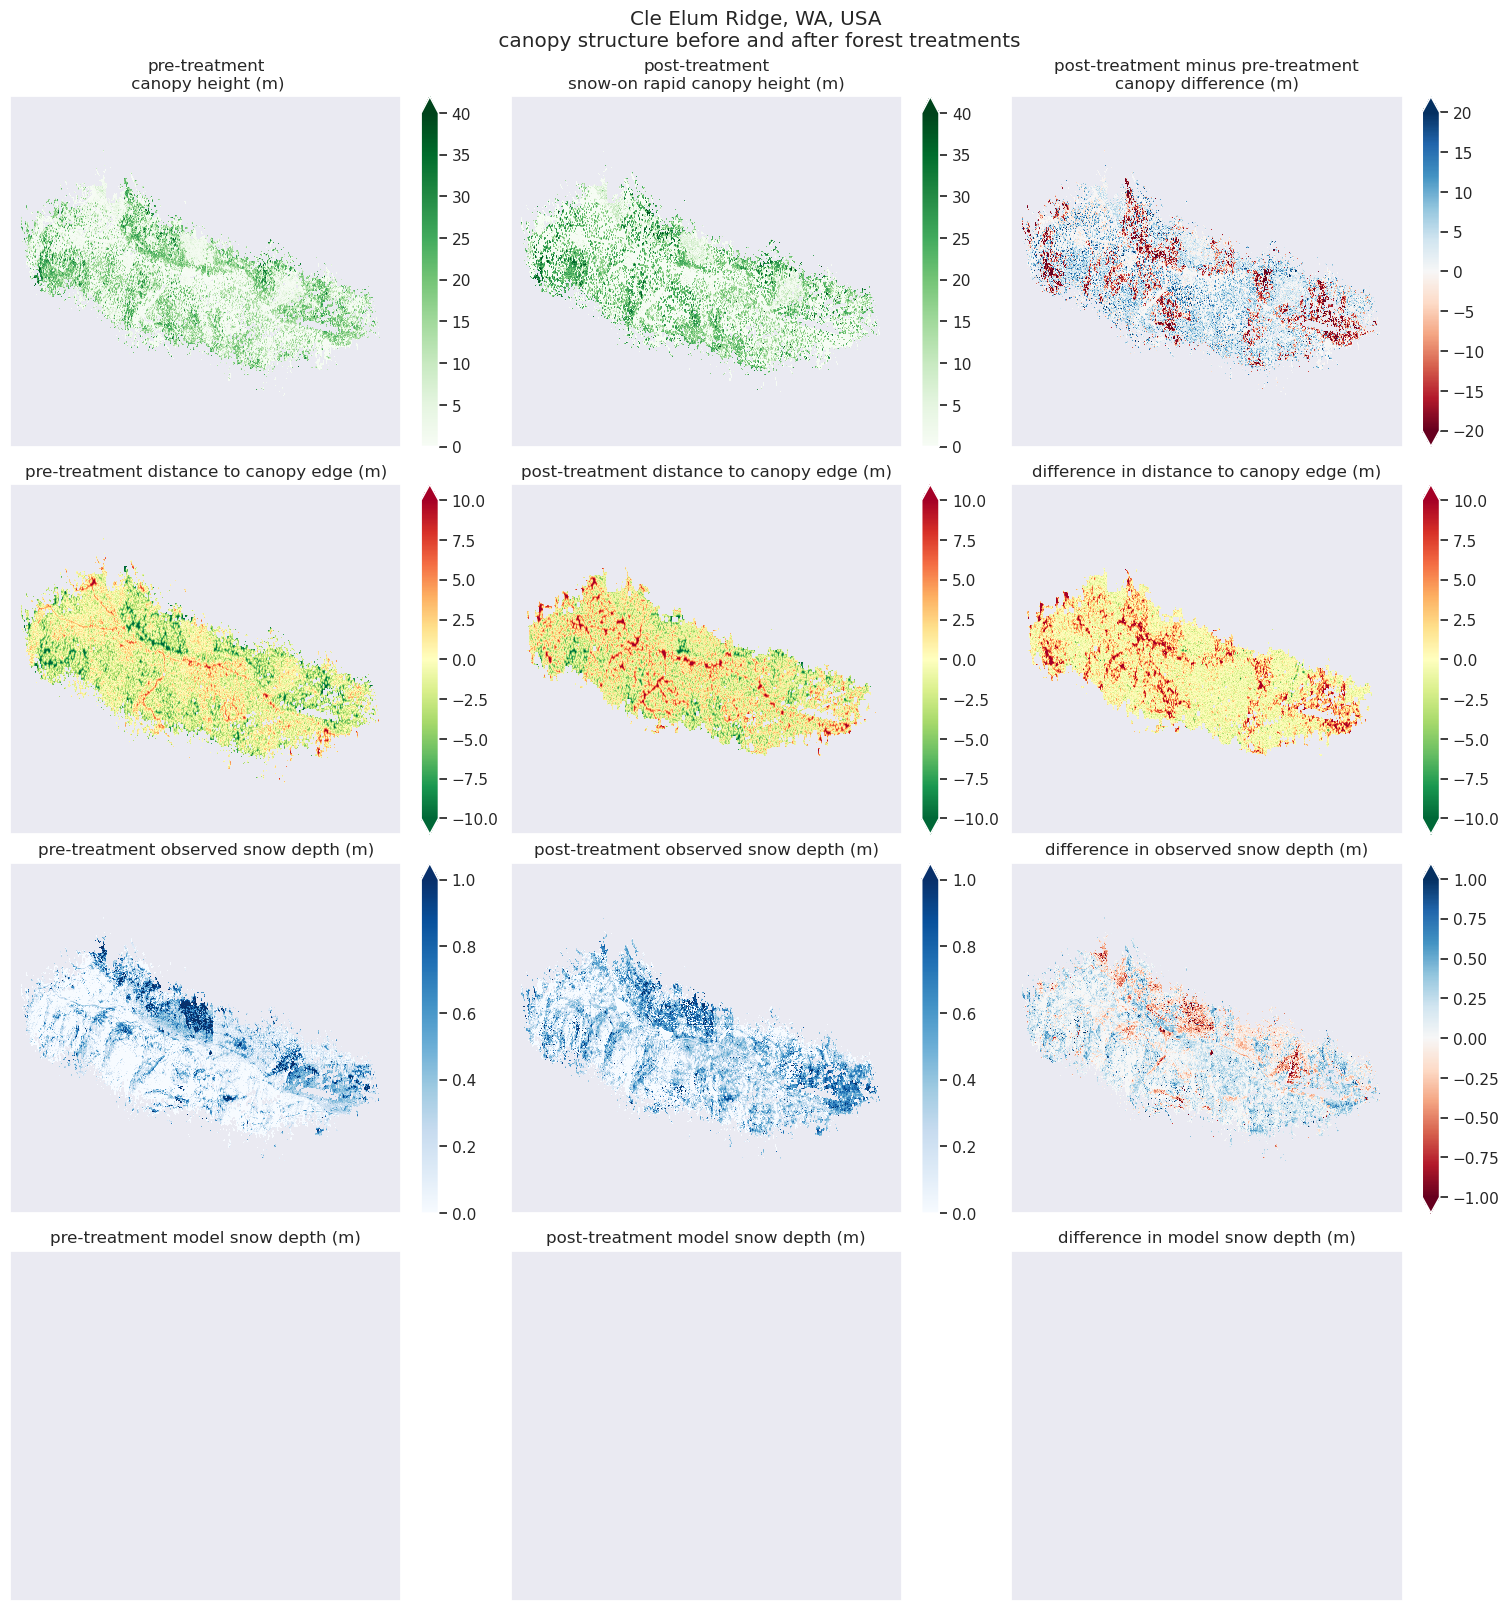

In [72]:
fig, axes = plt.subplots(4, 3, sharex=True, sharey=True, figsize=(15,16), constrained_layout = True)

fig.suptitle('Cle Elum Ridge, WA, USA\n canopy structure before and after forest treatments')

# row 1
# ds.chm_snowoff.plot(ax=axes[0,0], cmap='Greens', vmin=0, vmax=40, cbar_kwargs={'label':''}) 
ds.chmws_ncalm.plot(ax=axes[0,0], cmap='Greens', vmin=0, vmax=40, cbar_kwargs={'label':''}) 
ds.chmws_rapid.plot(ax=axes[0,1], cmap='Greens', vmin=0, vmax=40, cbar_kwargs={'label':''}) 
# ds.diff_chm_rapid_snowoff.plot(ax=axes[0,2], cmap='RdBu', vmin=-20, vmax=20, cbar_kwargs={'label':''}) 
ds.diff_chm_rapid_ncalm.plot(ax=axes[0,2], cmap='RdBu', vmin=-20, vmax=20, cbar_kwargs={'label':''}) 

axes[0,0].set_title('pre-treatment\n canopy height (m)')
axes[0,1].set_title('post-treatment\nsnow-on rapid canopy height (m)')
axes[0,2].set_title('post-treatment minus pre-treatment\ncanopy difference (m)')

# row 2
ds.dce_ncalm.plot(ax=axes[1,0], cmap='RdYlGn_r', vmin=-10, vmax=10, cbar_kwargs={'label':''})
ds.dce_rapid.plot(ax=axes[1,1], cmap='RdYlGn_r', vmin=-10, vmax=10, cbar_kwargs={'label':''})
ds.diff_dce_rapid_ncalm.plot(ax=axes[1,2], cmap='RdYlGn_r', vmin=-10, vmax=10, cbar_kwargs={'label':''})

axes[1,0].set_title('pre-treatment distance to canopy edge (m)')
axes[1,1].set_title('post-treatment distance to canopy edge (m)')
axes[1,2].set_title('difference in distance to canopy edge (m)')

# row 3 
ds.hs_ncalm.plot(ax=axes[2,0], cmap='Blues', vmin=0, vmax=1, cbar_kwargs={'label':''})
ds.hs_rapid.plot(ax=axes[2,1], cmap='Blues', vmin=0, vmax=1, cbar_kwargs={'label':''})
ds.diff_hs_rapid_ncalm.plot(ax=axes[2,2], cmap='RdBu', vmin=-1, vmax=1, cbar_kwargs={'label':''})

axes[2,0].set_title('pre-treatment observed snow depth (m)')
axes[2,1].set_title('post-treatment observed snow depth (m)')
axes[2,2].set_title('difference in observed snow depth (m)')

# row 4 (random forest model results)



axes[3,0].set_title('pre-treatment model snow depth (m)')
axes[3,1].set_title('post-treatment model snow depth (m)')
axes[3,2].set_title('difference in model snow depth (m)')



# some constants 
# row 1 
axes[0,0].set_xlabel(''); axes[0,0].set_ylabel(''); axes[0,0].set_xticks([]); axes[0,0].set_yticks([])
axes[0,1].set_xlabel(''); axes[0,1].set_ylabel(''); axes[0,1].set_xticks([]); axes[0,1].set_yticks([])
axes[0,2].set_xlabel(''); axes[0,2].set_ylabel(''); axes[0,2].set_xticks([]); axes[0,2].set_yticks([])

# row 2
axes[1,0].set_xlabel(''); axes[1,0].set_ylabel(''); axes[1,0].set_xticks([]); axes[1,0].set_yticks([])
axes[1,1].set_xlabel(''); axes[1,1].set_ylabel(''); axes[1,1].set_xticks([]); axes[1,1].set_yticks([])
axes[1,2].set_xlabel(''); axes[1,2].set_ylabel(''); axes[1,2].set_xticks([]); axes[1,2].set_yticks([])

# row 3 
axes[2,0].set_xlabel(''); axes[2,0].set_ylabel(''); axes[2,0].set_xticks([]); axes[2,0].set_yticks([])
axes[2,1].set_xlabel(''); axes[2,1].set_ylabel(''); axes[2,1].set_xticks([]); axes[2,1].set_yticks([])
axes[2,2].set_xlabel(''); axes[2,2].set_ylabel(''); axes[2,2].set_xticks([]); axes[2,2].set_yticks([])

# row 4 
axes[3,0].set_xlabel(''); axes[3,0].set_ylabel(''); axes[3,0].set_xticks([]); axes[3,0].set_yticks([])
axes[3,1].set_xlabel(''); axes[3,1].set_ylabel(''); axes[3,1].set_xticks([]); axes[3,1].set_yticks([])
axes[3,2].set_xlabel(''); axes[3,2].set_ylabel(''); axes[3,2].set_xticks([]); axes[3,2].set_yticks([])
plt.show()

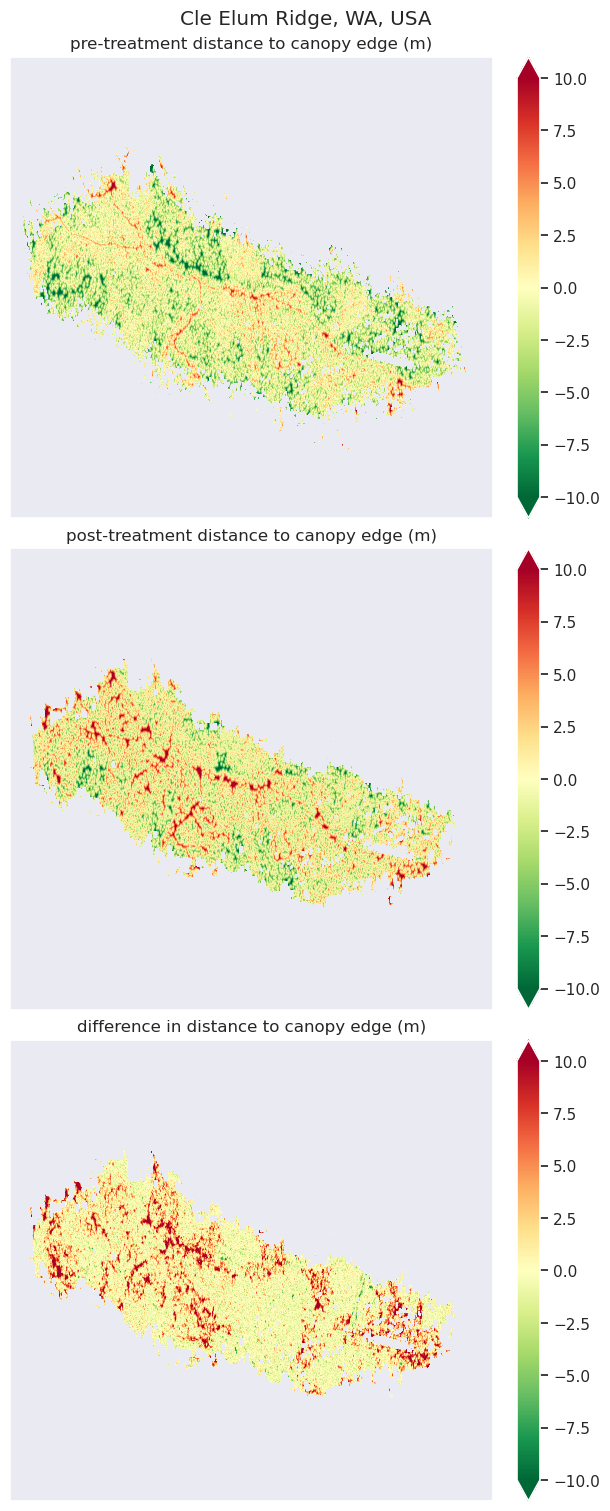

In [73]:
fig, axes = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(6,15), constrained_layout = True)

fig.suptitle('Cle Elum Ridge, WA, USA')

ds.dce_ncalm.plot(ax=axes[0], cmap='RdYlGn_r', vmin=-10, vmax=10, cbar_kwargs={'label':''})
ds.dce_rapid.plot(ax=axes[1], cmap='RdYlGn_r', vmin=-10, vmax=10, cbar_kwargs={'label':''})
ds.diff_dce_rapid_ncalm.plot(ax=axes[2], cmap='RdYlGn_r', vmin=-10, vmax=10, cbar_kwargs={'label':''})

axes[0].set_title('pre-treatment distance to canopy edge (m)')
axes[1].set_title('post-treatment distance to canopy edge (m)')
axes[2].set_title('difference in distance to canopy edge (m)')


axes[0].set_xlabel('')
axes[0].set_ylabel('') 
axes[0].set_xticks([])
axes[0].set_yticks([])

axes[1].set_xlabel('')
axes[1].set_ylabel('') 
axes[1].set_xticks([])
axes[1].set_yticks([])

axes[2].set_xlabel('')
axes[2].set_ylabel('') 
axes[2].set_xticks([])
axes[2].set_yticks([])

plt.show()

Making a new script for random forest work....
